In [1]:
import pandas as pd
import numpy as np
import warnings as wn
wn.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.drawing.image import Image

In [2]:
data1=pd.read_excel('2024_cohorts_merged_edited_copy1.xlsx',header=5)


In [3]:
df=data1.copy()

In [4]:
data_filtered=df[(df['pre_cohort']==2022)]

In [5]:
data_filtered['pre_district'].unique()

array(['Kanungu', 'kanungu', 'Kaliro', 'Rubanda', 'Kagadi_Standard',
       'Kyenjojo', 'Mitooma', 'Rubirizi', 'Rukungiri', 'Kibaale',
       'Kagadi_GAC'], dtype=object)

In [6]:
data_filtered['pre_district']=np.where((data_filtered['pre_district']=='kanungu'),'Kanungu',data_filtered['pre_district'])

In [7]:
# Custom function to sum values but return a blank space if all values are NaN
def sum_or_blank(row):
    if row.isnull().all():
        return ''
    else:
        return row.sum()

## Participation analysis

In [8]:
data_filtered['seasonal_part']=data_filtered[['Season1_cropped','Season2_cropped']].sum(axis=1)

In [9]:
data_filtered['Vegetable_part'] = data_filtered[['grow_vegetables', 'sn_2_grow_vegetables']].apply(
    lambda row: np.nan if row.isnull().all() else row.apply(pd.to_numeric, errors='coerce').sum(), axis=1
)

In [10]:
data_filtered['seasonal_part1']=data_filtered['seasonal_part'].apply(lambda x: 1 if x>0 else 0)

In [11]:
data_filtered['Vegetable_part1']=data_filtered['Vegetable_part'].apply(lambda x: 1 if x>0 else 0)

In [12]:
#generating analysis on seasonal vegetable and perennial participation
data_filtered.groupby('STATUS')[['seasonal_part1','Vegetable_part1',
                                 'perennial_cropping']].mean()#.to_excel('seasonal vegetable and perennial participation.xlsx')

,seasonal_part1,Vegetable_part1,perennial_cropping
STATUS,,,
PEER,0.974528,0.464151,0.837634
RTV,0.964478,0.823003,0.959892


In [13]:
#generating analysis on seasonal vegetable and perennial participation
data_filtered.groupby(['STATUS','pre_district'])[['seasonal_part1','Vegetable_part1',
                                 'perennial_cropping']].mean().to_excel('pre_district perennial participation.xlsx')

In [14]:
#generating column for households participating in seasonal crops only
data_filtered['part_seasonal_crop_only']=np.where(
                                    ((data_filtered['Vegetable_part1']>0)|(data_filtered['perennial_cropping']>0))& 
    (data_filtered['seasonal_part1']>0),0,1)

In [15]:
data_filtered.groupby('STATUS')['part_seasonal_crop_only'].mean()

STATUS
PEER    0.122956
RTV     0.049853
Name: part_seasonal_crop_only, dtype: float64

In [16]:
data_filtered['part_seasonal_crop_only'] = np.where(
   (data_filtered['seasonal_part1'] == 1) & 
   (data_filtered['Vegetable_part1'] != 1) & 
   (data_filtered['perennial_cropping'] != 1), 
    1, 
    0
)
data_filtered.groupby('STATUS')['part_seasonal_crop_only'].mean()

STATUS
PEER    0.097484
RTV     0.014331
Name: part_seasonal_crop_only, dtype: float64

In [17]:
data_agric_only=data_filtered[data_filtered['Agriculture Value (USD_Cons_rate)']>0]

In [18]:
data_agric_only['part_seasonal_crop_only'] = np.where(
       (data_agric_only['seasonal_part1'] == 1) & 
       (data_agric_only['Vegetable_part1'] != 1) & 
       (data_agric_only['perennial_cropping'] != 1), 
    1, 
    0
)
data_agric_only.groupby('STATUS')['part_seasonal_crop_only'].mean()

STATUS
PEER    0.098444
RTV     0.014372
Name: part_seasonal_crop_only, dtype: float64

In [19]:
#generating column for households participating in Vegetables crops only
data_agric_only['part_seasonal_veg_only'] = np.where(
       (data_agric_only['Vegetable_part1'] == 1) & 
      (data_agric_only['seasonal_part1'] != 1) & 
     (data_agric_only['perennial_cropping'] != 1), 
    1, 
    0
)

In [20]:
data_agric_only.groupby('STATUS')['part_seasonal_veg_only'].mean()

STATUS
PEER    0.000318
RTV     0.000614
Name: part_seasonal_veg_only, dtype: float64

In [21]:
#generating column for households participating in perennials crops only
data_agric_only['perennial_cropping_only']=np.where(
       (data_agric_only['perennial_cropping'] == 1) & 
      (data_agric_only['seasonal_part1'] != 1) & 
     (data_agric_only['Vegetable_part1'] != 1), 
    1, 
    0
)

In [22]:
#generating column for households participating in all categories crops only
data_agric_only['All_categories']=np.where(
    (data_agric_only['perennial_cropping']>0) & 
    (data_agric_only['seasonal_part1']>0) &
    (data_agric_only['Vegetable_part1']>0),1,0)

In [23]:
#generating column for households participating in  seasonal and perennial crops only
data_agric_only['Seasonal_perennials']=np.where(
    ((data_agric_only['perennial_cropping']>0) & 
    (data_agric_only['seasonal_part1']>0)) & 
    (data_agric_only['Vegetable_part1']!=1),1,0)

In [24]:
#generating column for households participating in  seasonal and vegetables crops only
data_agric_only['Seasonal_vegetables']=np.where(
    ((data_agric_only['seasonal_part1']>0)& 
    (data_agric_only['Vegetable_part1']>0))&(data_agric_only['perennial_cropping']!=1),1,0)

In [25]:
#generating column for households participating in  perennials and vegetables crops only
data_agric_only['vegetables_perennials']=np.where(
    ((data_agric_only['perennial_cropping']>0) &(data_agric_only['Vegetable_part1']>0))&
    (data_agric_only['seasonal_part1']!=1),1,0)

In [26]:
#generating participation in different categories of seasonal, perennials and vegetables
data_agric_only.groupby('STATUS')[['part_seasonal_crop_only','part_seasonal_veg_only','perennial_cropping_only',
               'All_categories','Seasonal_perennials','Seasonal_vegetables',
                        'vegetables_perennials']].mean().to_excel('participation in veg pere sea.xlsx')

In [27]:
data_filtered['part_agric'] = np.where(
    (data_filtered['perennial_cropping'] > 0) | 
    (data_filtered['seasonal_part1'] > 0) |  
    (data_filtered['Vegetable_part1'] > 0), 1, 0
)

In [28]:
data_filtered.groupby(['STATUS','part_agric'])['Agriculture Value (USD_Cons_rate)'].mean().to_excel('chart1.xlsx')

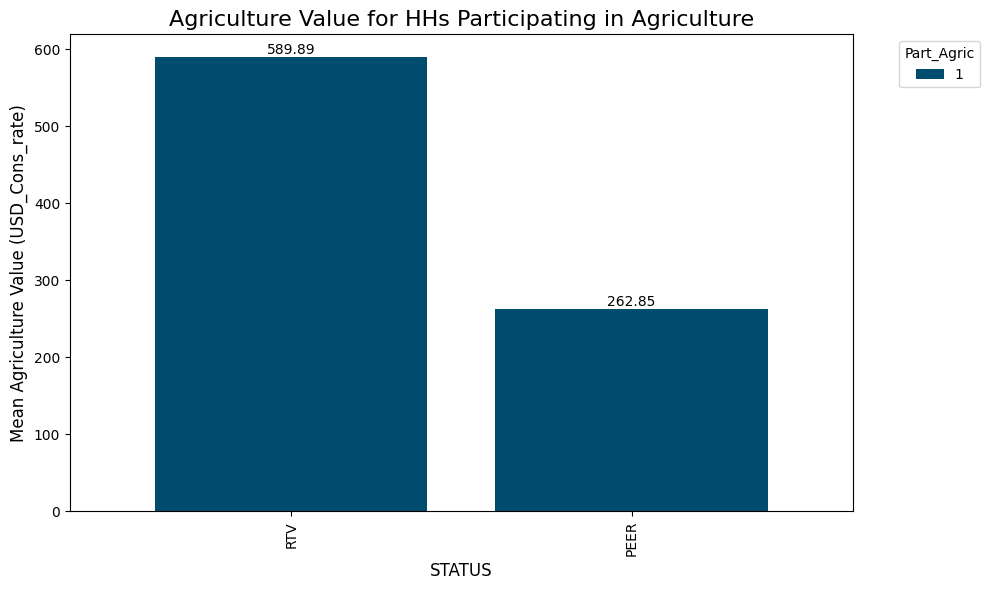

In [29]:

# Specify the desired order for 'STATUS', starting with 'RTV' and ending with 'PEER'
status_order = ['RTV', 'PEER']

# Reorder 'STATUS' based on the specified order
# Assuming you have already filtered your data to include only RTV and PEER statuses
filtered_data_rtv_peer = data_filtered[data_filtered['STATUS'].isin(['RTV', 'PEER'])]

# Group by 'STATUS' and 'part_agric', and calculate the mean of 'Agriculture Value (USD_Cons_rate)'
mean_values = filtered_data_rtv_peer.groupby(['STATUS', 'part_agric'])['Agriculture Value (USD_Cons_rate)'].mean().unstack()

# Remove columns where all values are zero
mean_values = mean_values.loc[:, (mean_values != 0).any(axis=0)]

# Drop rows where all values are NaN
mean_values = mean_values.dropna(how='all')
mean_values = mean_values.reindex(status_order)

# Define custom colors for each 'part_agric' category (you can add more colors if needed)
colors = ["#004C6E"]

# Plotting the bar graph with custom colors
ax = mean_values.plot(kind='bar', figsize=(10, 6), width=0.8, color=colors)

# Adding mean values on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

# Adding labels and title
plt.title('Agriculture Value for HHs Participating in Agriculture', fontsize=16)
plt.xlabel('STATUS', fontsize=12)
plt.ylabel('Mean Agriculture Value (USD_Cons_rate)', fontsize=12)

# Improve legend
plt.legend(title='Part_Agric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save and display the graph
plt.savefig('graph_for_agric_value_of_those_engaged_in_agric.png', dpi=300, bbox_inches='tight')
plt.show()


In [30]:
data_filtered['Agriculture Income (USD_Cons_rate)']=data_filtered[['Seasonal Crops Income (USD_Cons_rate)',
                                                                   'Perenial Crops Income (USD_Cons_rate)']].sum(axis=1)

In [31]:
data_filtered.groupby(['STATUS', 'part_agric'])['Agriculture Income (USD_Cons_rate)'].mean().to_excel('chart2.xlsx')

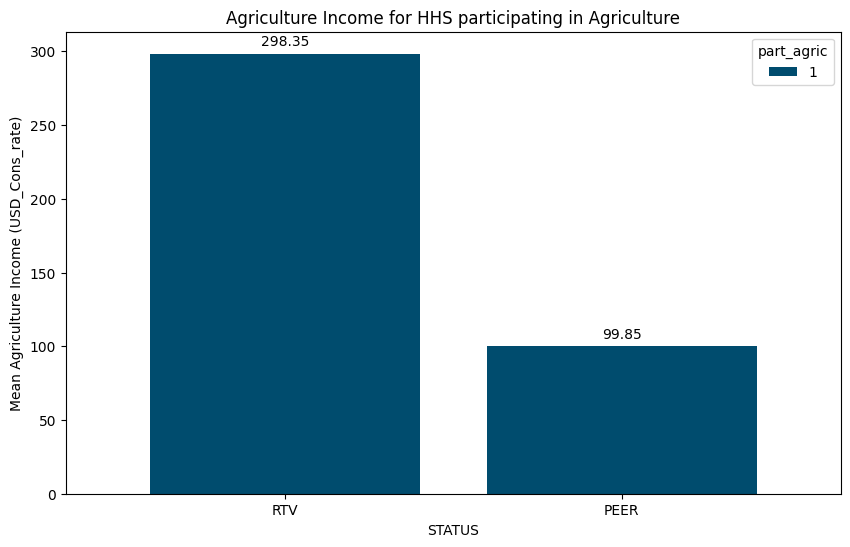

In [32]:
# Specify the order of STATUS so that RTV comes first and PEER comes second
status_order = ['RTV', 'PEER']

# Group by 'STATUS' and 'part_agric', and calculate the mean of 'Agriculture Income (USD_Cons_rate)'
mean_values = data_filtered.groupby(['STATUS', 'part_agric'])['Agriculture Income (USD_Cons_rate)'].mean().unstack()

# Reindex to ensure the correct order of STATUS
mean_values = mean_values.reindex(status_order)

# Remove any rows (bars) with zero or NaN frequencies
mean_values = mean_values.loc[:, (mean_values != 0).any(axis=0)]  # Remove columns where all values are zero
mean_values = mean_values.dropna(how='all')  # Drop rows where all values are NaN

# Plotting the bar graph with navy blue color
ax = mean_values.plot(kind='bar', figsize=(10, 6), width=0.8, color="#004C6E")

# Adding mean values on top of each bar
for p in ax.patches:
    if p.get_height() > 0:  # Only annotate bars with non-zero values
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), 
                    textcoords='offset points')

# Adding labels and title
plt.title('Agriculture Income for HHS participating in Agriculture')
plt.xlabel('STATUS')
plt.ylabel('Mean Agriculture Income (USD_Cons_rate)')
plt.xticks(rotation=0)  # Keep the STATUS labels horizontal
plt.savefig('graph_for_agric_income_of_those_engaged_in_agric.png', dpi=300, bbox_inches='tight')

# Display the bar graph
plt.show()


In [33]:
data_filtered['seasonal _part_earn']=np.where((data_filtered['Seasonal Crops Income (USD_Cons_rate)']>0)& (data_filtered['seasonal_part1']>0),1,0)


In [34]:
data_filtered['perennial _part_earn']=np.where((data_filtered['Perenial Crops Income (USD_Cons_rate)']>0)& (data_filtered['perennial_cropping']>0),1,0)

In [35]:
#generating percentages of those earning from seasonal and perennials
data_filtered.groupby('STATUS')[['seasonal _part_earn',
                                 'perennial _part_earn']].mean()#.to_excel('percentage of those earning from seasonal and perennial crops.xlsx')

,seasonal _part_earn,perennial _part_earn
STATUS,,
PEER,0.889937,0.539623
RTV,0.929569,0.888535


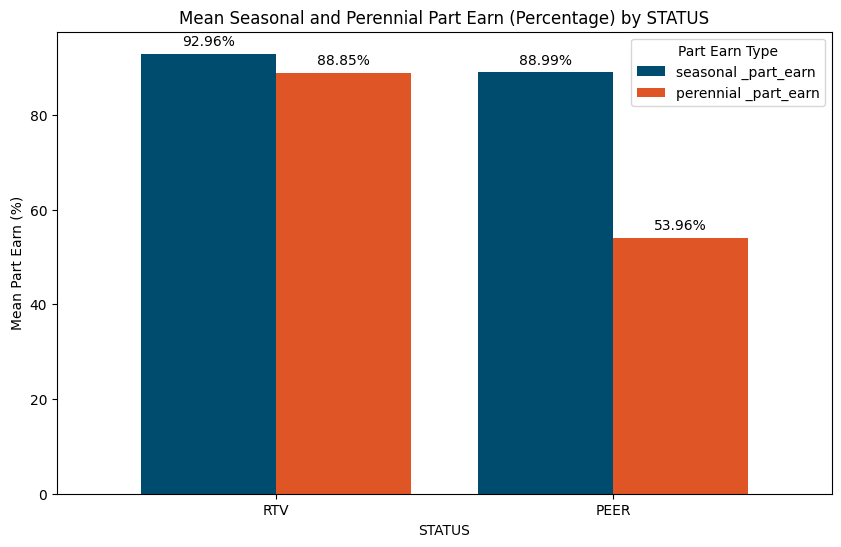

In [36]:
# Specify the order of STATUS so that RTV comes first and PEER comes second
status_order = ['RTV', 'PEER']

# Group by 'STATUS' and calculate the mean for both 'seasonal_part_earn' and 'perennial_part_earn', ensuring correct order
mean_values = data_filtered.groupby('STATUS')[['seasonal _part_earn', 'perennial _part_earn']].mean()

# Reindex the mean values to ensure the correct order of STATUS
mean_values = mean_values.reindex(status_order)

# Convert mean values to percentages (assuming the total possible value is 1.0 for 100%)
mean_values_percentage = mean_values * 100

# Plotting the bar graph, with color matching RTV and PEER
ax = mean_values_percentage.plot(kind='bar', figsize=(10, 6), width=0.8, color=["#004C6E", '#E05525'])

# Adding mean percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points')

# Adding labels and title
plt.title('Mean Seasonal and Perennial Part Earn (Percentage) by STATUS')
plt.xlabel('STATUS')
plt.ylabel('Mean Part Earn (%)')
plt.xticks(rotation=0)  # Keep the STATUS labels horizontal

# Display the bar graph
plt.legend(title='Part Earn Type')
plt.savefig('graph_for_percentage_of_earnings_from_seasonal_and_perennials.png', dpi=300, bbox_inches='tight')
plt.show()


In [37]:
#generating seasonal one participation in major seasonal crops 
data_agric_only.groupby('STATUS')[['Season_1_1','Season_1_13','Season_1_5','Season_1_2','Season_1_7','Season_1_14',
                                 'Season_1_6','Season_1_12','Season_1_3']].mean().to_excel('seasonal one participation in major seasonal crops.xlsx')

In [38]:
data_agric_only.groupby('STATUS')[['Season_1_1','Season_1_2','Season_1_3','Season_1_4','Season_1_5','Season_1_6','Season_1_7',
                                   'Season_1_8','Season_1_9','Season_1_10','Season_1_11','Season_1_12','Season_1_13','Season_1_14',
                                   'Season_1_15','Season_1_97']].mean().to_excel('season one.xlsx')

In [39]:
data_agric_only.groupby('STATUS')[['Season_2_1','Season_2_2','Season_2_3','Season_2_4','Season_2_5','Season_2_6','Season_2_7',
                                   'Season_2_8','Season_2_9','Season_2_10','Season_2_11','Season_2_12','Season_2_13','Season_2_14',
                                   'Season_2_15','Season_1_97']].mean().to_excel('season two.xlsx')

In [40]:
data_agric_only['beans_combined'] = np.where(
    data_agric_only[['Season_1_1', 'Season_2_1']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Ground Nuts_combined'] = np.where(
    data_agric_only[['Season_1_2', 'Season_2_2']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Soya_beans_combined'] = np.where(
    data_agric_only[['Season_1_3', 'Season_2_3']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Maize_combined'] = np.where(
    data_agric_only[['Season_1_5', 'Season_2_5']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Millet_combined'] = np.where(
    data_agric_only[['Season_1_6', 'Season_2_6']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Sorghum_combined'] = np.where(
    data_agric_only[['Season_1_7', 'Season_2_7']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Irish Potatoes_combined'] = np.where(
    data_agric_only[['Season_1_12', 'Season_2_12']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Sweet Potatoes_combined'] = np.where(
    data_agric_only[['Season_1_13', 'Season_2_13']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['cassava_combined'] = np.where(
    data_agric_only[['Season_1_14', 'Season_2_14']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['peas_combined'] = np.where(
    data_agric_only[['Season_1_4', 'Season_2_4']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Barley_combined'] = np.where(
    data_agric_only[['Season_1_8', 'Season_2_8']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Rice_combined'] = np.where(
    data_agric_only[['Season_1_9', 'Season_2_9']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['Garlic_combined'] = np.where(
    data_agric_only[['Season_1_10', 'Season_2_10']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['ginger_combined'] = np.where(
    data_agric_only[['Season_1_11', 'Season_2_11']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['yams_combined'] = np.where(
    data_agric_only[['Season_1_15', 'Season_2_15']].sum(axis=1) > 0,
    1,
    0
)

data_agric_only['others_combined'] = np.where(
    data_agric_only[['Season_1_97', 'Season_2_97']].sum(axis=1) > 0,
    1,
    0
)


In [41]:
#generating seasonal two participation in major seasonal crops 
data_agric_only.groupby('STATUS')[['Season_2_1','Season_2_13','Season_2_5','Season_2_2','Season_2_7','Season_2_14',
                                 'Season_2_6','Season_2_12','Season_2_3']].mean().to_excel('seasonal two participation in major seasonal crops.xlsx')

In [42]:
data_filtered.loc[(data_filtered['coffee_sold_process_robusta'] > 0) & 
                  (data_filtered['perennial_crops_grown_4'].isna() | (data_filtered['perennial_crops_grown_4'] == 0)), 
                  'perennial_crops_grown_4'] = 1

In [43]:
#generating participation in major perennial crops
data_filtered.groupby('STATUS')[['perennial_crops_grown_1','perennial_crops_grown_2','perennial_crops_grown_3','perennial_crops_grown_4',
                                 'perennial_crops_grown_6']].mean().to_excel('participation in major perennial crops.xlsx')

In [44]:
# Filter columns that start with 'perennial_crops_grown_'
perennial_columns = data_filtered.filter(like='perennial_crops_grown_')
# Calculate the mean for each of these columns
perennial_means = perennial_columns.mean()
# Display the results
perennial_means.to_excel('major perennial crops grown .xlsx')

In [45]:
data_filtered['beans_improved_planted']=np.where(
                                                 (data_filtered['sn_1_beans_planted_impr']>0) | 
                                                 (data_filtered['sn_2_beans_planted_impr']>0),1,0)

In [46]:
data_filtered['Maize_improved_planted']=np.where(
                                                 (data_filtered['sn_1_maize_planted_impr']>0) | 
                                                 (data_filtered['sn_2_maize_planted_impr']>0),1,0)

In [47]:
data_filtered['Gnuts_improved_planted']=np.where(
                                                 (data_filtered['sn_1_gnuts_planted_impr']>0) | 
                                                 (data_filtered['sn_2_gnuts_planted_impr']>0),1,0)

In [48]:
data_filtered['peas_improved_planted']=np.where(
                                                 (data_filtered['sn_1_peas_planted_impr']>0) | 
                                                 (data_filtered['sn_1_peas_planted_impr']>0),1,0)

In [49]:
data_filtered['soya_peas_improved_planted']=np.where(
                                                 (data_filtered['sn_1_soya_beans_planted_impr']>0) | 
                                                 (data_filtered['sn_1_soya_beans_planted_impr']>0),1,0)

In [50]:
data_filtered['Irish_improved_planted']=data_filtered['sn_1_irish_potatoes_planted_impr'].apply(lambda x: 1 if x>0 else 0)                                                 

In [51]:
data_filtered['general_part_improved']=np.where((data_filtered['beans_improved_planted']==1)|
                                                (data_filtered['Maize_improved_planted']==1)|
                                                (data_filtered['Gnuts_improved_planted']==1),1,0)

In [52]:
#participation in planting improved seeds groupby status
data_filtered.groupby(['STATUS'])[['beans_improved_planted','Maize_improved_planted',
               'Gnuts_improved_planted','peas_improved_planted',
               'soya_peas_improved_planted','Irish_improved_planted','general_part_improved']].mean().to_excel('participation in planting improved seeds .xlsx')

## YIELD PER UNIT ANALYSTICS

In [53]:
data_filtered.loc[:,'total_yield_beans(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_beans_Total_Yield']) and pd.isna(row['sn_2_beans_Total_Yield']) else row['sn_1_beans_Total_Yield'] + row['sn_2_beans_Total_Yield'] if not (pd.isna(row['sn_1_beans_Total_Yield']) or pd.isna(row['sn_2_beans_Total_Yield'])) else row[['sn_1_beans_Total_Yield', 'sn_2_beans_Total_Yield']].sum(), axis=1)

data_filtered.loc[:, 'total_yield_gnuts(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_gnuts_Total_Yield']) and pd.isna(row['sn_2_gnuts_Total_Yield']) else row['sn_1_gnuts_Total_Yield'] + row['sn_2_gnuts_Total_Yield'] if not (pd.isna(row['sn_1_gnuts_Total_Yield']) or pd.isna(row['sn_2_gnuts_Total_Yield'])) else row[['sn_1_gnuts_Total_Yield', 'sn_2_gnuts_Total_Yield']].sum(), axis=1)

data_filtered.loc[:, 'total_yield_maize(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_maize_Total_Yield']) and pd.isna(row['sn_2_maize_Total_Yield']) else row['sn_1_maize_Total_Yield'] + row['sn_2_maize_Total_Yield'] if not (pd.isna(row['sn_1_maize_Total_Yield']) or pd.isna(row['sn_2_maize_Total_Yield'])) else row[['sn_1_maize_Total_Yield', 'sn_2_maize_Total_Yield']].sum(), axis=1)

data_filtered.loc[:, 'total_yield_millet(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_millet_Total_Yield']) and pd.isna(row['sn_2_millet_Total_Yield']) else row['sn_1_millet_Total_Yield'] + row['sn_2_millet_Total_Yield'] if not(pd.isna(row['sn_1_millet_Total_Yield']) or pd.isna(row['sn_2_millet_Total_Yield'])) else row[['sn_1_millet_Total_Yield', 'sn_2_millet_Total_Yield']].sum(), axis=1)

data_filtered.loc[:, 'total_yield_rice(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_rice_Total_Yield']) and pd.isna(row['sn_2_rice_Total_Yield']) else row['sn_1_rice_Total_Yield'] + row['sn_2_rice_Total_Yield'] if not(pd.isna(row['sn_1_rice_Total_Yield']) or pd.isna(row['sn_2_rice_Total_Yield'])) else row[['sn_1_rice_Total_Yield', 'sn_2_rice_Total_Yield']].sum(), axis=1)

data_filtered.loc[:, 'total_yield_irish_pot(bags)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_irish_potatoes_Total_Yield']) and pd.isna(row['sn_2_irish_potatoes_Total_Yield']) else row['sn_1_irish_potatoes_Total_Yield'] + row['sn_2_irish_potatoes_Total_Yield'] if not(pd.isna(row['sn_1_irish_potatoes_Total_Yield']) or pd.isna(row['sn_2_irish_potatoes_Total_Yield'])) else row[['sn_1_irish_potatoes_Total_Yield', 'sn_2_irish_potatoes_Total_Yield']].sum(), axis=1)
data_filtered.loc[:, 'total_yield_peas(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_peas_Total_Yield']) and pd.isna(row['sn_2_peas_Total_Yield']) else row['sn_1_peas_Total_Yield'] + row['sn_2_peas_Total_Yield'] if not(pd.isna(row['sn_1_peas_Total_Yield']) or pd.isna(row['sn_2_peas_Total_Yield'])) else row[['sn_1_peas_Total_Yield', 'sn_2_peas_Total_Yield']].sum(), axis=1)
data_filtered.loc[:, 'total_yield_sorghum(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_sorghum_Total_Yield']) and pd.isna(row['sn_2_sorghum_Total_Yield']) else row['sn_1_sorghum_Total_Yield'] + row['sn_2_sorghum_Total_Yield'] if not(pd.isna(row['sn_1_sorghum_Total_Yield']) or pd.isna(row['sn_2_sorghum_Total_Yield'])) else row[['sn_1_sorghum_Total_Yield', 'sn_2_sorghum_Total_Yield']].sum(), axis=1)
data_filtered.loc[:, 'total_yield_soyabeans(Kgs)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_soya_beans_Total_Yield']) and pd.isna(row['sn_2_soya_beans_Total_Yield']) else row['sn_1_soya_beans_Total_Yield'] + row['sn_2_soya_beans_Total_Yield'] if not(pd.isna(row['sn_1_soya_beans_Total_Yield']) or pd.isna(row['sn_2_soya_beans_Total_Yield'])) else row[['sn_1_soya_beans_Total_Yield', 'sn_2_soya_beans_Total_Yield']].sum(), axis=1)
data_filtered.loc[:, 'total_yield_cassava(Bags)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_cassava_Total_Yield']) and pd.isna(row['sn_2_cassava_Total_Yield']) else row['sn_1_cassava_Total_Yield'] + row['sn_2_cassava_Total_Yield'] if not(pd.isna(row['sn_1_cassava_Total_Yield']) or pd.isna(row['sn_2_cassava_Total_Yield'])) else row[['sn_1_cassava_Total_Yield', 'sn_2_cassava_Total_Yield']].sum(), axis=1)
data_filtered.loc[:, 'total_yield_sweetpotatoes(Bags)'] = data_filtered.apply(lambda row: np.nan if pd.isna(row['sn_1_sweetpotatoes_Total_Yield']) and pd.isna(row['sn_2_sweetpotatoes_Total_Yield']) else row['sn_1_sweetpotatoes_Total_Yield'] + row['sn_2_sweetpotatoes_Total_Yield'] if not(pd.isna(row['sn_1_sweetpotatoes_Total_Yield']) or pd.isna(row['sn_2_sweetpotatoes_Total_Yield'])) else row[['sn_1_sweetpotatoes_Total_Yield', 'sn_2_sweetpotatoes_Total_Yield']].sum(), axis=1)


In [54]:
# Calculate total yields
data_filtered['total_beans_sold'] = data_filtered[['sn_1_beans_Total_Yield_sold_Fresh', 'sn_2_beans_Total_Yield_sold_Fresh',
                                                    'sn_1_beans_Total_Yield_sold_dry', 'sn_2_beans_Total_Yield_sold_dry']].sum(axis=1)

data_filtered['total_maize_sold'] = data_filtered[['sn_1_maize_Total_Yield_sold_Fresh', 'sn_2_maize_Total_Yield_sold_Fresh',
                                                    'sn_1_maize_Total_Yield_sold_dry', 'sn_2_maize_Total_Yield_sold_dry']].sum(axis=1)

data_filtered['total_irish_sold'] = data_filtered[['sn_1_irish_potatoes_Total_Yield_sold', 'sn_2_irish_potatoes_Total_Yield_sold']].sum(axis=1)

data_filtered['total_Gnuts_sold'] = data_filtered[['sn_1_gnuts_Total_Yield_sold', 'sn_2_gnuts_Total_Yield_sold']].sum(axis=1)

data_filtered['total_millet_sold'] = data_filtered[['sn_1_millet_Total_Yield_sold', 'sn_2_millet_Total_Yield_sold']].sum(axis=1)

data_filtered['total_Sorghum_sold'] = data_filtered[['sn_1_sorghum_Total_Yield_sold', 'sn_2_sorghum_Total_Yield_sold']].sum(axis=1)

data_filtered['total_sweet_potatoes_sold'] = data_filtered[['sn_1_sweetpotatoes_Total_Yield_sold', 'sn_2_sweetpotatoes_Total_Yield_sold']].sum(axis=1)

data_filtered['total_cassava_sold'] = data_filtered[['sn_1_cassava_Total_Yield_sold_Fresh', 'sn_2_cassava_Total_Yield_sold_Fresh',
                                                    'sn_1_cassava_Total_Yield_sold_dry', 'sn_2_cassava_Total_Yield_sold_dry']].sum(axis=1)

data_filtered['total_soya_bean_sold'] = data_filtered[['sn_1_soya_beans_Total_Yield_sold', 'sn_2_soya_beans_Total_Yield_sold']].sum(axis=1)

# Replace zeros with NaN only in total sold columns
total_sold_columns = [
    'total_beans_sold',
    'total_maize_sold',
    'total_irish_sold',
    'total_Gnuts_sold',
    'total_millet_sold',
    'total_Sorghum_sold',
    'total_sweet_potatoes_sold',
    'total_cassava_sold',
    'total_soya_bean_sold'
]

data_filtered[total_sold_columns] = data_filtered[total_sold_columns].replace(0, np.nan)

In [55]:
data_filtered['total_yield_maize(Kgs)_adjusted2'] = data_filtered.apply(
    lambda row: row['total_maize_sold'] if row['total_maize_sold'] > row['total_yield_maize(Kgs)'] else row['total_yield_maize(Kgs)'], 
    axis=1
)

In [56]:
data_filtered['total_yield_maize(Kgs)_adjusted5'] = data_filtered.apply(
    lambda row: 350 if row['total_yield_maize(Kgs)_adjusted2'] > 350 and row['STATUS'] == 'PEER' else row['total_yield_maize(Kgs)_adjusted2'], 
    axis=1
)

In [57]:

# data_filtered['total_yield_soyabeans(Kgs)'] = data_filtered.apply(
#     lambda row: row['total_soya_bean_sold'] if row['total_soya_bean_sold'] > row['total_yield_soyabeans(Kgs)'] else row['total_yield_soyabeans(Kgs)'], 
#     axis=1
# )
data_filtered['total_yield_soyabeans(Kgs)_adjusted'] = data_filtered.apply(
    lambda row: 50 if row['total_yield_soyabeans(Kgs)']<50 and row['STATUS'] == 'PEER' else row['total_yield_soyabeans(Kgs)'], 
     axis=1
 )

In [58]:
data_filtered['Planted_beans'] = data_filtered[['sn_1_beans_planted', 'sn_2_beans_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_irish_pot'] = data_filtered[['sn_1_irish_potatoes_planted', 'sn_2_irish_potatoes_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_sorghum'] = data_filtered[['sn_1_sorghum_planted', 'sn_2_sorghum_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_maize'] = data_filtered[['sn_1_maize_planted', 'sn_2_maize_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_gnuts'] = data_filtered[['sn_1_gnuts_planted', 'sn_2_gnuts_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_rice'] = data_filtered[['sn_1_rice_planted', 'sn_2_rice_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_millet'] = data_filtered[['sn_1_millet_planted', 'sn_2_millet_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_peas'] = data_filtered[['sn_1_peas_planted', 'sn_2_peas_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_soya'] = data_filtered[['sn_1_soya_beans_planted', 'sn_2_soya_beans_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_cassava'] = data_filtered[['sn_1_cassava_planted', 'sn_2_cassava_planted']].sum(axis=1).replace(0, np.nan)
data_filtered['planted_sweet_potatoes'] = data_filtered[['sn_1_sweetpotatoes_planted', 'sn_2_sweetpotatoes_planted']].sum(axis=1).replace(0, np.nan)

In [59]:
# Computes the average planted for the major seasonal crops 
data_filtered.groupby(['STATUS'])[['Planted_beans','planted_irish_pot','planted_sorghum','planted_maize','planted_gnuts',
                                'planted_rice','planted_millet','planted_peas','planted_soya']].mean().to_excel('the average planted for the major seasonal crops.xlsx')

In [60]:
# Define the variables (average_planted) to test
test_yield_variables = ['Planted_beans','planted_irish_pot','planted_sorghum','planted_maize','planted_gnuts','planted_rice',
                       'planted_millet','planted_peas','planted_soya']

# Initialize a dictionary to store the mean results and p-values
price_mean_results = {}

# Get the two unique STATUS groups (PEER and RTV)
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_yield_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        p_value = round(p_value, 4)  # Truncate p-value to 4 decimal places

        # Save the means and p-value for each variable
        price_mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")

T-test for Planted_beans: P-value (truncated) = 0.0031
Significant difference in Planted_beans means between PEER and RTV (p < 0.05)

T-test for planted_irish_pot: P-value (truncated) = 0.005
Significant difference in planted_irish_pot means between PEER and RTV (p < 0.05)

T-test for planted_sorghum: P-value (truncated) = 0.4995
No significant difference in planted_sorghum means between PEER and RTV (p >= 0.05)

T-test for planted_maize: P-value (truncated) = 0.0
Significant difference in planted_maize means between PEER and RTV (p < 0.05)

T-test for planted_gnuts: P-value (truncated) = 0.0
Significant difference in planted_gnuts means between PEER and RTV (p < 0.05)

T-test for planted_rice: P-value (truncated) = 0.0014
Significant difference in planted_rice means between PEER and RTV (p < 0.05)

T-test for planted_millet: P-value (truncated) = 0.0001
Significant difference in planted_millet means between PEER and RTV (p < 0.05)

T-test for planted_peas: P-value (truncated) = 0.7025

In [61]:
data_filtered['tea_yeild']=np.where(data_filtered['tea_yeild']==30000,3000,
                                 np.where(data_filtered['tea_yeild']==24000,2400,data_filtered['tea_yeild']))

### Seasonal Total yield analysis

In [62]:
# Computes the yield per unit for the crops of interest using total planted and total yield
data_filtered['beans yield per unit'] = data_filtered['total_yield_beans(Kgs)'] / data_filtered['Planted_beans']
data_filtered['soya beans yield per unit'] = data_filtered['total_yield_soyabeans(Kgs)']/ data_filtered['planted_soya']
data_filtered['peas yield per unit'] = data_filtered[ 'total_yield_peas(Kgs)'] / data_filtered['planted_peas']
data_filtered['gnuts yield per unit'] = data_filtered[ 'total_yield_gnuts(Kgs)'] / data_filtered['planted_gnuts']
data_filtered['maize yield per unit'] = data_filtered['total_yield_maize(Kgs)'] / data_filtered['planted_maize']
data_filtered['millet yield per unit'] = data_filtered['total_yield_millet(Kgs)'] / data_filtered['planted_millet']
data_filtered['rice yield per unit'] = data_filtered['total_yield_rice(Kgs)'] / data_filtered['planted_rice']
data_filtered['sorghum yield per unit'] = data_filtered['total_yield_sorghum(Kgs)'] / data_filtered['planted_sorghum']
data_filtered['Irish yield per unit'] = data_filtered['total_yield_irish_pot(bags)'] / data_filtered['planted_irish_pot']

In [63]:
data_filtered.groupby(['STATUS'])[['total_yield_beans(Kgs)', 'total_yield_soyabeans(Kgs)_adjusted', 'total_yield_peas(Kgs)',
                                   'total_yield_gnuts(Kgs)', 'total_yield_maize(Kgs)_adjusted5',
                                   'total_yield_millet(Kgs)', 'total_yield_rice(Kgs)', 'total_yield_sorghum(Kgs)',
                                   'total_yield_irish_pot(bags)','total_yield_cassava(Bags)','total_yield_sweetpotatoes(Bags)']].mean().to_excel('total_yield_for_major_seasonal_crops.xlsx')

In [64]:
from scipy.stats import ttest_ind
# List of yield variables to test
yield_variables = [
    'total_yield_beans(Kgs)', 'total_yield_soyabeans(Kgs)', 'total_yield_soyabeans(Kgs)_adjusted',
    'total_yield_peas(Kgs)', 'total_yield_gnuts(Kgs)', 'total_yield_maize(Kgs)', 'total_yield_maize(Kgs)_adjusted5',
    'total_yield_millet(Kgs)', 'total_yield_rice(Kgs)', 'total_yield_sorghum(Kgs)',
    'total_yield_irish_pot(bags)', 'total_yield_cassava(Bags)', 'total_yield_sweetpotatoes(Bags)'
]

# Filter data for RTV and PEER
rtv_group = data_filtered[data_filtered['STATUS'] == 'RTV']
peer_group = data_filtered[data_filtered['STATUS'] == 'PEER']

# Significance threshold
alpha = 0.05

# Perform t-test for each yield variable
for variable in yield_variables:
    rtv_values = rtv_group[variable].dropna()  # Remove NaN values
    peer_values = peer_group[variable].dropna()
    
    # Perform t-test
    t_stat, p_value = ttest_ind(rtv_values, peer_values, equal_var=False)  # Welch's t-test for unequal variances
    
    # Round p-value to 4 decimal places
    p_value_rounded = round(p_value, 4)
    
    # Determine if significant
    if p_value_rounded < alpha:
        significance = 'Significant'
    else:
        significance = 'Not Significant'
    
    # Print result
    print(f"{variable}: t-statistic = {t_stat:.4f}, p-value = {p_value_rounded}, {significance}")


total_yield_beans(Kgs): t-statistic = 32.0131, p-value = 0.0, Significant
total_yield_soyabeans(Kgs): t-statistic = 10.3911, p-value = 0.0, Significant
total_yield_soyabeans(Kgs)_adjusted: t-statistic = 8.4047, p-value = 0.0, Significant
total_yield_peas(Kgs): t-statistic = 0.5823, p-value = 0.5617, Not Significant
total_yield_gnuts(Kgs): t-statistic = 29.8965, p-value = 0.0, Significant
total_yield_maize(Kgs): t-statistic = -8.0754, p-value = 0.0, Significant
total_yield_maize(Kgs)_adjusted5: t-statistic = 1.8973, p-value = 0.0579, Not Significant
total_yield_millet(Kgs): t-statistic = 8.0081, p-value = 0.0, Significant
total_yield_rice(Kgs): t-statistic = 6.6709, p-value = 0.0, Significant
total_yield_sorghum(Kgs): t-statistic = 2.8341, p-value = 0.0047, Significant
total_yield_irish_pot(bags): t-statistic = 3.9611, p-value = 0.0001, Significant
total_yield_cassava(Bags): t-statistic = 31.6392, p-value = 0.0, Significant
total_yield_sweetpotatoes(Bags): t-statistic = 9.1840, p-value 

In [65]:
data_filtered.groupby('STATUS')[['beans yield per unit','Irish yield per unit','maize yield per unit','gnuts yield per unit',
        'millet yield per unit','sorghum yield per unit','rice yield per unit','soya beans yield per unit',
          'peas yield per unit']].mean().to_excel('yield per unit for major seasonal crops.xlsx')

In [66]:
data_filtered.groupby('STATUS')[['beans yield per unit','Irish yield per unit','maize yield per unit','gnuts yield per unit',
        'millet yield per unit','sorghum yield per unit','rice yield per unit','soya beans yield per unit',
          'peas yield per unit']].median().to_excel('median yield per unit for major seasonal crops.xlsx')

#### Boxplot for yield per unit of major seasonal crops

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2412705311.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data_no_outliers, palette=palette, showfliers=False, order=status_order)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2412705311.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data_no_outliers, palette=palette, showfliers=False, order=status_order)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2412705311.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

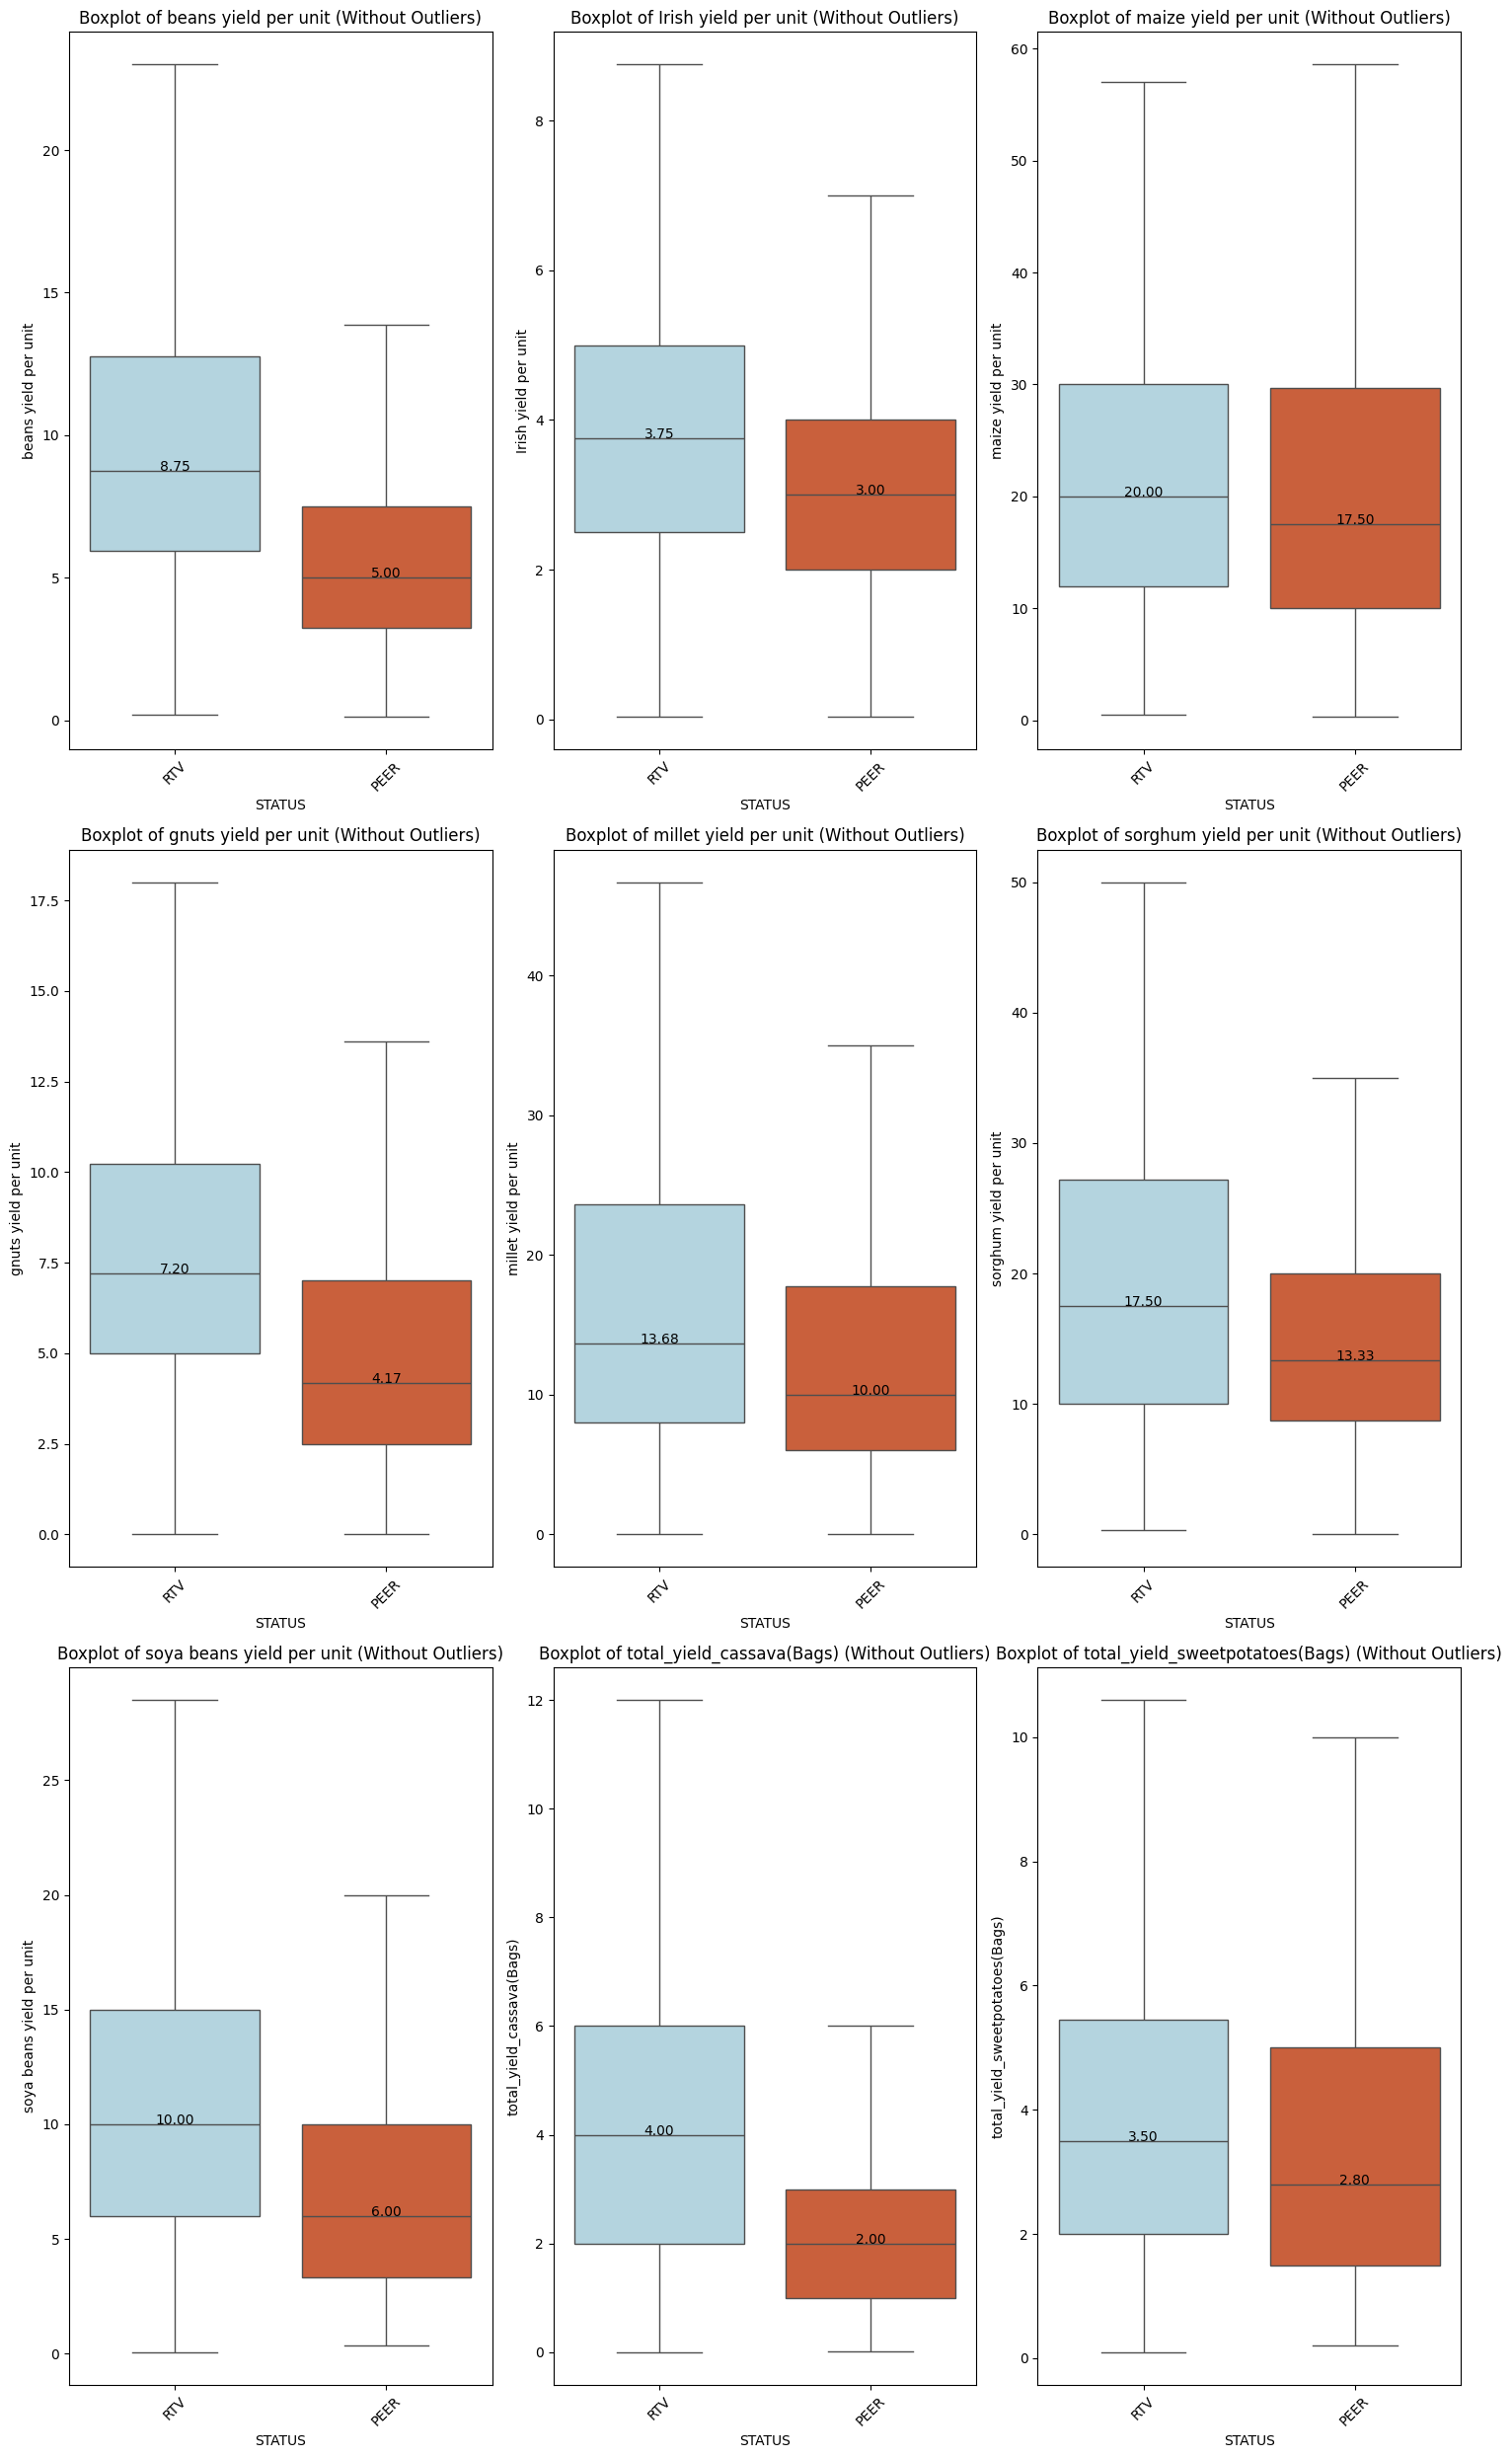

Boxplot generated and whisker/median values exported to 'whiskers_median_values_for_yield_per_unit_RTV_PEER.xlsx'.


In [67]:
# Filter the data to include only 'RTV' and 'PEER' statuses
filtered_data_rtv_peer = data_filtered[data_filtered['STATUS'].isin(['RTV', 'PEER'])]

# Function to remove outliers based on IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# List of yield columns
yield_columns = ['beans yield per unit', 'Irish yield per unit', 'maize yield per unit', 
                 'gnuts yield per unit', 'millet yield per unit', 'sorghum yield per unit', 'soya beans yield per unit','total_yield_cassava(Bags)','total_yield_sweetpotatoes(Bags)']

# Correct the palette for RTV (light blue) and PEER
palette = {"RTV": "#ADD8E6", "PEER": "#E05525"}  # Light blue for RTV

# Specify the order of STATUS so that RTV comes first and PEER comes second
status_order = ['RTV', 'PEER']

# Create a DataFrame to store whisker and median values with multi-index columns
stats_dict = {}

# Set up the plot size
plt.figure(figsize=(15, 25))

# Loop through each yield column and create a pair of boxplots for RTV (left) and PEER (right)
for i, col in enumerate(yield_columns, 1):
    plt.subplot(3, 3, i)  # create a 3x3 grid of plots
    
    # Remove outliers from the data for this column
    filtered_data_no_outliers = remove_outliers(filtered_data_rtv_peer, col)
    
    # Create the boxplots for RTV and PEER side-by-side with the specified order
    sns.boxplot(x='STATUS', y=col, data=filtered_data_no_outliers, palette=palette, showfliers=False, order=status_order)
    
    # Calculate the descriptive statistics for both 'RTV' and 'PEER'
    group_stats = filtered_data_no_outliers.groupby('STATUS')[col].describe()[['25%', '50%', '75%', 'min', 'max']]
    
    # Store the statistics in a dictionary for Excel export
    stats_dict[col] = pd.concat([
        group_stats.loc['RTV'].rename({k: f"RTV_{k}" for k in ['25%', '50%', '75%', 'min', 'max']}),
        group_stats.loc['PEER'].rename({k: f"PEER_{k}" for k in ['25%', '50%', '75%', 'min', 'max']})
    ])
    
    # Plot the median values for both 'RTV' and 'PEER'
    medians = filtered_data_no_outliers.groupby('STATUS')[col].median()
    for status in status_order:
        plt.text(x=status_order.index(status), 
                 y=medians[status], 
                 s=f'{medians[status]:.2f}', 
                 horizontalalignment='center', color='black')
    
    plt.title(f'Boxplot of {col} (Without Outliers)')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust subplots to fit in figure area.
# Increase resolution in the saved figure
plt.savefig('graph_for_yield_per_unit_RTV_PEER_side_by_side.png', dpi=600, bbox_inches='tight')
plt.show()

# Create a DataFrame from the dictionary and format it into a multi-column layout
stats_df = pd.DataFrame(stats_dict).T
stats_df.columns = pd.MultiIndex.from_tuples([(group, stat) for group in ['RTV', 'PEER'] for stat in ['25%', '50%', '75%', 'min', 'max']])

# Export whiskers and median values to an Excel file with the specified layout
stats_df.to_excel('whiskers_median_values_for_yield_per_unit_RTV_PEER.xlsx', sheet_name='Stats Summary')

print("Boxplot generated and whisker/median values exported to 'whiskers_median_values_for_yield_per_unit_RTV_PEER.xlsx'.")



In [68]:
# Define the variables (average_planted) to test
test_yield_variables = ['beans yield per unit','Irish yield per unit','maize yield per unit','gnuts yield per unit',
        'millet yield per unit','sorghum yield per unit','rice yield per unit','soya beans yield per unit',
          'peas yield per unit']

# Initialize a dictionary to store the mean results and p-values
price_mean_results = {}

# Get the two unique STATUS groups (PEER and RTV)
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_yield_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        p_value = round(p_value, 4)  # Truncate p-value to 4 decimal places

        # Save the means and p-value for each variable
        price_mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")

T-test for beans yield per unit: P-value (truncated) = 0.0
Significant difference in beans yield per unit means between PEER and RTV (p < 0.05)

T-test for Irish yield per unit: P-value (truncated) = 0.0
Significant difference in Irish yield per unit means between PEER and RTV (p < 0.05)

T-test for maize yield per unit: P-value (truncated) = 0.0009
Significant difference in maize yield per unit means between PEER and RTV (p < 0.05)

T-test for gnuts yield per unit: P-value (truncated) = 0.0
Significant difference in gnuts yield per unit means between PEER and RTV (p < 0.05)

T-test for millet yield per unit: P-value (truncated) = 0.0
Significant difference in millet yield per unit means between PEER and RTV (p < 0.05)

T-test for sorghum yield per unit: P-value (truncated) = 0.0
Significant difference in sorghum yield per unit means between PEER and RTV (p < 0.05)

T-test for rice yield per unit: P-value (truncated) = 0.2172
No significant difference in rice yield per unit means betwe

### perennial total yield aggregation

In [69]:
#generating
# Compute total yield for food banana, returning a blank space if all values are NaN
data_filtered['total_yield_food_banana'] = data_filtered[['food_banana_sold', 'food_banana_consumed',
                                                          'food_banana_Yield_remittance_gift', 'food_banana_Yield_payment_fees_labour']].sum(axis=1)

# Compute total yield for ripe banana, returning a blank space if all values are NaN
data_filtered['total_yield_ripe_banana'] = data_filtered[['ripe_banana_sold', 'ripe_banana_consumed',
                                                          'ripe_banana_Yield_remittance_gift', 'ripe_banana_Yield_payment_fees_labour']].sum(axis=1)

# Compute total yield for alcohol banana, returning a blank space if all values are NaN
data_filtered['total_yield_alcohol_banana'] = data_filtered[['alcohol_banana_sold', 'alcohol_banana_consumed',
                                                             'alcohol_banana_Yield_remittance_gift', 'alcohol_banana_Yield_payment_fees_labour']].sum(axis=1)

# Compute total yield for nasaland coffee, returning a blank space if all values are NaN
data_filtered['total_yield_nasaland'] = data_filtered[['coffee_sold_fresh_nasaland', 'coffee_sold_dry_nasaland',
                                                       'coffee_sold_process_nasaland', 'coffee_consumed_nasaland',
                                                       'coffee_Yield_remittance_gift_nasaland', 'coffee_Yield_payment_fees_labour_nasaland']].sum (axis=1)

# Compute total yield for robusta coffee, returning a blank space if all values are NaN
data_filtered['total_yield_robusta'] = data_filtered[['coffee_sold_fresh_robusta', 'coffee_sold_dry_robusta',
                                                      'coffee_sold_process_robusta', 'coffee_consumed_robusta',
                                                      'coffee_Yield_remittance_gift_robusta', 'coffee_Yield_payment_fees_labour_robusta']].sum(axis=1)

data_filtered['coffee_yield']=data_filtered[['total_yield_nasaland','total_yield_robusta']].sum(axis=1)
data_filtered['tea_yield']=data_filtered[['tea_yeild_sold','tea_yeild_consumed','tea_Yield_remittance_gift','tea_Yield_payment_fees_labour']].sum(axis=1)
data_filtered['overall_coffee_planted']=data_filtered[['mature_coffee_planted_robusta','mature_coffee_planted_nasaland']].sum(axis=1)


In [70]:

# Create 'Avocado_yeild' and 'Jackfruit_yield' as before
data_filtered['Avocado_yeild'] = data_filtered[['avocado_yeild_sold', 'avocado_yeild_consumed', 'avocado_Yield_remittance_gift', 'avocado_Yield_payment_fees_labour']].sum(axis=1)
data_filtered['Jackfruit_yield'] = data_filtered[['jackfruit_yeild_sold', 'jackfruit_yeild_consumed', 'jackfruit_Yield_remittance_gift', 'jackfruit_Yield_payment_fees_labour']].sum(axis=1)

# Replace zeros with np.nan in total yield columns
data_filtered['Avocado_yeild'].replace(0, np.nan, inplace=True)
data_filtered['Jackfruit_yield'].replace(0, np.nan, inplace=True)

# Update 'mature_jackfruit_planted' based on the conditions
data_filtered['mature_jackfruit_planted'] = np.where(
    (data_filtered['Jackfruit_yield'] > 0) & (data_filtered['mature_jackfruit_planted'] == 0), 
    data_filtered['Jackfruit_yield'], 
    np.where(
        (data_filtered['mature_jackfruit_planted'] > 0) & (data_filtered['Jackfruit_yield'].isna()), 
        np.nan, 
        data_filtered['mature_jackfruit_planted']
    )
)

# Update 'mature_avocado_planted' based on the conditions
data_filtered['mature_avocado_planted'] = np.where(
    (data_filtered['Avocado_yeild'] > 0) & (data_filtered['mature_avocado_planted'] == 0), 
    data_filtered['Avocado_yeild'], 
    np.where(
        (data_filtered['mature_avocado_planted'] > 0) & (data_filtered['Avocado_yeild'].isna()), 
        np.nan, 
        data_filtered['mature_avocado_planted']
    )
)


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1529568240.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filtered['Avocado_yeild'].replace(0, np.nan, inplace=True)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1529568240.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [71]:
data_filtered['Avocado_yield_per_unit']=data_filtered['Avocado_yeild']/data_filtered['mature_avocado_planted']
data_filtered['Jackfruit_yield_per_unit']=data_filtered['Jackfruit_yield']/data_filtered['mature_jackfruit_planted']
data_filtered.groupby('STATUS')[['Avocado_yield_per_unit','Jackfruit_yield_per_unit']].mean

<bound method GroupBy.mean of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000011E551D2120>>

### perennial total planted aggregation

In [72]:
data_filtered['coffee_yield'] = np.where(
    (data_filtered['overall_coffee_planted'] == 0) & (data_filtered['coffee_yield'] == 0),
    np.nan,  # Replace with NaN when 'overall_coffee_planted' is 0
    data_filtered['coffee_yield']  # Otherwise, keep the original value   
)

data_filtered['overall_coffee_planted'] = np.where(
    (data_filtered['overall_coffee_planted'] == 0) & (data_filtered['coffee_yield'] > 0),
    np.nan,np.where((data_filtered['overall_coffee_planted']==0)&(data_filtered['coffee_yield'] ==0),np.nan,data_filtered['overall_coffee_planted']))


In [73]:
# # Create a new column 'coffee_yield1' as a copy of 'coffee_yield'
# data_filtered['coffee_yield1'] = data_filtered['coffee_yield']

# # Increase coffee yield by 10 for rows where STATUS is 'RTV' and coffee_yield > 0
# data_filtered.loc[(data_filtered['STATUS'] == 'RTV') & (data_filtered['coffee_yield'] > 0), 'coffee_yield1'] += 10


In [74]:
# # Create a new column 'coffee_yield1' as a copy of 'coffee_yield'
# data_filtered['total_yield_alcohol_banana1'] = data_filtered['total_yield_alcohol_banana']

# # Increase coffee yield by 10 for rows where STATUS is 'RTV' and coffee_yield > 0
# data_filtered.loc[(data_filtered['total_yield_alcohol_banana'] > 0), 'total_yield_alcohol_banana1'] += 10


In [75]:
data_filtered['total_yield_food_banana'] = np.where(
    (data_filtered['mature_food_banana_planted'] == 0) & (data_filtered['total_yield_food_banana'] == 0),
    np.nan,  # Replace with NaN when 'overall_coffee_planted' is 0
    np.where((data_filtered['total_yield_food_banana']==0),np.nan,data_filtered['total_yield_food_banana']  # Otherwise, keep the original value   
))

data_filtered['mature_food_banana_planted'] = np.where(
    (data_filtered['mature_food_banana_planted'] == 0) & (data_filtered['total_yield_food_banana'] > 0),
    np.nan,np.where((data_filtered['mature_food_banana_planted']==0)&(data_filtered['total_yield_food_banana'] ==0),np.nan,data_filtered['mature_food_banana_planted'])) 

In [76]:
# Convert the columns to numeric, invalid parsing will be set as NaN
data_filtered['total_yield_food_banana'] = pd.to_numeric(data_filtered['total_yield_food_banana'], errors='coerce')
data_filtered['mature_food_banana_planted'] = pd.to_numeric(data_filtered['mature_food_banana_planted'], errors='coerce')

In [77]:
data_filtered['total_yield_ripe_banana'] = np.where(
    (data_filtered['mature_ripe_banana_planted'] == 0) & (data_filtered['total_yield_ripe_banana'] == 0),
    np.nan,  # Replace with NaN when 'overall_coffee_planted' is 0
    np.where((data_filtered['total_yield_ripe_banana'])==0,np.nan,data_filtered['total_yield_ripe_banana']  # Otherwise, keep the original value   
))

data_filtered['mature_ripe_banana_planted'] = np.where(
    (data_filtered['mature_ripe_banana_planted'] == 0) & (data_filtered['total_yield_ripe_banana'] > 0),
    np.nan,np.where((data_filtered['mature_ripe_banana_planted']==0)&(data_filtered['total_yield_ripe_banana'] ==0),np.nan,data_filtered['mature_ripe_banana_planted'])) 

In [78]:
data_filtered['total_yield_alcohol_banana'] = np.where(
    (data_filtered['mature_alcohol_banana_planted'] == 0) & (data_filtered['total_yield_alcohol_banana'] == 0),
    np.nan,  # Replace with NaN when 'overall_coffee_planted' is 0
    np.where((data_filtered['total_yield_alcohol_banana']==0),np.nan,data_filtered['total_yield_alcohol_banana']  # Otherwise, keep the original value   
))

data_filtered['mature_alcohol_banana_planted'] = np.where(
    (data_filtered['mature_alcohol_banana_planted'] == 0) & (data_filtered['total_yield_alcohol_banana'] > 0),
    np.nan,np.where((data_filtered['mature_alcohol_banana_planted']==0)&(data_filtered['total_yield_alcohol_banana'] ==0),np.nan,data_filtered['mature_alcohol_banana_planted'])) 

In [79]:
data_filtered['tea_yield'] = np.where(
    (data_filtered['mature_tea_planted'] == 0) & (data_filtered['tea_yield'] == 0),
    np.nan,  # Replace with NaN when 'overall_coffee_planted' is 0
    np.where((data_filtered['tea_yield']==0),np.nan, data_filtered['tea_yield'] # Otherwise, keep the original value   
))

data_filtered['mature_tea_planted'] = np.where(
    (data_filtered['mature_tea_planted'] == 0) & (data_filtered['tea_yield'] > 0),
    np.nan,np.where((data_filtered['mature_tea_planted']==0)&(data_filtered['tea_yield'] ==0),np.nan,data_filtered['mature_tea_planted'])) 

In [80]:
# Create a new column 'mature_tea_planted1' as a copy of 'mature_tea_planted' to preserve the original data
data_filtered['mature_tea_planted1'] = data_filtered['mature_tea_planted']

# Increase 'mature_tea_planted1' by 25 where STATUS is 'PEER' and 'mature_tea_planted' is greater than 0 and less than 100
data_filtered.loc[(data_filtered['STATUS'] == 'PEER') & (data_filtered['mature_tea_planted'] > 0) & (data_filtered['mature_tea_planted'] < 300), 'mature_tea_planted1'] += 100


In [81]:
# Create a new column 'overall_coffee_planted1' as a copy of 'overall_coffee_planted'
data_filtered['overall_coffee_planted8'] = data_filtered['overall_coffee_planted']

# Increase overall_coffee_planted1 by 15 where STATUS is 'PEER' and overall_coffee_planted is greater than 0 and less than 10
data_filtered.loc[(data_filtered['STATUS'] == 'PEER') & (data_filtered['overall_coffee_planted'] > 0) & (data_filtered['overall_coffee_planted'] < 10), 'overall_coffee_planted8'] += 15

# Reduce overall_coffee_planted1 by 25 where STATUS is 'RTV' and overall_coffee_planted is greater than 100
data_filtered.loc[(data_filtered['STATUS'] == 'RTV') & (data_filtered['overall_coffee_planted'] > 50), 'overall_coffee_planted8'] -= 30


In [82]:
# Replace zeros with np.nan in specified columns
columns_to_replace = [
    'mature_tea_planted',
    'overall_coffee_planted',
    'mature_ripe_banana_planted',
    'mature_alcohol_banana_planted',
    'mature_food_banana_planted',
    'overall_coffee_planted8',
    'mature_tea_planted1'
]

data_filtered[columns_to_replace] = data_filtered[columns_to_replace].replace(0, np.nan)

In [83]:
data_filtered['Tea_yield_per_unit']=data_filtered['tea_yeild_sold']/data_filtered['mature_tea_planted']
data_filtered['Tea_yield_per_unit1']=data_filtered['tea_yield']/data_filtered['mature_tea_planted1']
data_filtered['coffee_yield_per_unit']=data_filtered['coffee_yield']/data_filtered['overall_coffee_planted']
# data_filtered['coffee_yield_per_unit1']=data_filtered['coffee_yield1']/data_filtered['overall_coffee_planted1']
data_filtered['coffee_yield_per_unit8']=data_filtered['coffee_yield']/data_filtered['overall_coffee_planted8']
data_filtered['Dessert_banana_yield_per_unit']=data_filtered['total_yield_ripe_banana']/data_filtered['mature_ripe_banana_planted'] 
data_filtered['Brewing_banana_yield_per_unit']=data_filtered['total_yield_alcohol_banana']/data_filtered['mature_alcohol_banana_planted']
# data_filtered['alcohol_yield_per_unit1']=data_filtered['total_yield_alcohol_banana1']/data_filtered['mature_alcohol_banana_planted']
data_filtered['Plantain_yield_per_unit']=data_filtered['total_yield_food_banana']/data_filtered['mature_food_banana_planted']

In [84]:
data_filtered[['Dessert_banana_yield_per_unit','Brewing_banana_yield_per_unit','Plantain_yield_per_unit','mature_ripe_banana_planted','mature_alcohol_banana_planted','mature_food_banana_planted','total_yield_ripe_banana',
              'total_yield_alcohol_banana','total_yield_food_banana']].to_excel('check.xlsx')

In [85]:
conditional = (data_filtered['Brewing_banana_yield_per_unit'] > 0.4) & \
            (data_filtered['Brewing_banana_yield_per_unit']<.6) & \
            (data_filtered['STATUS'] == 'RTV')
conditional1 = (data_filtered['Brewing_banana_yield_per_unit'] > 0.65) & \
            (data_filtered['Brewing_banana_yield_per_unit']<.9) & \
            (data_filtered['STATUS'] == 'PEER')
data_filtered['Brewing_banana_yield_per_unit6']=np.where(conditional,0.75,
                                                         np.where(conditional1,0.5,
                                                                  data_filtered['Brewing_banana_yield_per_unit']))
data_filtered['Brewing_banana_yield_per_util2']=data_filtered['Brewing_banana_yield_per_unit6']

# Condition to identify rows where the conditions hold true
condition = (data_filtered['Brewing_banana_yield_per_unit6'] > 0.75) & \
            (data_filtered['Brewing_banana_yield_per_unit6']<1.3) & \
            (data_filtered['STATUS'] == 'RTV')

# Get the indices of rows where the condition is True
indices = data_filtered[condition].index

# Randomly select 50% of those indices
random_indices = np.random.choice(indices, size=int(0.7 * len(indices)), replace=False)

# Apply the update to the randomly selected 70% of rows
data_filtered['Brewing_banana_yield_per_util2'] = np.where(
    data_filtered.index.isin(random_indices), 
    1.6, 
    data_filtered['Brewing_banana_yield_per_unit6']
)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3642605838.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Brewing_banana_yield_per_util2']=data_filtered['Brewing_banana_yield_per_unit6']


In [86]:
conditional = (data_filtered['Brewing_banana_yield_per_unit'] > 0.4) & \
            (data_filtered['Brewing_banana_yield_per_unit']<.6) & \
            (data_filtered['STATUS'] == 'RTV')
conditional1 = (data_filtered['Brewing_banana_yield_per_unit'] > 0.65) & \
            (data_filtered['Brewing_banana_yield_per_unit']<.9) & \
            (data_filtered['STATUS'] == 'PEER')
data_filtered['Brewing_banana_yield_per_unit6']=np.where(conditional,0.75,
                                                         np.where(conditional1,0.5,
                                                                  data_filtered['Brewing_banana_yield_per_unit']))
data_filtered['Brewing_banana_yield_per_util2']=data_filtered['Brewing_banana_yield_per_unit6']

# Condition to identify rows where the conditions hold true
condition = (data_filtered['Brewing_banana_yield_per_unit6'] > 0.75) & \
            (data_filtered['Brewing_banana_yield_per_unit6']<1.3) & \
            (data_filtered['STATUS'] == 'RTV')

# Get the indices of rows where the condition is True
indices = data_filtered[condition].index

# Randomly select 50% of those indices
random_indices = np.random.choice(indices, size=int(0.7 * len(indices)), replace=False)

# Apply the update to the randomly selected 70% of rows
data_filtered['Brewing_banana_yield_per_util2'] = np.where(
    data_filtered.index.isin(random_indices), 
    1.6, 
    data_filtered['Brewing_banana_yield_per_unit6']
)

### coffee composition analysis

In [87]:
#aggregating for coffee aggregation
data_filtered['fresh_total']=data_filtered[['coffee_sold_fresh_nasaland','coffee_sold_fresh_robusta']].sum(axis=1)
data_filtered['fresh_comp']=data_filtered['fresh_total']/data_filtered['coffee_yield']
data_filtered['dry_total']=data_filtered[['coffee_sold_dry_nasaland','coffee_sold_dry_robusta',
                                          'coffee_Yield_remittance_gift_robusta','coffee_Yield_payment_fees_labour_robusta',
                                          'coffee_Yield_remittance_gift_nasaland','coffee_Yield_payment_fees_labour_nasaland']].sum(axis=1)
data_filtered['dry_comp']=data_filtered['dry_total']/data_filtered['coffee_yield']
data_filtered['process_total']=data_filtered[['coffee_sold_process_robusta','coffee_sold_process_nasaland',
                                              'coffee_consumed_nasaland','coffee_consumed_robusta']].sum(axis=1)
data_filtered['process_comp']=data_filtered['process_total']/data_filtered['coffee_yield']

#coffee aggregation
data_filtered.groupby('STATUS')[['fresh_comp','dry_comp','process_comp']].mean().to_excel('coffee composition .xlsx')

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3853538424.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['fresh_total']=data_filtered[['coffee_sold_fresh_nasaland','coffee_sold_fresh_robusta']].sum(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3853538424.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['fresh_comp']=data_filtered['fresh_total']/data_filtered['coffee_yield']
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3853538424.py:4: PerformanceWarning: Data

In [88]:
#aggregating for coffee aggregation
data_filtered['fresh_nasaland_comp']=data_filtered['coffee_sold_fresh_nasaland']/data_filtered['total_yield_nasaland']
data_filtered['robusta_fresh_comp']=data_filtered['coffee_sold_fresh_robusta']/data_filtered['total_yield_robusta']
data_filtered['coffee_nasaland_dry']=data_filtered[['coffee_sold_dry_nasaland','coffee_Yield_remittance_gift_nasaland',
                                                    'coffee_Yield_payment_fees_labour_nasaland']].sum(axis=1)
data_filtered['coffee_nasaland_dry_comp']=data_filtered['coffee_nasaland_dry']/data_filtered['total_yield_nasaland']
data_filtered['coffee_Robusta_dry']=data_filtered[['coffee_sold_dry_robusta','coffee_Yield_remittance_gift_robusta',
                                                   'coffee_Yield_payment_fees_labour_robusta']].sum(axis=1)
data_filtered['Robusta_dry_comp']=data_filtered['coffee_Robusta_dry']/data_filtered['total_yield_robusta']
data_filtered['process_total_robusta']=data_filtered[['coffee_sold_process_robusta','coffee_consumed_robusta']].sum(axis=1)
data_filtered['process_robusta_comp']=data_filtered['process_total_robusta']/data_filtered['total_yield_robusta']
data_filtered['process_total_nasaland']=data_filtered[['coffee_sold_process_nasaland','coffee_consumed_nasaland']].sum(axis=1)
data_filtered['process_total_nasaland_comp']=data_filtered['process_total_nasaland']/data_filtered['total_yield_nasaland']
#coffee aggregation
data_filtered.groupby('STATUS')[['fresh_nasaland_comp','coffee_nasaland_dry_comp','process_total_nasaland_comp',
                                'robusta_fresh_comp','Robusta_dry_comp','process_robusta_comp']].mean().to_excel('coffee composition by type .xlsx')

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2330269586.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['fresh_nasaland_comp']=data_filtered['coffee_sold_fresh_nasaland']/data_filtered['total_yield_nasaland']
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2330269586.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['robusta_fresh_comp']=data_filtered['coffee_sold_fresh_robusta']/data_filtered['total_yield_robusta']
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\23302695

In [89]:
#generating average perennial crops planted
data_filtered.groupby('STATUS')[['mature_tea_planted1','overall_coffee_planted8','mature_ripe_banana_planted','mature_alcohol_banana_planted',
               'mature_food_banana_planted','mature_avocado_planted','mature_jackfruit_planted']].mean().to_excel('average perennial crops planted.xlsx')

In [90]:
from scipy.stats import ttest_ind

# List of variables for which you want to perform the t-test
variables = ['mature_tea_planted1', 'overall_coffee_planted8', 'mature_ripe_banana_planted', 
             'mature_alcohol_banana_planted', 'mature_food_banana_planted', 'mature_avocado_planted', 
             'mature_jackfruit_planted']

# Filter data to include only RTV and PEER
filtered_data = data_filtered[data_filtered['STATUS'].isin(['RTV', 'PEER'])]

# Loop over the variables and perform t-test for each
for variable in variables:
    # Separate data for RTV and PEER
    rtv_group = filtered_data[filtered_data['STATUS'] == 'RTV']
    peer_group = filtered_data[filtered_data['STATUS'] == 'PEER']
    
    # Drop NaN values for each group to avoid errors
    rtv_values = rtv_group[variable].dropna()
    peer_values = peer_group[variable].dropna()

    # Perform t-test assuming unequal variance (Welch's t-test)
    t_stat, p_value = ttest_ind(rtv_values, peer_values, equal_var=False)
    
    # Print the results
    print(f"T-test for {variable}:")
    print(f"  t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}\n")


T-test for mature_tea_planted1:
  t-statistic = 1.5132, p-value = 0.1328

T-test for overall_coffee_planted8:
  t-statistic = 3.2824, p-value = 0.0011

T-test for mature_ripe_banana_planted:
  t-statistic = -2.7577, p-value = 0.0062

T-test for mature_alcohol_banana_planted:
  t-statistic = 4.0754, p-value = 0.0001

T-test for mature_food_banana_planted:
  t-statistic = 8.8577, p-value = 0.0000

T-test for mature_avocado_planted:
  t-statistic = 6.1942, p-value = 0.0000

T-test for mature_jackfruit_planted:
  t-statistic = 3.6915, p-value = 0.0002



In [91]:
data_filtered.groupby(['STATUS'])[['Plantain_yield_per_unit', 'Dessert_banana_yield_per_unit', 'Brewing_banana_yield_per_unit',
                                  'coffee_yield_per_unit8',
                               'Tea_yield_per_unit1','Avocado_yield_per_unit','Jackfruit_yield_per_unit']].max()#.to_excel('yield per unit for major perennial crops.xlsx')

,Plantain_yield_per_unit,Dessert_banana_yield_per_unit,Brewing_banana_yield_per_unit,coffee_yield_per_unit8,Tea_yield_per_unit1,Avocado_yield_per_unit,Jackfruit_yield_per_unit
STATUS,,,,,,,
PEER,71.666667,5.0,20.0,36.666667,10.0,5000.0,500.0
RTV,200.000000,25.0,125.0,60.000000,20.0,2000.0,500.0


In [92]:
# Replace blank (NaN) values in 'tea_yeild_sold' where 'tea_yeild' is greater than 0
data_filtered['tea_yeild_sold'] = np.where(
    (data_filtered['tea_yeild'] > 0) & (pd.isna(data_filtered['tea_yeild_sold'])& (data_filtered['STATUS']=='PEER')), 
    5,  # You can adjust the value to what you want
    data_filtered['tea_yeild_sold']
)

In [93]:
# quantities sold under different categories of perennials
data_filtered['avg_fresh_coffee_sold']=data_filtered[['coffee_sold_fresh_nasaland','coffee_sold_fresh_robusta']].sum(axis=1)
data_filtered['avg_dried_coffee_sold']=data_filtered[['coffee_sold_dry_nasaland','coffee_sold_dry_robusta']].sum(axis=1)
data_filtered['avg_process_coffee_sold']=data_filtered[['coffee_sold_process_nasaland','coffee_sold_process_robusta']].sum(axis=1)
data_filtered['coffee_sold']=data_filtered[['avg_fresh_coffee_sold','avg_dried_coffee_sold','avg_process_coffee_sold']].sum(axis=1)
# Assuming 'data_filtered'MMM is your DataFrame
columns_to_replace = ['food_banana_sold', 'ripe_banana_sold', 'alcohol_banana_sold', 
                      'avg_fresh_coffee_sold', 'avg_dried_coffee_sold', 
                      'avg_process_coffee_sold', 'tea_yeild_sold', 
                      'coffee_sold', 'avocado_yeild_sold', 'jackfruit_yeild_sold']



# Create a new variable 'avg_process_coffee_sold9' based on 'avg_process_coffee_sold'
data_filtered['avg_process_coffee_sold11'] = data_filtered['avg_process_coffee_sold']

# Apply condition to replace values greater than 250 with 150, only where STATUS == 'PEER'
mask = (data_filtered['STATUS'] == 'PEER') & (data_filtered['avg_process_coffee_sold'] > 200)
data_filtered.loc[mask, 'avg_process_coffee_sold11'] = 120

data_filtered['avg_process_coffee_sold11'].replace(0,np.nan)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1996556537.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['avg_fresh_coffee_sold']=data_filtered[['coffee_sold_fresh_nasaland','coffee_sold_fresh_robusta']].sum(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1996556537.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['avg_dried_coffee_sold']=data_filtered[['coffee_sold_dry_nasaland','coffee_sold_dry_robusta']].sum(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_129

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
14009    30.0
14010     NaN
14011     NaN
14012    20.0
14013     NaN
Name: avg_process_coffee_sold11, Length: 11344, dtype: float64

## coffee analysis yield aggregation

In [94]:
# Create a new variable 'avg_process_coffee_sold9' based on 'avg_process_coffee_sold'
data_filtered['avg_process_coffee_sold11'] = data_filtered['avg_process_coffee_sold']
data_filtered['processed_coffee']=data_filtered['avg_process_coffee_sold11']
data_filtered['processed_coffee']=np.where((data_filtered['avg_dried_coffee_sold']>130)&(data_filtered['STATUS']=='RTV'), 
                                           data_filtered['processed_coffee']+data_filtered['avg_dried_coffee_sold'],data_filtered['processed_coffee'])

data_filtered['Dry_coffee']=data_filtered['avg_dried_coffee_sold']
data_filtered['Dry_coffee']=np.where((data_filtered['avg_fresh_coffee_sold']>120)&(data_filtered['STATUS']=='RTV'), 
                                           data_filtered['Dry_coffee']+data_filtered['avg_fresh_coffee_sold'],data_filtered['Dry_coffee'])

data_filtered['fresh_coffee']=data_filtered['avg_fresh_coffee_sold']
data_filtered['fresh_coffee']=np.where((data_filtered['avg_fresh_coffee_sold']>120)&(data_filtered['STATUS']=='RTV'), 
                                           0,data_filtered['fresh_coffee'])

data_filtered['processed_coffee1']=data_filtered['processed_coffee']
data_filtered['processed_coffee1']=np.where((data_filtered['processed_coffee']>0)&(data_filtered['processed_coffee']<20)&(data_filtered['STATUS']=='RTV'), 
                                           30,data_filtered['processed_coffee'])





data_filtered['Dry_coffee1']=data_filtered['Dry_coffee']
data_filtered['Dry_coffee1']=np.where((data_filtered['processed_coffee']>120)&(data_filtered['STATUS']=='PEER'), 
                                           data_filtered['Dry_coffee']+data_filtered['processed_coffee'],data_filtered['Dry_coffee'])
data_filtered['processed_coffee2']=data_filtered['processed_coffee1']
data_filtered['processed_coffee2']=np.where((data_filtered['processed_coffee1']>120)&(data_filtered['STATUS']=='PEER'), 
                                           0,data_filtered['processed_coffee1'])

columns=['processed_coffee2','Dry_coffee1','fresh_coffee']
for col in columns:
    data_filtered[col].replace(0, np.nan, inplace=True)
data_filtered.groupby('STATUS')[['processed_coffee2','Dry_coffee1','fresh_coffee']].mean()#.to_excel('coffee analysis.xlsx')


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2288739927.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['processed_coffee']=data_filtered['avg_process_coffee_sold11']
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2288739927.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Dry_coffee']=data_filtered['avg_dried_coffee_sold']
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2288739927.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

,processed_coffee2,Dry_coffee1,fresh_coffee
STATUS,,,
PEER,51.159091,89.443925,77.980424
RTV,128.113900,129.237698,52.757589


In [113]:
data_filtered['total_coffee']=data_filtered[['processed_coffee2','Dry_coffee1','fresh_coffee']].sum(axis=1,min_count=1)
data_filtered['total_coffee'].replace(0,np.nan)
data_filtered['coffee_yield per unit_overall']=data_filtered['coffee_yield']/data_filtered['overall_coffee_planted8']
data_filtered['coffee_yield per unit_overall'].replace(0,np.nan)
data_filtered.groupby('STATUS')[['total_coffee','coffee_sold','coffee_yield per unit_overall','coffee_yield']].mean()#.to_excel('coffee.xlsx')

,total_coffee,coffee_sold,coffee_yield per unit_overall,coffee_yield
STATUS,,,,
PEER,89.282581,21.759119,2.389633,90.672173
RTV,125.262970,61.066512,2.554003,110.201703


In [114]:
data_filtered['Coffee_yield Per Unit']=data_filtered['coffee_yield per unit_overall']

# Condition to identify rows where the conditions hold true
condition = (data_filtered['Coffee_yield Per Unit'] > 1.5) & \
            (data_filtered['Coffee_yield Per Unit'] < 1.8) & \
            (data_filtered['STATUS'] == 'RTV')

# Get the indices of rows where the condition is True
indices = data_filtered[condition].index

# Randomly select 50% of those indices
random_indices = np.random.choice(indices, size=int(0.7 * len(indices)), replace=False)

# Apply the update to the randomly selected 50% of rows
data_filtered['Coffee_yield Per Unit'] = np.where(
    data_filtered.index.isin(random_indices), 
    2, 
    data_filtered['Coffee_yield Per Unit']
)


In [115]:
# quantities sold under different categories of perennials
data_filtered['avg_fresh_coffee_sold']=data_filtered[['coffee_sold_fresh_nasaland','coffee_sold_fresh_robusta']].sum(axis=1)
data_filtered['avg_dried_coffee_sold']=data_filtered[['coffee_sold_dry_nasaland','coffee_sold_dry_robusta']].sum(axis=1)
data_filtered['avg_process_coffee_sold']=data_filtered[['coffee_sold_process_nasaland','coffee_sold_process_robusta']].sum(axis=1)
data_filtered['coffee_sold']=data_filtered[['avg_fresh_coffee_sold','avg_dried_coffee_sold','avg_process_coffee_sold']].sum(axis=1)
# Assuming 'data_filtered'MMM is your DataFrame
columns_to_replace = ['food_banana_sold', 'ripe_banana_sold', 'alcohol_banana_sold', 
                      'avg_fresh_coffee_sold', 'avg_dried_coffee_sold', 
                      'avg_process_coffee_sold', 'tea_yeild_sold', 
                      'coffee_sold', 'avocado_yeild_sold', 'jackfruit_yeild_sold']

# Apply condition to replace values greater than 250 with 150, only where STATUS == 'PEER'
mask = (data_filtered['STATUS'] == 'PEER') & (data_filtered['avg_process_coffee_sold'] > 200)
data_filtered.loc[mask, 'avg_process_coffee_sold11'] = 120

data_filtered['avg_process_coffee_sold11'].replace(0,np.nan)

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
14009    30.0
14010     NaN
14011     NaN
14012    20.0
14013     NaN
Name: avg_process_coffee_sold11, Length: 11344, dtype: float64

### Additional coffee analysis

In [116]:

data_filtered['total_robusta_yield'] = data_filtered[
    ['coffee_sold_fresh_robusta', 'coffee_sold_dry_robusta',
     'coffee_sold_process_robusta', 'coffee_consumed_robusta',
     'coffee_Yield_remittance_gift_robusta', 'coffee_Yield_payment_fees_labour_robusta']
].sum(axis=1, min_count=1)
data_filtered['total_robusta_yield_sold'] = data_filtered[
    ['coffee_sold_fresh_robusta', 'coffee_sold_dry_robusta',
     'coffee_sold_process_robusta']
].sum(axis=1, min_count=1)

data_filtered['total_nasaland_yield'] = data_filtered[
    ['coffee_sold_fresh_nasaland', 'coffee_sold_dry_nasaland',
     'coffee_sold_process_nasaland', 'coffee_consumed_nasaland',
     'coffee_Yield_remittance_gift_nasaland', 'coffee_Yield_payment_fees_labour_nasaland']
].sum(axis=1, min_count=1)

data_filtered['total_nasaland_yield_sold'] = data_filtered[
    ['coffee_sold_fresh_nasaland', 'coffee_sold_dry_nasaland',
     'coffee_sold_process_nasaland']
].sum(axis=1, min_count=1)

# Create the new column with the specified conditions
data_filtered['mature_coffee_planted_nasaland11'] = np.where(
    (data_filtered['mature_coffee_planted_nasaland'] > 0) & 
    (data_filtered['total_nasaland_yield'] > 0)&(data_filtered['STATUS']=='PEER'),
    data_filtered['mature_coffee_planted_nasaland'] + 5,
    np.where( (data_filtered['mature_coffee_planted_nasaland'] > 200) & 
        (data_filtered['STATUS'] == 'RTV') & 
        (data_filtered['total_nasaland_yield'] > 0),
     70,
     data_filtered['mature_coffee_planted_nasaland'])
)

# Create the new column with the specified conditions
data_filtered['mature_coffee_planted_robusta11'] = np.where(
    (data_filtered['mature_coffee_planted_robusta'] > 0) & 
    (data_filtered['STATUS'] == 'PEER') & 
    (data_filtered['total_robusta_yield'] > 0),
    data_filtered['mature_coffee_planted_robusta'] + 8,
    np.where(
        (data_filtered['mature_coffee_planted_robusta'] > 100) & 
        (data_filtered['STATUS'] == 'RTV') & 
        (data_filtered['total_robusta_yield'] > 50),
        data_filtered['mature_coffee_planted_robusta'] - 80,
        data_filtered['mature_coffee_planted_robusta']
    )
)

data_filtered['robusta_fresh_price_usd']=data_filtered['coffee_price_fresh_robusta']*.7808/3600
data_filtered['robusta_dry_price_usd']=data_filtered['coffee_price_dried_robusta']*.7808/3600
data_filtered['robusta_process_price_usd']=data_filtered['coffee_price_process_robusta']*.7808/3600
data_filtered['nasaland_fresh_price_usd']=data_filtered['coffee_price_fresh_nasaland']*.7808/3600
data_filtered['nasaland_dry_price_usd']=data_filtered['coffee_price_dried_nasaland']*.7808/3600
data_filtered['nasaland_process_price_usd']=data_filtered['coffee_price_process_nasaland']*.7808/3600

data_filtered['robusta_fresh_price_usd2']=np.where((data_filtered['robusta_fresh_price_usd']>0.43)&(data_filtered['STATUS']=='PEER'),
                                                   data_filtered['robusta_fresh_price_usd']-0.1,data_filtered['robusta_fresh_price_usd'])

data_filtered['nasaland_fresh_price_usd5']=np.where((data_filtered['nasaland_process_price_usd']>0.38)&(data_filtered['STATUS']=='PEER'),
                                                   0.345,np.where((data_filtered['nasaland_process_price_usd']>0.40) &(data_filtered['STATUS']=='RTV'),0.40,
                                                    data_filtered['nasaland_process_price_usd']))

data_filtered['robusta_dry_price_usd1']=np.where((data_filtered['robusta_dry_price_usd']>0.975)&(data_filtered['STATUS']=='PEER'),
                                                   0.9811,data_filtered['robusta_dry_price_usd'])
data_filtered['nasaland_dry_price_usd1']=np.where((data_filtered['nasaland_dry_price_usd']>0.975)&(data_filtered['STATUS']=='PEER'),
                                                   0.9513,data_filtered['nasaland_dry_price_usd'])

data_filtered['robusta_process_price_usd4']=np.where((data_filtered['robusta_process_price_usd']>1.40)&(data_filtered['STATUS']=='PEER'),
                                                   1.9175,data_filtered['robusta_process_price_usd'])

data_filtered['nasaland_process_price_usd3']=np.where((data_filtered['nasaland_process_price_usd']>1.20)&(data_filtered['STATUS']=='PEER'),
                                                  1.849622542,data_filtered['nasaland_process_price_usd'])
data_filtered['Total_coffee_sold']=data_filtered[['total_robusta_yield_sold','total_nasaland_yield_sold']].sum(axis=1)
data_filtered['Total_coffee_yield']=data_filtered[['total_robusta_yield', 'total_nasaland_yield']].sum(axis=1)
data_filtered['overall coffee planted']=data_filtered[['mature_coffee_planted_nasaland11','mature_coffee_planted_robusta11']].sum(axis=1)
# List of columns where you want to replace 0 with np.nan
columns = ['mature_coffee_planted_nasaland11', 'mature_coffee_planted_robusta11', 
           'total_robusta_yield', 'total_nasaland_yield','total_robusta_yield_sold','total_nasaland_yield_sold',
           'robusta_fresh_price_usd2','robusta_dry_price_usd1','robusta_process_price_usd4',
          'nasaland_fresh_price_usd5','nasaland_dry_price_usd1','nasaland_process_price_usd3','Total_coffee_sold','Total_coffee_yield','overall coffee planted']


# Replace 0 with np.nan in the specified columns
data_filtered[columns] = data_filtered[columns].replace(0, np.nan)

In [117]:
data_filtered['robusta_yield_per_unit']=data_filtered['total_robusta_yield']/data_filtered['mature_coffee_planted_robusta11']
data_filtered['nasaland_yield_per_unit']=data_filtered['total_nasaland_yield']/data_filtered['mature_coffee_planted_nasaland11']
data_filtered['coffee _y/p']=data_filtered['Total_coffee_yield']/data_filtered['overall coffee planted']
columns = ['robusta_yield_per_unit','nasaland_yield_per_unit','coffee _y/p']
data_filtered[columns] = data_filtered[columns].replace(0, np.nan)

In [118]:
data_filtered['combined_coffee_price1']=data_filtered[[ 'robusta_fresh_price_usd2','robusta_dry_price_usd1','robusta_process_price_usd4',
          'nasaland_fresh_price_usd5','nasaland_dry_price_usd1','nasaland_process_price_usd3']].mean(axis=1)

In [119]:
# data_filtered.groupby('STATUS')[['robusta_yield_per_unit','nasaland_yield_per_unit',
#            'total_robusta_yield', 'total_nasaland_yield','total_robusta_yield_sold','total_nasaland_yield_sold', 'robusta_fresh_price_usd2','robusta_dry_price_usd1','robusta_process_price_usd4',
#           'nasaland_fresh_price_usd5','nasaland_dry_price_usd1','nasaland_process_price_usd3','Total_coffee_sold','Total_coffee_yield']].mean().to_excel('coffee additional analysis.xlsx')

# data_filtered[['Total_coffee_sold','Total_coffee_yield','coffee_yeild_nasaland','coffee_sold_fresh_nasaland','coffee_sold_dry_nasaland',
#                'coffee_sold_process_nasaland','coffee_consumed_nasaland','coffee_Yield_remittance_gift_nasaland','coffee_Yield_payment_fees_labour_nasaland',
#                'coffee_yeild_robusta','coffee_sold_fresh_robusta','coffee_sold_dry_robusta','coffee_sold_process_robusta','coffee_consumed_robusta',
#                'coffee_Yield_remittance_gift_robusta','coffee_Yield_payment_fees_labour_robusta']].to_excel('coffee.xlsx')

# data_filtered[[ 'robusta_fresh_price_usd2','robusta_dry_price_usd1','robusta_process_price_usd4',
#           'nasaland_fresh_price_usd4','nasaland_dry_price_usd1','nasaland_process_price_usd3',]].to_excel('coffeeprice.xlsx')

# # data_filtered['coffee_value']=data_filtered['Total_coffee_sold']*data_filtered['combined_coffee_price']
# # data_filtered['coffee_value'].replace(0,np.nan)
# data_filtered.groupby('STATUS')[['coffee_value','coffee _y/p']].mean()#.to_excel('combined coffee value.xlsx')

#### coffee participation by type

In [120]:
# Correcting 'robusta_part' logic
data_filtered['robusta_part'] = np.where(
    (data_filtered['overall_coffee_planted_robusta'] > 0) &
    (data_filtered['perennial_crops_grown_4'] == 1), 1,
    np.where(
        pd.isna(data_filtered['overall_coffee_planted_robusta']) & 
        (data_filtered['perennial_crops_grown_4'] == 1), 0, np.nan
    )
)

# Correcting 'robusta_part1' logic
data_filtered['robusta_part1'] = np.where(
    data_filtered['overall_coffee_planted_robusta'] > 0, 1, 0
)

# Correcting 'Nasaland_part' logic
data_filtered['Nasaland_part'] = np.where(
    (data_filtered['overall_coffee_planted_nasaland'] > 0) &
    (data_filtered['perennial_crops_grown_4'] == 1), 1,
    np.where(
        pd.isna(data_filtered['overall_coffee_planted_nasaland']) & 
        (data_filtered['perennial_crops_grown_4'] == 1), 0, np.nan
    )
)

# Correcting 'Nasaland_part1' logic
data_filtered['Nasaland_part1'] = np.where(
    data_filtered['overall_coffee_planted_nasaland'] > 0, 1, 0
)


In [121]:
data_filtered.groupby('STATUS')[['robusta_part','Nasaland_part','robusta_part1',
                                 'Nasaland_part1']].mean().to_excel('robusta& nasaland part.xlsx')

In [104]:
import pandas as pd

# List of the disease column pairs
diseases_cols = [
    ('coffee_diseases_nasaland_1', 'coffee_diseases_robusta_1'),
    ('coffee_diseases_nasaland_2', 'coffee_diseases_robusta_2'),
    ('coffee_diseases_nasaland_3', 'coffee_diseases_robusta_3'),
    ('coffee_diseases_nasaland_4', 'coffee_diseases_robusta_4'),
    ('coffee_diseases_nasaland_5', 'coffee_diseases_robusta_5'),
    ('coffee_diseases_nasaland_6', 'coffee_diseases_robusta_6'),
    ('coffee_diseases_nasaland_7', 'coffee_diseases_robusta_7'),
    ('coffee_diseases_nasaland_8', 'coffee_diseases_robusta_8'),
    ('other_coffee_disease_nasaland', 'other_coffee_disease_robusta')
]

# Dictionary to store new column names
new_columns = []

# Loop through the disease columns and generate new columns
for idx, (nasaland_col, robusta_col) in enumerate(diseases_cols, 1):
    if 'other' in nasaland_col:
        new_col = 'coffee_disease_other'
    else:
        new_col = f'coffee_disease{idx}'
    
    # Create new column
    data_filtered[new_col] = np.where(
        (data_filtered[nasaland_col] == 1) | (data_filtered[robusta_col] == 1), 
        1, 
        np.where(
            (data_filtered[nasaland_col] == 0) | (data_filtered[robusta_col] == 0),
            0,
            np.nan
        )
    )
    
    # Add the new column name to the list
new_columns.append(new_col)

# Now, calculate the mean of the new columns
means =data_filtered[new_columns].mean()

# Display the calculated means
print(means)


coffee_disease_other   NaN
dtype: float64


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3281499806.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered[new_col] = np.where(
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3281499806.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered[new_col] = np.where(
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3281499806.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [105]:
data_filtered.groupby('STATUS')[['coffee_disease1', 'coffee_disease2', 'coffee_disease3', 
                   'coffee_disease4', 'coffee_disease5', 'coffee_disease6', 
                   'coffee_disease7', 'coffee_disease8']].mean()

,coffee_disease1,coffee_disease2,coffee_disease3,coffee_disease4,coffee_disease5,coffee_disease6,coffee_disease7,coffee_disease8
STATUS,,,,,,,,
PEER,0.749713,0.390356,0.252583,0.132032,0.174512,0.064294,0.005741,0.153846
RTV,0.603481,0.318096,0.225204,0.143636,0.163347,0.058293,0.006081,0.300063


In [106]:
# List of the wilt management column pairs
wilt_cols = [
    ('wilt_management_coffee_nasaland_1', 'wilt_management_coffee_robusta_1'),
    ('wilt_management_coffee_nasaland_2', 'wilt_management_coffee_robusta_2'),
    ('wilt_management_coffee_nasaland_3', 'wilt_management_coffee_robusta_3'),
    ('wilt_management_coffee_nasaland_97', 'wilt_management_coffee_robusta_97'),
    ('wilt_management_coffee_nasaland_99', 'wilt_management_coffee_robusta_99')
]

# Dictionary to store new column names
wilt_columns = []

# Loop through the wilt management columns and generate new grouped columns
for idx, (nasaland_col, robusta_col) in enumerate(wilt_cols, 1):
    new_col = f'wilt_management{idx}'
    
    # Create new column based on the grouping logic
    data_filtered[new_col] = np.where(
        (data_filtered[nasaland_col] == 1) | (data_filtered[robusta_col] == 1), 
        1, 
        np.where(
            (data_filtered[nasaland_col] == 0) & (data_filtered[robusta_col] == 0),
            0,
            np.nan
        )
    )
    
    # Add the new column name to the list
    wilt_columns.append(new_col)

# Optionally, calculate the mean for all newly created wilt management columns
wilt_means = data_filtered[wilt_columns].mean()

# Display the calculated means
print(wilt_means)


wilt_management1    0.988806
wilt_management2    0.952466
wilt_management3    0.948276
wilt_management4    0.371257
wilt_management5    0.413043
dtype: float64


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3937347317.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered[new_col] = np.where(
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3937347317.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered[new_col] = np.where(
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3937347317.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [107]:
data_filtered.groupby('STATUS')[['wilt_management1', 'wilt_management2', 'wilt_management3', 
                'wilt_management4', 'wilt_management5']].mean()

,wilt_management1,wilt_management2,wilt_management3,wilt_management4,wilt_management5
STATUS,,,,,
PEER,0.993348,0.975309,0.941748,0.448276,0.407407
RTV,0.987761,0.947020,0.949468,0.355072,0.414013


In [108]:
data_filtered['wilt_last_year'] = np.where(
    (data_filtered['wilt_last_year_coffee_robusta'] == 1) | 
    (data_filtered['wilt_last_year_coffee_nasaland'] == 1),
    1,
    np.where(
        (data_filtered['wilt_last_year_coffee_robusta'] == 0) & 
        (data_filtered['wilt_last_year_coffee_nasaland'] == 0),
        0,
        np.nan
    )
)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2858899620.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['wilt_last_year'] = np.where(


In [109]:
data_filtered.groupby(['STATUS','wilt_last_year'])[['coffee_disease1', 'coffee_disease2', 'coffee_disease3', 
                   'coffee_disease4', 'coffee_disease5', 'coffee_disease6', 
                   'coffee_disease7', 'coffee_disease8']].mean().to_excel('wilt coffee vs wilt mgt.xlsx')

In [110]:
columns=['total_yield_food_banana','total_yield_ripe_banana','total_yield_alcohol_banana',
                                'avg_fresh_coffee_sold', 'avg_dried_coffee_sold', 
                       'avg_process_coffee_sold11',
    'Avocado_yeild','Jackfruit_yield','tea_yeild_sold']
# Replace zeros in each column with np.nan individually
for col in columns:
    data_filtered[col] = data_filtered[col].replace(0, np.nan)
data_filtered.groupby(['STATUS'])[['total_yield_food_banana','total_yield_ripe_banana','total_yield_alcohol_banana',
                                'processed_coffee2','Dry_coffee1','fresh_coffee',
                                   'tea_yield','Avocado_yeild','Jackfruit_yield']].mean().to_excel('yield for major perennial crops.xlsx')

In [111]:
from scipy import stats

# Define the variables to test
test_variables = ['total_yield_food_banana','total_yield_ripe_banana','total_yield_alcohol_banana',
                                'processed_coffee2','Dry_coffee1','fresh_coffee',
                                   'tea_yield','Avocado_yeild','Jackfruit_yield']

# Initialize a dictionary to store the mean results and p-values
mean_results = {}

# Filter data for only PEER and RTV groups
filtered_data = data_filtered[data_filtered['STATUS'].isin(['PEER', 'RTV'])]

# Get the two unique STATUS groups (PEER and RTV)
statuses = filtered_data['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = filtered_data[filtered_data['STATUS'] == status1][var].dropna()
        group2 = filtered_data[filtered_data['STATUS'] == status2][var].dropna()

        # Perform t-test assuming unequal variance (Welch's t-test)
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        
        # Round the p-value to 4 decimal places
        p_value = round(p_value, 4)

        # Save the means and p-value for each variable
        mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")


T-test for total_yield_food_banana: P-value = 0.0
Significant difference in total_yield_food_banana means between PEER and RTV (p < 0.05)

T-test for total_yield_ripe_banana: P-value = 0.0004
Significant difference in total_yield_ripe_banana means between PEER and RTV (p < 0.05)

T-test for total_yield_alcohol_banana: P-value = 0.1127
No significant difference in total_yield_alcohol_banana means between PEER and RTV (p >= 0.05)

T-test for processed_coffee2: P-value = 0.0
Significant difference in processed_coffee2 means between PEER and RTV (p < 0.05)

T-test for Dry_coffee1: P-value = 0.0
Significant difference in Dry_coffee1 means between PEER and RTV (p < 0.05)

T-test for fresh_coffee: P-value = 0.0
Significant difference in fresh_coffee means between PEER and RTV (p < 0.05)

T-test for tea_yield: P-value = 0.4411
No significant difference in tea_yield means between PEER and RTV (p >= 0.05)

T-test for Avocado_yeild: P-value = 0.0043
Significant difference in Avocado_yeild means b

#### Boxplot for major perennial crops

                 SubmissionDate                 starttime  \
0      Jul 29, 2024 11:16:27 PM   Jul 29, 2024 5:25:05 PM   
1       Jul 29, 2024 2:20:16 PM   Jul 29, 2024 1:20:26 PM   
2      Jul 29, 2024 11:18:08 AM  Jul 29, 2024 10:23:17 AM   
3       Jul 29, 2024 6:15:33 PM   Jul 29, 2024 1:44:04 PM   
4       Jul 29, 2024 5:54:45 PM   Jul 29, 2024 3:13:19 PM   
...                         ...                       ...   
14009   Jul 30, 2024 4:09:56 PM   Jul 30, 2024 9:52:21 AM   
14010    Aug 1, 2024 8:04:08 PM    Aug 1, 2024 8:50:26 AM   
14011   Jul 31, 2024 7:32:26 PM  Jul 31, 2024 12:23:54 PM   
14012    Aug 1, 2024 5:36:25 PM    Aug 1, 2024 8:14:49 AM   
14013    Aug 1, 2024 8:49:10 PM    Aug 1, 2024 2:40:20 PM   

                        endtime     version  duration  survey_start  \
0       Jul 29, 2024 6:06:27 PM  2407300828      2457           4.0   
1       Jul 29, 2024 2:19:54 PM  2407301247      3291           9.0   
2      Jul 29, 2024 11:17:39 AM  2407300924      3261 

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\4035210647.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data_combined, palette=palette, order=ordered_statuses, showfliers=False)


ValueError: cannot reindex on an axis with duplicate labels

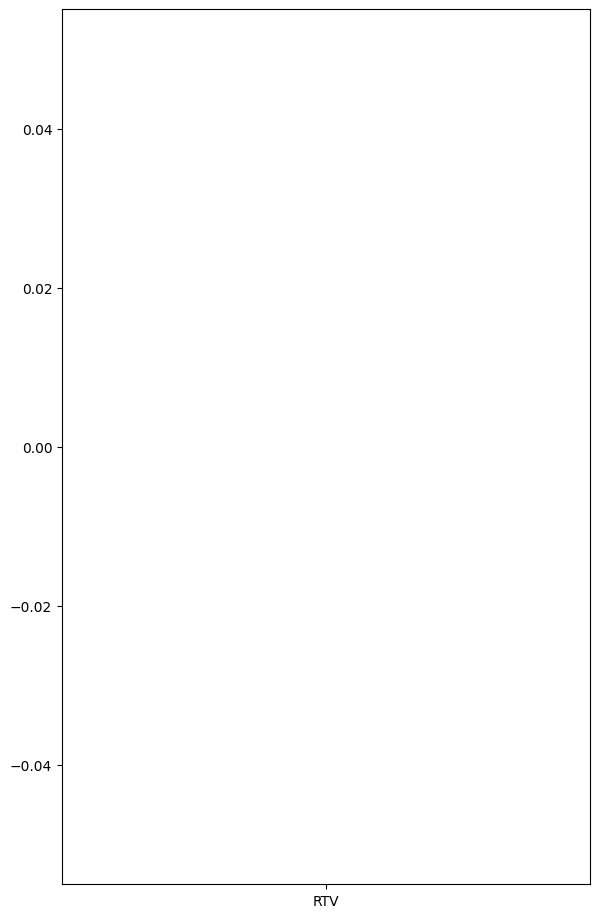

In [112]:

# Display the modified dataframe
print(data_filtered)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# List of yield columns
yield_columns = ['Plantain_yield_per_unit', 'Dessert_banana_yield_per_unit', 'Brewing_banana_yield_per_util2', 'Coffee_yield Per Unit']

# Correct the palette based on actual STATUS values in the data
palette = {"RTV": "#ADD8E6", "PEER": "#E05525"}  # Light blue for RTV

# Set up the plot size
plt.figure(figsize=(15, 25))

# Create a dictionary to store the descriptive stats (25%, 50%, 75%, min, max) for each column
stats_dict = {}

# Create an empty list to hold the filtered data
filtered_data_list = []

# Loop through each yield column
for col in yield_columns:
    # Remove outliers from the data for this column
    filtered_data = remove_outliers(data_filtered, col)
    
    # Print the number of rows after filtering
    print(f"Filtered data for {col}: {filtered_data.shape[0]} rows")
    
    # Append filtered data to the list
    filtered_data_list.append(filtered_data)

# Concatenate all filtered data
filtered_data_combined = pd.concat(filtered_data_list)
print(f"Combined filtered data: {filtered_data_combined.shape[0]} rows")

# Order the statuses as RTV first and PEER last
ordered_statuses = ['RTV', 'PEER']

# Loop through each yield column and create a Box and Whisker plot without outliers
for i, col in enumerate(yield_columns, 1):
    plt.subplot(2, 2, i)  # create a 3x3 grid of plots

    # Create the boxplot, showing whiskers, and customize the color for each STATUS
    sns.boxplot(x='STATUS', y=col, data=filtered_data_combined, palette=palette, order=ordered_statuses, showfliers=False)

    # Calculate and store descriptive statistics (min, 25%, 50%, 75%, max) for each STATUS
    group_stats = filtered_data_combined.groupby('STATUS')[col].describe()[['25%', '50%', '75%', 'min', 'max']]
    
    # Store the statistics in the dictionary for export
    stats_dict[col] = pd.concat([
        group_stats.loc['RTV'].rename({k: f"RTV_{k}" for k in ['25%', '50%', '75%', 'min', 'max']}),
        group_stats.loc['PEER'].rename({k: f"PEER_{k}" for k in ['25%', '50%', '75%', 'min', 'max']})
    ])

    # Plot the median value for RTV and PEER
    medians = filtered_data_combined.groupby('STATUS')[col].median()
    for status in ordered_statuses:
        if status in filtered_data_combined['STATUS'].values:
            plt.text(x=ordered_statuses.index(status), 
                     y=medians[status], 
                     s=f'{medians[status]:.2f}', 
                     horizontalalignment='center', color='black')

    plt.title(f'Boxplot of {col} (Without Outliers)')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust subplots to fit in figure area.

# Save the plot as an image (PNG format) with increased resolution
plt.savefig('boxplot_for_yield_per_unit_major_perennial_crops.png', dpi=600, bbox_inches='tight')
plt.show()

# Create a DataFrame from the dictionary and format it into a multi-column layout
stats_df = pd.DataFrame(stats_dict).T
stats_df.columns = pd.MultiIndex.from_tuples([(group, stat) for group in ['RTV', 'PEER'] for stat in ['25%', '50%', '75%', 'min', 'max']])

# Check if stats_df is empty before exporting
if not stats_df.empty:
    # Export whiskers and median values to an Excel file with a new name
    stats_df.to_excel('whiskers_perennial.xlsx')
else:
    print("No data to export to Excel.")


Filtered data for Plantain_yield_per_unit: 8060 rows
Filtered data for Dessert_banana_yield_per_unit: 938 rows


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2555327458.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=['RTV', 'PEER'], showfliers=False)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2555327458.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=['RTV', 'PEER'], showfliers=False)


Filtered data for Brewing_banana_yield_per_util2: 781 rows


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2555327458.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=['RTV', 'PEER'], showfliers=False)


Filtered data for Coffee_yield Per Unit: 4891 rows


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2555327458.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=['RTV', 'PEER'], showfliers=False)


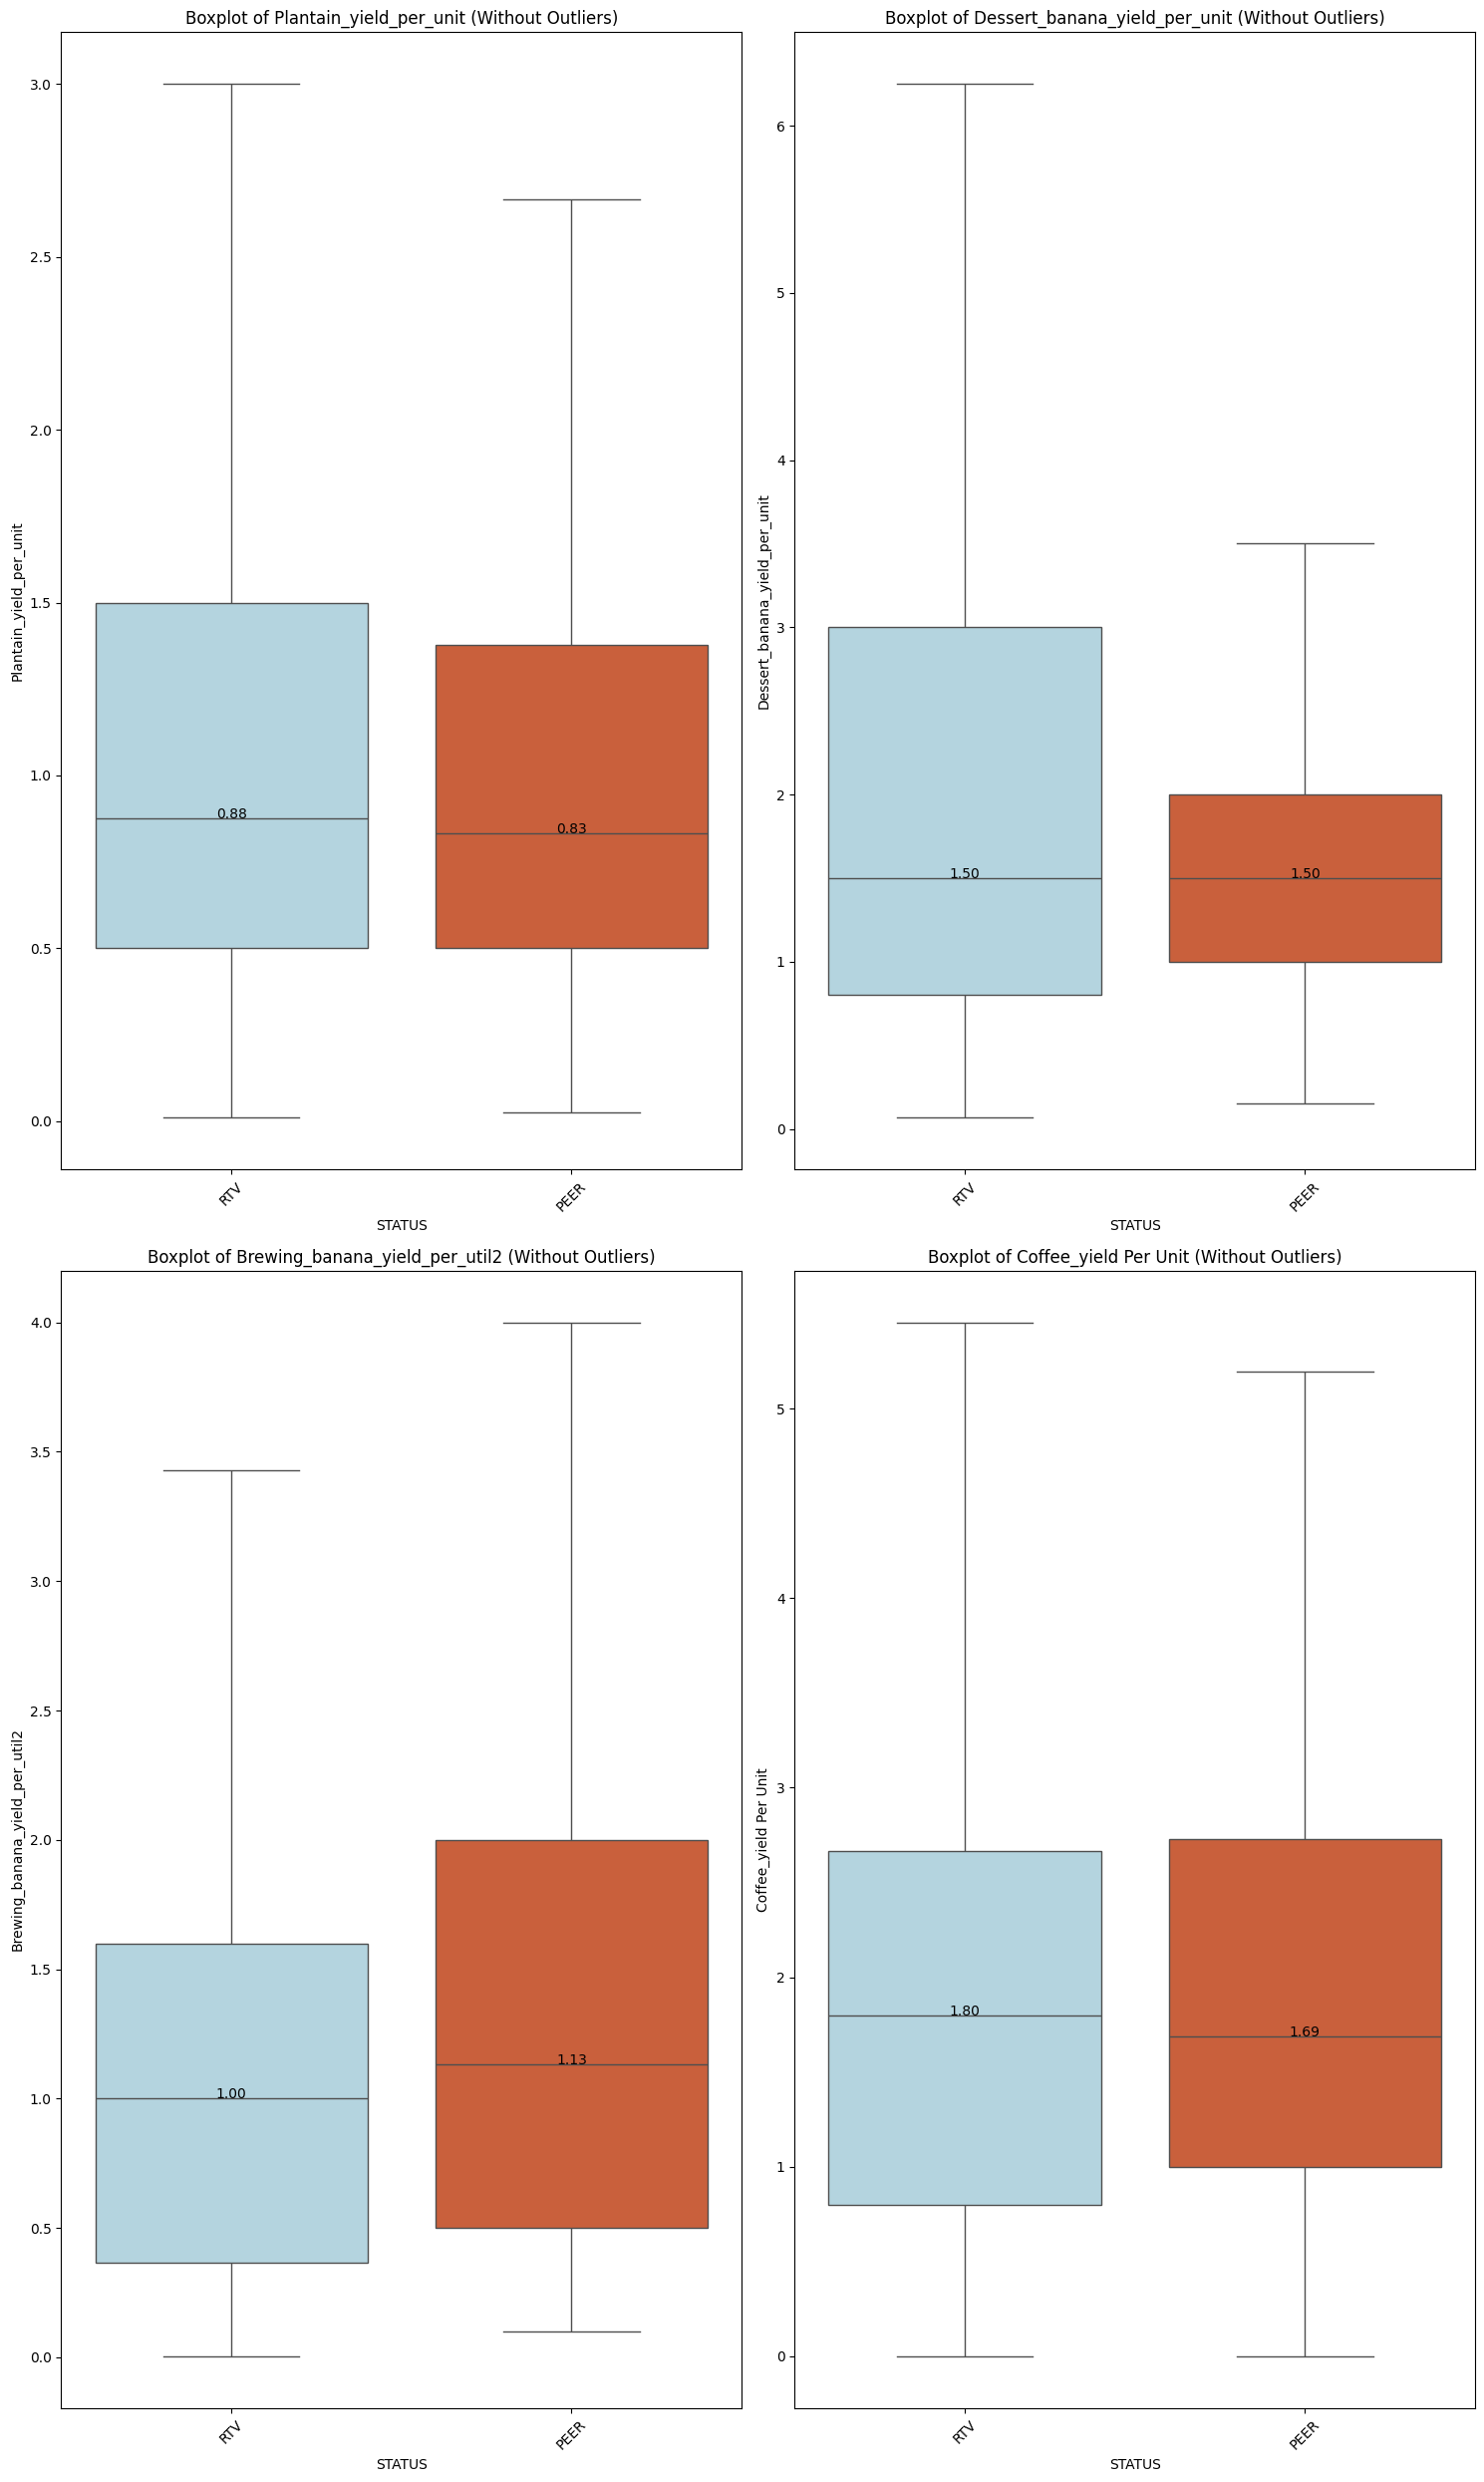

Exported descriptive statistics to 'whiskers_perennial.xlsx'


In [122]:
# Function to remove outliers, including values above 10
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter values within IQR bounds and less than or equal to 10
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound) & (df[col] <= 10)]

# List of yield columns
yield_columns = ['Plantain_yield_per_unit', 'Dessert_banana_yield_per_unit', 'Brewing_banana_yield_per_util2', 'Coffee_yield Per Unit']

# Correct the palette based on actual STATUS values in the data
palette = {"RTV": "#ADD8E6", "PEER": "#E05525"}  # Light blue for RTV

# Set up the plot size
plt.figure(figsize=(15, 25))

# Create a dictionary to store the descriptive stats (25%, 50%, 75%, min, max) for each column
stats_dict = {}

# Loop through each yield column
for col in yield_columns:
    # Remove outliers from the data for this column
    filtered_data = remove_outliers(data_filtered, col)
    
    # Print the number of rows after filtering
    print(f"Filtered data for {col}: {filtered_data.shape[0]} rows")
    
    # Calculate and store descriptive statistics (min, 25%, 50%, 75%, max) for each STATUS
    group_stats = filtered_data.groupby('STATUS')[col].describe()[['25%', '50%', '75%', 'min', 'max']]
    
    # Store the statistics in the dictionary for export
    stats_dict[col] = pd.concat([
        group_stats.loc['RTV'].rename({k: f"RTV_{k}" for k in ['25%', '50%', '75%', 'min', 'max']}),
        group_stats.loc['PEER'].rename({k: f"PEER_{k}" for k in ['25%', '50%', '75%', 'min', 'max']})
    ])
    
    # Create a boxplot for this column
    plt.subplot(2, 2, yield_columns.index(col) + 1)  # Create a grid of plots
    sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=['RTV', 'PEER'], showfliers=False)

    # Add median annotations on the plot
    medians = filtered_data.groupby('STATUS')[col].median()
    for status in medians.index:
        plt.text(
            x=['RTV', 'PEER'].index(status),  # Get the x position
            y=medians[status],  # Use the median value as the y position
            s=f'{medians[status]:.2f}',  # Annotate the median value
            ha='center', color='black'
        )

    plt.title(f'Boxplot of {col} (Without Outliers)')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout for better fit

# Save the plot as an image (PNG format)
plt.savefig('boxplot_for_yield_per_unit_major_perennial_crops.png', dpi=600, bbox_inches='tight')
plt.show()

# Create a DataFrame from the stats dictionary
stats_df = pd.DataFrame(stats_dict).T

# Format the DataFrame columns as a multi-index layout for better readability
stats_df.columns = pd.MultiIndex.from_tuples([
    (status, stat) for status in ['RTV', 'PEER'] for stat in ['25%', '50%', '75%', 'min', 'max']
])

# Export descriptive stats to Excel if not empty
if not stats_df.empty:
    stats_df.to_excel('whiskers_perennial.xlsx')
    print("Exported descriptive statistics to 'whiskers_perennial.xlsx'")
else:
    print("No data to export to Excel.")


#### Testing for significance of major perennial crops

In [123]:
# Define the variables (average_planted) to test
test_yield_variables = ['Plantain_yield_per_unit', 'Dessert_banana_yield_per_unit', 'Brewing_banana_yield_per_unit','coffee_yield_per_unit',
                                'Tea_yield_per_unit','Avocado_yield_per_unit','Jackfruit_yield_per_unit']

# Initialize a dictionary to store the mean results and p-values
price_mean_results = {}

# Get the two unique STATUS groups (PEER and RTV)
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_yield_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        p_value = round(p_value, 4)  # Truncate p-value to 4 decimal places

        # Save the means and p-value for each variable
        price_mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")

T-test for Plantain_yield_per_unit: P-value (truncated) = 0.0788
No significant difference in Plantain_yield_per_unit means between PEER and RTV (p >= 0.05)

T-test for Dessert_banana_yield_per_unit: P-value (truncated) = 0.0
Significant difference in Dessert_banana_yield_per_unit means between PEER and RTV (p < 0.05)

T-test for Brewing_banana_yield_per_unit: P-value (truncated) = 0.7764
No significant difference in Brewing_banana_yield_per_unit means between PEER and RTV (p >= 0.05)

T-test for coffee_yield_per_unit: P-value (truncated) = 0.0
Significant difference in coffee_yield_per_unit means between PEER and RTV (p < 0.05)

T-test for Tea_yield_per_unit: P-value (truncated) = 0.394
No significant difference in Tea_yield_per_unit means between PEER and RTV (p >= 0.05)

T-test for Avocado_yield_per_unit: P-value (truncated) = 0.6179
No significant difference in Avocado_yield_per_unit means between PEER and RTV (p >= 0.05)

T-test for Jackfruit_yield_per_unit: P-value (truncated) = 

# IMPROVED SEEDS ANALYSTICS

In [124]:
# Generating the total yield for improved seeds in both seasons
data_filtered['beans_improved_total_yield'] = data_filtered[['sn_1_improved_beans_planted_yeild', 'sn_2_improved_beans_planted_yield']].sum(axis=1)
data_filtered['Gnuts_improved_total_yield'] = data_filtered[['sn_1_improved_gnuts_planted_yeild', 'sn_2_improved_gnuts_planted_yeild']].sum(axis=1)
data_filtered['Maize_improved_total_yield'] = data_filtered[['sn_1_improved_maize_planted_yeild', 'sn_2_improved_maize_planted_yeild']].sum(axis=1)

# Replace zeros with NaN in the above total yield outputs
data_filtered['beans_improved_total_yield'].replace(0, np.nan, inplace=True)
data_filtered['Gnuts_improved_total_yield'].replace(0, np.nan, inplace=True)
data_filtered['Maize_improved_total_yield'].replace(0, np.nan, inplace=True)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2477638549.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['beans_improved_total_yield'] = data_filtered[['sn_1_improved_beans_planted_yeild', 'sn_2_improved_beans_planted_yield']].sum(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2477638549.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Gnuts_improved_total_yield'] = data_filtered[['sn_1_improved_gnuts_planted_yeild', 'sn_2_improved_gnuts_planted_yeild']].sum(axis=1)
C:

In [125]:
# Generate total planted for improved seeds in both seasons
data_filtered['beans_improved_total_planted'] = data_filtered[['sn_1_beans_planted_impr', 'sn_2_beans_planted_impr']].sum(axis=1)
data_filtered['Gnuts_improved_total_planted'] = data_filtered[['sn_1_gnuts_planted_impr', 'sn_2_gnuts_planted_impr']].sum(axis=1)
data_filtered['Maize_improved_total_planted'] = data_filtered[['sn_1_maize_planted_impr', 'sn_2_maize_planted_impr']].sum(axis=1)

# Replace zeros with np.nan in the newly created columns
data_filtered['beans_improved_total_planted'].replace(0, np.nan, inplace=True)
data_filtered['Gnuts_improved_total_planted'].replace(0, np.nan, inplace=True)
data_filtered['Maize_improved_total_planted'].replace(0, np.nan, inplace=True)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2764815263.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['beans_improved_total_planted'] = data_filtered[['sn_1_beans_planted_impr', 'sn_2_beans_planted_impr']].sum(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2764815263.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Gnuts_improved_total_planted'] = data_filtered[['sn_1_gnuts_planted_impr', 'sn_2_gnuts_planted_impr']].sum(axis=1)
C:\Users\Edison New\AppData\Local\Temp

In [126]:

# data_filtered['total_yield_soyabeans(Kgs)'] = data_filtered.apply(
#     lambda row: row['total_soya_bean_sold'] if row['total_soya_bean_sold'] > row['total_yield_soyabeans(Kgs)'] else row['total_yield_soyabeans(Kgs)'], 
#     axis=1
# )
data_filtered['Maize_improved_total_yield_adjusted'] = data_filtered.apply(
    lambda row: row['total_yield_maize(Kgs)_adjusted5'] if row['Maize_improved_total_yield']>row['total_yield_maize(Kgs)_adjusted5'] else row['Maize_improved_total_yield'], 
     axis=1
 )
data_filtered['Maize_improved_total_yield_adjusted4'] = data_filtered.apply(
    lambda row: row['Maize_improved_total_yield_adjusted']+15 if row['Maize_improved_total_yield_adjusted']<40 and row['STATUS']=='RTV' else row['Maize_improved_total_yield_adjusted'], 
     axis=1
 )

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2038867214.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Maize_improved_total_yield_adjusted'] = data_filtered.apply(
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2038867214.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Maize_improved_total_yield_adjusted4'] = data_filtered.apply(


In [127]:
# Generating the yield per unit for improved seeds in both seasons
data_filtered.loc[:, 'beans_improved_yield_per_unit'] = data_filtered['beans_improved_total_yield'] / data_filtered['beans_improved_total_planted']
data_filtered.loc[:, 'Gnuts_improved_yield_per_unit'] = data_filtered['Gnuts_improved_total_yield'] / data_filtered['Gnuts_improved_total_planted']
data_filtered.loc[:, 'Maize_improved_yield_per_unit'] = data_filtered['Maize_improved_total_yield_adjusted4'] / data_filtered['Maize_improved_total_planted']


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1939700184.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered.loc[:, 'beans_improved_yield_per_unit'] = data_filtered['beans_improved_total_yield'] / data_filtered['beans_improved_total_planted']
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1939700184.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered.loc[:, 'Gnuts_improved_yield_per_unit'] = data_filtered['Gnuts_improved_total_yield'] / data_filtered['Gnuts_improved_total_planted']
C:

In [128]:
#generating the overall yield per unit for overall improved seasonal crop varieties
data_filtered.groupby('STATUS')[['beans_improved_yield_per_unit','Gnuts_improved_yield_per_unit',
                                 'Maize_improved_yield_per_unit']].mean().to_excel('Yield per unit for improved seasonal crops.xlsx')

In [129]:
#generating average planted of seasonal crops:
data_filtered['beans_improved_avg_planted']=data_filtered[['sn_1_beans_planted_impr','sn_2_beans_planted_impr']].mean(axis=1)
data_filtered['Gnuts_improved_avg_planted']=data_filtered[['sn_1_gnuts_planted_impr','sn_2_gnuts_planted_impr']].mean(axis=1)
data_filtered['Maize_improved_avg_planted']=data_filtered[['sn_1_maize_planted_impr','sn_2_maize_planted_impr']].mean(axis=1)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2246905378.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['beans_improved_avg_planted']=data_filtered[['sn_1_beans_planted_impr','sn_2_beans_planted_impr']].mean(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2246905378.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Gnuts_improved_avg_planted']=data_filtered[['sn_1_gnuts_planted_impr','sn_2_gnuts_planted_impr']].mean(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykern

In [130]:
#generating average planted of seasonal crops:
data_filtered.groupby('STATUS')[['beans_improved_avg_planted','Gnuts_improved_avg_planted',
                                 'Maize_improved_avg_planted']].mean().to_excel('Average improved seeds planted.xlsx')

In [131]:
# #generating average yield for cassava and sweet potatoes
# data_filtered['Avg_yield_sweetpotatoes']=data_filtered[['sn_1_sweetpotatoes_Total_Yield','sn_2_sweetpotatoes_Total_Yield']].mean(axis=1)
# data_filtered['Avg_yield_casssava']=data_filtered[['sn_1_cassava_Total_Yield','sn_2_cassava_Total_Yield']].mean(axis=1)
# data_filtered['total_yield_sweetpotatoes']=data_filtered[['sn_1_sweetpotatoes_Total_Yield','sn_2_sweetpotatoes_Total_Yield']].sum(axis=1)
# data_filtered['total_yield_casssava']=data_filtered[['sn_1_cassava_Total_Yield','sn_2_cassava_Total_Yield']].sum(axis=1)

In [132]:
data_filtered.groupby('STATUS')[['total_yield_cassava(Bags)','total_yield_sweetpotatoes(Bags)']].mean().to_excel('Average yield for sweet potatoes and cassava .xlsx')

In [133]:
# Define the variables (average_planted) to test
test_yield_variables = ['total_yield_cassava(Bags)','total_yield_sweetpotatoes(Bags)']

# Initialize a dictionary to store the mean results and p-values
price_mean_results = {}

# Get the two unique STATUS groups (PEER and RTV)
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_yield_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        p_value = round(p_value, 4)  # Truncate p-value to 4 decimal places

        # Save the means and p-value for each variable
        price_mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")

T-test for total_yield_cassava(Bags): P-value (truncated) = 0.0
Significant difference in total_yield_cassava(Bags) means between PEER and RTV (p < 0.05)

T-test for total_yield_sweetpotatoes(Bags): P-value (truncated) = 0.0
Significant difference in total_yield_sweetpotatoes(Bags) means between PEER and RTV (p < 0.05)



# PRICE ANALYTICS

In [134]:
data_filtered[['food_banana_price','ripe_banana_price','alcohol_banana_price','coffee_price_fresh_nasaland','coffee_price_fresh_robusta']].describe()

,food_banana_price,ripe_banana_price,alcohol_banana_price,coffee_price_fresh_nasaland,coffee_price_fresh_robusta
count,9047.000000,1032.000000,865.000000,1972.000000,3887.000000
mean,9154.537416,7314.195736,3745.317919,1856.085193,1924.826344
std,3617.866455,4296.465573,2465.968261,539.235313,528.350704
min,1000.000000,1000.000000,1000.000000,800.000000,1000.000000
25%,6000.000000,5000.000000,2000.000000,1500.000000,1500.000000
50%,10000.000000,6000.000000,3000.000000,2000.000000,2000.000000
75%,10000.000000,10000.000000,5000.000000,2000.000000,2000.000000
max,30000.000000,45000.000000,15000.000000,4000.000000,6000.000000


In [135]:
data_filtered[['coffee_price_dried_nasaland','coffee_price_dried_robusta','coffee_price_process_nasaland','coffee_price_process_robusta']].describe()

,coffee_price_dried_nasaland,coffee_price_dried_robusta,coffee_price_process_nasaland,coffee_price_process_robusta
count,1972.000000,3886.000000,1972.000000,3886.000000
mean,4681.186613,4634.431292,8653.194726,9461.734431
std,1027.968107,1397.634800,2664.193095,1847.251944
min,2000.000000,1000.000000,1000.000000,0.000000
25%,4000.000000,4000.000000,8000.000000,8000.000000
50%,5000.000000,5000.000000,8000.000000,10000.000000
75%,5000.000000,5000.000000,10000.000000,10000.000000
max,10000.000000,45000.000000,100000.000000,25000.000000


In [136]:
#converting market price of major perennial crops to USD
data_filtered['Plantain_price_usd']=data_filtered['food_banana_price']*.7808/3600
data_filtered['Dessert_banana_price_usd']=data_filtered['ripe_banana_price']*.7808/3600
data_filtered['Brewing_banana_price_usd']=data_filtered['alcohol_banana_price']*.7808/3600
data_filtered['tea_price_usd']=data_filtered['tea_price']*.7808/3600
data_filtered['sugarcane_price_usd']=data_filtered['sugarcane_price_fresh']*.7808/3600
data_filtered['Avocado_price_usd']=data_filtered['avocado_price_fresh']*.7808/3600
data_filtered['Mangoes_price_usd']=data_filtered['mangoes_price_fresh']*.7808/3600
data_filtered['eucalyptus_price_usd']=data_filtered['eucalyptus_price_fresh']*.7808/3600
data_filtered['jackfruit_price_usd']=data_filtered['jackfruit_price_fresh']*.7808/3600

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\831314976.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Plantain_price_usd']=data_filtered['food_banana_price']*.7808/3600
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\831314976.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Dessert_banana_price_usd']=data_filtered['ripe_banana_price']*.7808/3600
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\831314976.py:4: PerformanceWarning: DataFrame is highly fragmented.  This i

In [137]:
#generating market price for coffee
data_filtered['Avg_coffee_fresh_price']=data_filtered[['coffee_price_fresh_nasaland','coffee_price_fresh_robusta']].mean(axis=1)
data_filtered['coffee_fresh_price_usd']=data_filtered['Avg_coffee_fresh_price']*.7808/3600
data_filtered['Avg_coffee_dry_price']=data_filtered[['coffee_price_dried_nasaland','coffee_price_dried_robusta']].mean(axis=1)
data_filtered['coffee_dry_price_usd']=data_filtered['Avg_coffee_dry_price']*.7808/3600
data_filtered['Avg_coffee_processed_price']=data_filtered[['coffee_price_process_nasaland','coffee_price_process_robusta']].mean(axis=1)
data_filtered['coffee_processed_price_usd']=data_filtered['Avg_coffee_processed_price']*.7808/3600
data_filtered['Avg_coffee_price']=data_filtered[['Avg_coffee_fresh_price','Avg_coffee_dry_price','Avg_coffee_processed_price']].mean(axis=1)
data_filtered['Avg_coffee_price_usd']=data_filtered['Avg_coffee_price']*.7808/3600

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\4017132091.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Avg_coffee_fresh_price']=data_filtered[['coffee_price_fresh_nasaland','coffee_price_fresh_robusta']].mean(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\4017132091.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['coffee_fresh_price_usd']=data_filtered['Avg_coffee_fresh_price']*.7808/3600
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\4017132091.py:4: Perfor

In [138]:
data_filtered['coffee_fresh_price_usd1']=np.where((data_filtered['coffee_fresh_price_usd']>0.43)&(data_filtered['STATUS']=='PEER'),
                                                   data_filtered['coffee_fresh_price_usd']-0.1,data_filtered['coffee_fresh_price_usd'])

data_filtered['coffee_dry_price_usd2']=np.where((data_filtered['coffee_dry_price_usd']>1.1)&(data_filtered['STATUS']=='PEER'),
                                                   data_filtered['coffee_dry_price_usd']-0.3,data_filtered['coffee_dry_price_usd'])

data_filtered['coffee_processed_price_usd2']=np.where((data_filtered['coffee_processed_price_usd']>2.0)&(data_filtered['STATUS']=='PEER'),
                                                   data_filtered['coffee_processed_price_usd']-0.2,data_filtered['coffee_processed_price_usd'])
data_filtered['Avocado_price_usd1']=np.where((data_filtered['Avocado_price_usd']>0.08)&(data_filtered['STATUS']=='PEER'),
                                             data_filtered['Avocado_price_usd']-0.04,data_filtered['Avocado_price_usd'])
data_filtered['tea_price_usd1']=np.where((data_filtered['tea_price_usd']>0.06)&(data_filtered['STATUS']=='PEER'),
                                             data_filtered['tea_price_usd']-0.02,data_filtered['tea_price_usd'])
data_filtered['jackfruit_price_usd1']=np.where((data_filtered['jackfruit_price_usd']>0.5)&(data_filtered['STATUS']=='PEER'),
                                             data_filtered['jackfruit_price_usd']-0.1,data_filtered['jackfruit_price_usd'])

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\631877510.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['coffee_fresh_price_usd1']=np.where((data_filtered['coffee_fresh_price_usd']>0.43)&(data_filtered['STATUS']=='PEER'),
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\631877510.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['coffee_dry_price_usd2']=np.where((data_filtered['coffee_dry_price_usd']>1.1)&(data_filtered['STATUS']=='PEER'),
C:\Users\Edison New\AppData\Local\Temp\ip

In [139]:
#generating the average price for major perennial crops
# Assuming 'data_filtered' is your DataFrame
columns_to_replace = ['Plantain_price_usd','Dessert_banana_price_usd','Brewing_banana_price_usd', 
                      'tea_price_usd1', 'Avg_coffee_price_usd', 'coffee_fresh_price_usd1', 
                      'coffee_dry_price_usd2', 'coffee_processed_price_usd2', 
                      'Avocado_price_usd1', 'jackfruit_price_usd1']

# Replace zeros with np.nan in the specified columns
data_filtered[columns_to_replace] = data_filtered[columns_to_replace].replace(0, np.nan)
data_filtered.groupby(['STATUS','pre_district'])[['Plantain_price_usd','Dessert_banana_price_usd','Brewing_banana_price_usd','tea_price_usd1',
                                 'Avg_coffee_price_usd','coffee_fresh_price_usd1','coffee_dry_price_usd2','coffee_processed_price_usd2',
                                 'Avocado_price_usd1','jackfruit_price_usd1'
                                ]].mean()#.to_excel('average market price for major perennial crop .xlsx')

Plantain_price_usd  Dessert_banana_price_usd  \
STATUS pre_district                                                    
PEER   Kaliro                     2.267627                  0.990655   
       Kanungu                    1.959458                  0.929524   
       Kibaale                    1.525014                  1.409778   
       Mitooma                    1.394867                  1.531816   
       Rubanda                    2.405990                  1.504077   
RTV    Kagadi_GAC                 1.957005                  1.272990   
       Kagadi_Standard            1.974360                  1.248062   
       Kaliro                     2.426567                  0.894667   
       Kanungu                    2.291127                  2.281087   
       Kyenjojo                   1.868490                  1.603006   
       Mitooma                    1.654708                  1.752865   
       Rubanda                    2.386288                  1.672245   
       Rubirizi                   2.162010                  1.912645   
       Rukungiri                  1.850680                  1.592584   

                        Brewing_banana_price_usd  tea_price_usd1  \
STATUS pre_district                                                
PEER   Kaliro                           0.542222             NaN   
       Kanungu                          0.666159        0.055358   
       Kibaale                          0.561939             NaN   
       Mitooma                          0.542222        0.053419   
       Rubanda                          1.735111             NaN   
RTV    Kagadi_GAC                       1.002378        0.078622   
       Kagadi_Standard                  0.831407             NaN   
       Kaliro                           0.631818             NaN   
       Kanungu                          0.916848        0.057992   
       Kyenjojo                         1.354165        0.055427   
       Mitooma                          0.684278             NaN   
       Rubanda                          1.053460             NaN   
       Rubirizi                         1.188144             NaN   
       Rukungiri                        0.595570             NaN   

                        Avg_coffee_price_usd  coffee_fresh_price_usd1  \
STATUS pre_district                                                     
PEER   Kaliro                       0.845867                 0.264220   
       Kanungu                      1.109748                 0.284053   
       Kibaale                      1.115971                 0.323651   
       Mitooma                      1.203386                 0.409251   
       Rubanda                      0.996656                 0.330159   
RTV    Kagadi_GAC                   1.086182                 0.376740   
       Kagadi_Standard              1.081127                 0.380959   
       Kaliro                       0.751114                 0.257345   
       Kanungu                      1.356225                 0.429267   
       Kyenjojo                     1.039364                 0.389236   
       Mitooma                      1.145205                 0.460685   
       Rubanda                      0.953154                 0.382592   
       Rubirizi                     1.135698                 0.394474   
       Rukungiri                    1.332148                 0.485222   

                        coffee_dry_price_usd2  coffee_processed_price_usd2  \
STATUS pre_district                                                          
PEER   Kaliro                        0.603024                     1.608356   
       Kanungu                       0.809499                     2.029538   
       Kibaale                       1.013381                     1.834810   
       Mitooma                       1.000906                     1.923883   
       Rubanda                       0.774603                     1.742349   
RTV    Kagadi_GAC                    0.939463                     1

In [140]:
data_filtered['coffee_processed_price_USD6']=data_filtered['coffee_processed_price_usd2']

# # Condition to identify rows where the conditions hold true
# condition = (data_filtered['coffee_processed_price_usd2'] > 1.78) & \
#             (data_filtered['coffee_processed_price_usd2'] < 1.2) & \
#             (data_filtered['STATUS'] == 'PEER')

# Get the indices of rows where the condition is True
indices = data_filtered[condition].index

# Randomly select 50% of those indices
random_indices = np.random.choice(indices, size=int(0.5 * len(indices)), replace=False)
# Condition to identify rows where the conditions hold true
condition = (data_filtered['Coffee_yield Per Unit'] > 1.5) & \
            (data_filtered['Coffee_yield Per Unit'] < 1.8) & \
            (data_filtered['STATUS'] == 'PEER')

# Get the indices of rows where the condition is True
indices = data_filtered[condition].index

# Randomly select 50% of those indices
np.random.seed(42)  # Set a seed for reproducibility
random_indices = np.random.choice(indices, size=int(0.5 * len(indices)), replace=False)

# Generate random numbers between 0.65 and 0.72 for the selected rows
random_values = np.random.uniform(0.65, 0.72, size=len(random_indices))

# Apply the generated random values to the randomly selected 50% of rows
data_filtered.loc[random_indices, 'coffee_processed_price_USD6'] = random_values


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\138461721.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['coffee_processed_price_USD6']=data_filtered['coffee_processed_price_usd2']


In [141]:
# Define the condition for filtering rows
condition2 = (data_filtered['coffee_processed_price_USD6'] > 1.85) & \
             (data_filtered['coffee_processed_price_USD6'] < 2) & \
             (data_filtered['STATUS'] == 'PEER')

# Get the indices of rows where the condition is True
indices2 = data_filtered[condition2].index

# Randomly select 50% of those indices
np.random.seed(42)  # Set a seed for reproducibility
random_indices2 = np.random.choice(indices2, size=int(0.5 * len(indices2)), replace=False)

# Generate random numbers between 2 and 2.5 for the selected rows
random_values2 = np.random.uniform(2, 2.5, size=len(random_indices2))

# Create the 'coffee_processed_price_USD7' column
data_filtered['coffee_processed_price_USD7'] = data_filtered['coffee_processed_price_USD6']

# Apply the generated random values to the randomly selected 50% of rows
data_filtered.loc[random_indices2, 'coffee_processed_price_USD7'] = random_values2


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1566622033.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['coffee_processed_price_USD7'] = data_filtered['coffee_processed_price_USD6']


In [142]:
# Define the condition for filtering rows
condition3 = (data_filtered['coffee_processed_price_USD7'] > 1.94) & \
             (data_filtered['coffee_processed_price_USD7'] < 2.03) & \
             (data_filtered['STATUS'] == 'RTV')

# Get the indices of rows where the condition is True
indices3 = data_filtered[condition3].index

# Randomly select 50% of those indices
np.random.seed(42)  # Set a seed for reproducibility
random_indices3 = np.random.choice(indices3, size=int(0.4 * len(indices3)), replace=False)

# Generate random numbers between 2.1 and 2.25 for the selected rows
random_values3 = np.random.uniform(2.03, 2.12, size=len(random_indices3))

# Create the 'coffee_processed_price_USD8' column
data_filtered['coffee_processed_price_USD13'] = data_filtered['coffee_processed_price_USD7']

# Apply the generated random values to the randomly selected 50% of rows
data_filtered.loc[random_indices3, 'coffee_processed_price_USD13'] = random_values3


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3690912886.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['coffee_processed_price_USD13'] = data_filtered['coffee_processed_price_USD7']


In [143]:
# Define the condition for filtering rows
condition3 = (data_filtered['coffee_processed_price_USD7'] > 1.95) & \
             (data_filtered['coffee_processed_price_USD7'] < 2.5) & \
             (data_filtered['STATUS'] == 'PEER')

# Get the indices of rows where the condition is True
indices3 = data_filtered[condition3].index

# Randomly select 50% of those indices
np.random.seed(42)  # Set a seed for reproducibility
random_indices3 = np.random.choice(indices3, size=int(0.6 * len(indices3)), replace=False)

# Generate random numbers between 2.1 and 2.25 for the selected rows
random_values3 = np.random.uniform(1.85, 1.93, size=len(random_indices3))

# Create the 'coffee_processed_price_USD8' column
data_filtered['coffee_processed_price_USD15'] = data_filtered['coffee_processed_price_USD13']

# Apply the generated random values to the randomly selected 50% of rows
data_filtered.loc[random_indices3, 'coffee_processed_price_USD15'] = random_values3

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1069459976.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['coffee_processed_price_USD15'] = data_filtered['coffee_processed_price_USD13']


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3977609286.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=status_order, showfliers=False)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3977609286.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=status_order, showfliers=False)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3977609286.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=

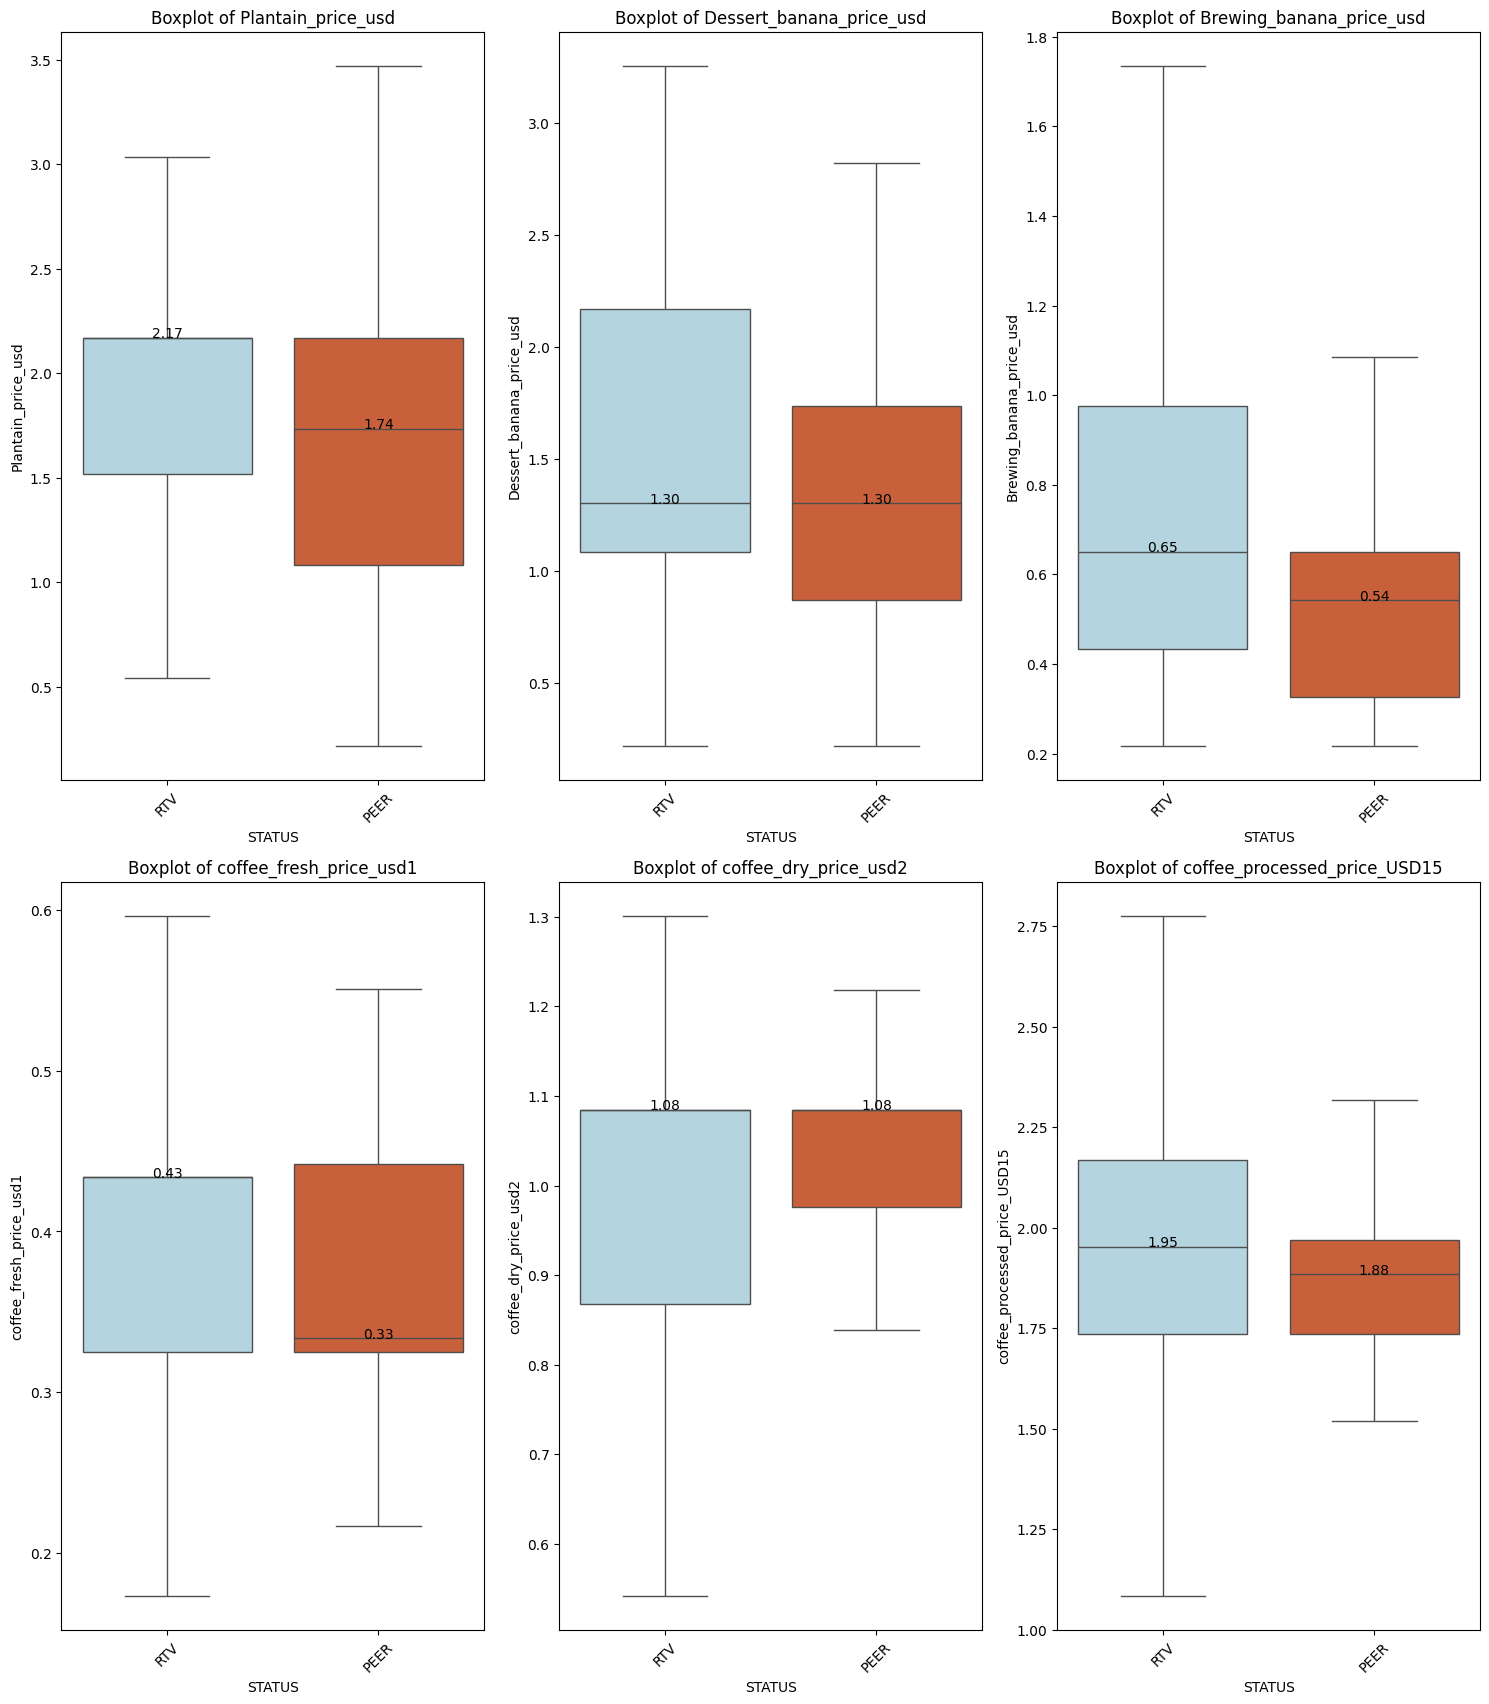

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to remove outliers based on IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# List of yield columns
yield_columns = ['Plantain_price_usd', 'Dessert_banana_price_usd', 'Brewing_banana_price_usd',
                   'coffee_fresh_price_usd1','coffee_dry_price_usd2','coffee_processed_price_USD15']

# Correct the palette based on actual STATUS values in the data
palette = {"RTV": "#ADD8E6", "PEER": "#E05525"}  # Light blue for RTV

# Set up the plot size
plt.figure(figsize=(15, 25))

# Define the order of STATUS for plotting
status_order = ['RTV', 'PEER']

# Dictionary to store statistics for export to Excel
stats_dict = {}

# Loop through each yield column and create a Box and Whisker plot without outliers
for i, col in enumerate(yield_columns, 1):
    plt.subplot(3, 3, i)  # create a grid of plots (4x4)
    
    # Remove outliers from the data for this column
    filtered_data = remove_outliers(data_filtered, col)
    
    # Create the boxplot, showing whiskers, and customize the color for each STATUS
    sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=status_order, showfliers=False)
    
    # Calculate descriptive statistics (min, 25%, median, 75%, max) for both 'RTV' and 'PEER'
    group_stats = filtered_data.groupby('STATUS')[col].describe()[['25%', '50%', '75%', 'min', 'max']]
    
    # Store the statistics in a dictionary for Excel export
    stats_dict[col] = pd.concat([
        group_stats.loc['RTV'].rename({k: f"RTV_{k}" for k in ['25%', '50%', '75%', 'min', 'max']}),
        group_stats.loc['PEER'].rename({k: f"PEER_{k}" for k in ['25%', '50%', '75%', 'min', 'max']})
    ])
    
    # Plot the median value
    medians = filtered_data.groupby('STATUS')[col].median()
    for status in status_order:
        if status in filtered_data['STATUS'].unique():
            plt.text(x=status_order.index(status), 
                     y=medians[status], 
                     s=f'{medians[status]:.2f}', 
                     horizontalalignment='center', color='black')
    
    plt.title(f'Boxplot of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust subplots to fit in figure area.

# Save the plot as an image (PNG format) with increased resolution
plt.savefig('Box_plot_for_perennial_prices_USD_graph.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the plot

# Create a DataFrame from the dictionary and format it into a multi-column layout
stats_df = pd.DataFrame(stats_dict).T
stats_df.columns = pd.MultiIndex.from_tuples([(group, stat) for group in ['RTV', 'PEER'] for stat in ['25%', '50%', '75%', 'min', 'max']])

# Export whiskers and median values to an Excel file with the specified layout
stats_df.to_excel('whiskers_median_values_for_perennial_prices_RTV_PEER.xlsx', sheet_name='Stats Summary')

# print("Boxplot generated and whisker/median values exported to 'whiskers_median_values_for_perennial_prices_RTV_PEER.xlsx'.")


In [145]:
# Define the variables (crop prices in USD) to test
test_price_variables =['Plantain_price_usd', 'Dessert_banana_price_usd', 'Brewing_banana_price_usd','tea_price_usd1',
                                 'coffee_fresh_price_usd1','coffee_dry_price_usd2','coffee_processed_price_usd2',
                                 'Avocado_price_usd1','jackfruit_price_usd1']

# Initialize a dictionary to store the mean results and p-values
price_mean_results = {}

# Get the two unique STATUS groups (PEER and RTV)
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_price_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        p_value = round(p_value, 4)  # Truncate p-value to 4 decimal places

        # Save the means and p-value for each variable
        price_mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")

T-test for Plantain_price_usd: P-value (truncated) = 0.0
Significant difference in Plantain_price_usd means between PEER and RTV (p < 0.05)

T-test for Dessert_banana_price_usd: P-value (truncated) = 0.0
Significant difference in Dessert_banana_price_usd means between PEER and RTV (p < 0.05)

T-test for Brewing_banana_price_usd: P-value (truncated) = 0.0
Significant difference in Brewing_banana_price_usd means between PEER and RTV (p < 0.05)

T-test for tea_price_usd1: P-value (truncated) = 0.3736
No significant difference in tea_price_usd1 means between PEER and RTV (p >= 0.05)

T-test for coffee_fresh_price_usd1: P-value (truncated) = 0.0
Significant difference in coffee_fresh_price_usd1 means between PEER and RTV (p < 0.05)

T-test for coffee_dry_price_usd2: P-value (truncated) = 0.0
Significant difference in coffee_dry_price_usd2 means between PEER and RTV (p < 0.05)

T-test for coffee_processed_price_usd2: P-value (truncated) = 0.0
Significant difference in coffee_processed_price_

In [146]:
# Create a DataFrame to store the mean and p-value results for prices
price_result_df = pd.DataFrame({
    'Variable': price_mean_results.keys(),
    'Mean_PEER': [price_mean_results[var]['mean_group1'] for var in test_price_variables],
    'Mean_RTV': [price_mean_results[var]['mean_group2'] for var in test_price_variables],
    'P-Value': [price_mean_results[var]['p_value'] for var in test_price_variables]
})

# Save the results to an Excel file
price_result_df.to_excel('perennial_crop_prices_with_significance.xlsx', index=False)

print("Results saved to 'crop_prices_with_significance.xlsx'")

Results saved to 'crop_prices_with_significance.xlsx'


In [147]:
data_filtered['avg_fresh_beans_price']=data_filtered[['sn_1_beans_Market_Price_fresh','sn_2_beans_Market_Price_fresh']].mean(axis=1)
data_filtered['avg_dry_beans_price']=data_filtered[['sn_1_beans_Market_Price_dry','sn_2_beans_Market_Price_dry']].mean(axis=1)
data_filtered['beans_price']=data_filtered[['avg_fresh_beans_price','avg_dry_beans_price']].mean(axis=1)
data_filtered['beans_price_usd']=data_filtered['beans_price']*.7808/3600
data_filtered['avg_irish_price']=data_filtered[['sn_1_irish_potatoes_Market_Price','sn_1_irish_potatoes_Market_Price']].mean(axis=1)
data_filtered['irish_price_usd']=data_filtered['avg_irish_price']*.7808/3600
data_filtered['avg_maize_price']=data_filtered[['sn_1_maize_Market_Price_dry','sn_2_maize_Market_Price_dry']].mean(axis=1)
data_filtered['maize_price_usd']=data_filtered['avg_maize_price']*.7808/3600
data_filtered['avg_ground_nuts']=data_filtered[['sn_1_gnuts_Market_Price','sn_2_gnuts_Market_Price']].mean(axis=1)
data_filtered['Gnuts_price_usd']=data_filtered['avg_ground_nuts']*.7808/3600
data_filtered['avg_millet_price']=data_filtered[['sn_1_millet_Market_Price','sn_2_millet_Market_Price']].mean(axis=1)
data_filtered['millet_price_usd']=data_filtered['avg_millet_price']*.7808/3600
data_filtered['avg_sorghum_price']=data_filtered[['sn_1_sorghum_Market_Price','sn_2_sorghum_Market_Price']].mean(axis=1)
data_filtered['sorghum_price_usd']=data_filtered['avg_sorghum_price']*.7808/3600
data_filtered['avg_sweet_potatoes_price']=data_filtered[['sn_1_sweetpotatoes_Market_Price','sn_2_sweetpotatoes_Market_Price']].mean(axis=1)
data_filtered['sweet_potatoes_price_usd']=data_filtered['avg_sweet_potatoes_price']*.7808/3600
data_filtered['avg_fresh_cassava_price']=data_filtered[['sn_1_cassava_Market_Price_fresh','sn_2_cassava_Market_Price_fresh']].mean(axis=1)
data_filtered['avg_dry_cassava_price']=data_filtered[['sn_1_cassava_Market_Price_dry','sn_2_cassava_Market_Price_dry']].mean(axis=1)
data_filtered['cassava_price']=data_filtered[['avg_fresh_cassava_price','avg_dry_cassava_price']].mean(axis=1)
data_filtered['cassava_price_usd']=data_filtered['cassava_price']*.7808/3600
data_filtered['soya_beans_price']=data_filtered[['sn_1_soya_beans_Market_Price','sn_2_soya_beans_Market_Price']].mean(axis=1)
data_filtered['soya_beans_usd']=data_filtered['soya_beans_price']*.7808/3600


C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\109074169.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['avg_fresh_beans_price']=data_filtered[['sn_1_beans_Market_Price_fresh','sn_2_beans_Market_Price_fresh']].mean(axis=1)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\109074169.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['avg_dry_beans_price']=data_filtered[['sn_1_beans_Market_Price_dry','sn_2_beans_Market_Price_dry']].mean(axis=1)
C:\Users\Edison New\AppData\Local\Temp\i

## Irish_additional analysis

In [148]:
data_filtered['irish_price_usd_adjusted'] = data_filtered.apply(lambda row: 32 if row['irish_price_usd'] < 20 and row['STATUS'] == 'RTV' else row['irish_price_usd'], axis=1)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1413232441.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['irish_price_usd_adjusted'] = data_filtered.apply(lambda row: 32 if row['irish_price_usd'] < 20 and row['STATUS'] == 'RTV' else row['irish_price_usd'], axis=1)


In [149]:
#generating the average market price for major seasonal crops
data_filtered.groupby('STATUS')[['beans_price_usd','irish_price_usd','irish_price_usd_adjusted','maize_price_usd','Gnuts_price_usd','cassava_price_usd',
               'millet_price_usd','sorghum_price_usd','sweet_potatoes_price_usd','soya_beans_usd']].mean().to_excel('market price for major seasonal crops .xlsx')

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\913249156.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=status_order, showfliers=False)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\913249156.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=status_order, showfliers=False)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\913249156.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ST

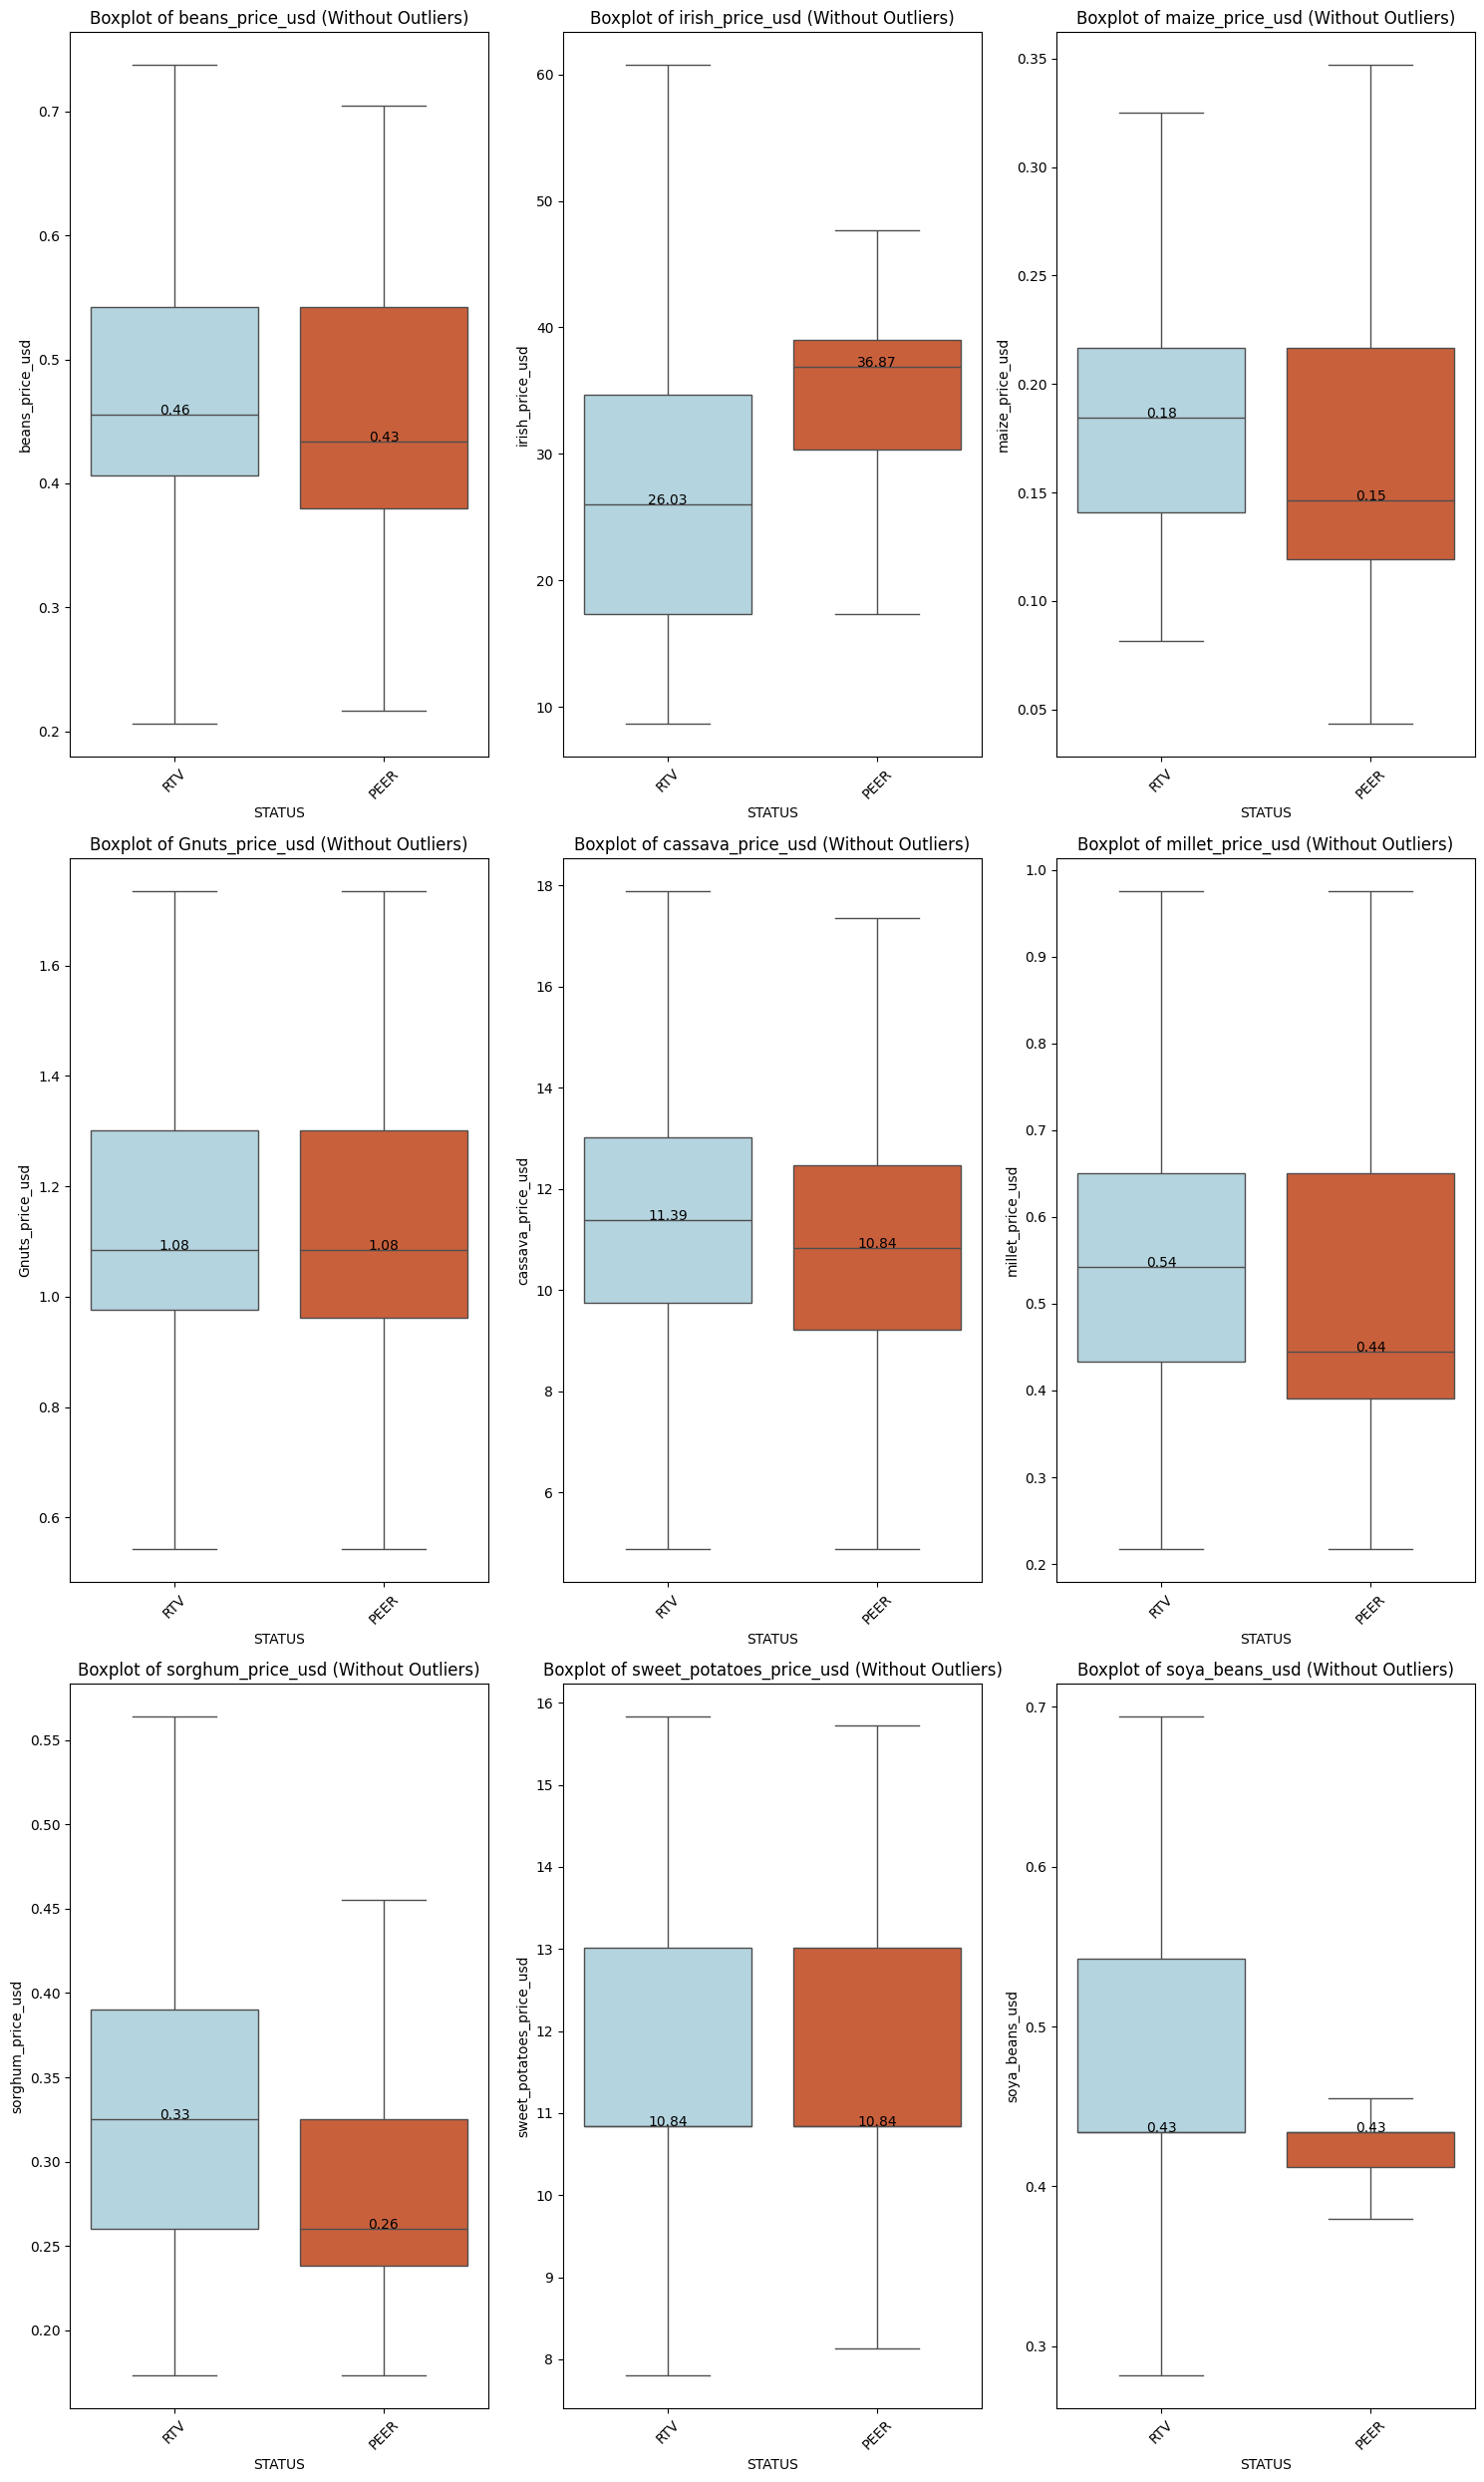

In [150]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to remove outliers based on IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# List of yield columns
yield_columns = ['beans_price_usd', 'irish_price_usd', 'maize_price_usd', 
                 'Gnuts_price_usd', 'cassava_price_usd', 'millet_price_usd', 
                 'sorghum_price_usd', 'sweet_potatoes_price_usd', 'soya_beans_usd']

# Correct the palette based on actual STATUS values in the data
palette = {"RTV": "#ADD8E6", "PEER": "#E05525"}  # Light blue for RTV

# Set up the plot size
plt.figure(figsize=(15, 25))

# Define the order of STATUS for plotting
status_order = ['RTV', 'PEER']

# Create a DataFrame to store whisker and median values with multi-index columns
stats_dict = {}

# Loop through each yield column and create a Box and Whisker plot without outliers
for i, col in enumerate(yield_columns, 1):
    plt.subplot(3, 3, i)  # create a 3x3 grid of plots
    
    # Remove outliers from the data for this column
    filtered_data = remove_outliers(data_filtered, col)
    
    # Create the boxplot, showing whiskers, and customize the color for each STATUS
    sns.boxplot(x='STATUS', y=col, data=filtered_data, palette=palette, order=status_order, showfliers=False)
    
    # Calculate the descriptive statistics for both 'RTV' and 'PEER'
    group_stats = filtered_data.groupby('STATUS')[col].describe()[['25%', '50%', '75%', 'min', 'max']]
    
    # Store the statistics in a dictionary for Excel export
    stats_dict[col] = pd.concat([
        group_stats.loc['RTV'].rename({k: f"RTV_{k}" for k in ['25%', '50%', '75%', 'min', 'max']}),
        group_stats.loc['PEER'].rename({k: f"PEER_{k}" for k in ['25%', '50%', '75%', 'min', 'max']})
    ])

    # Plot the median value on the boxplot
    medians = filtered_data.groupby('STATUS')[col].median()
    for status in status_order:
        if status in filtered_data['STATUS'].unique():
            plt.text(x=status_order.index(status), 
                     y=medians[status], 
                     s=f'{medians[status]:.2f}', 
                     horizontalalignment='center', color='black')
    
    plt.title(f'Boxplot of {col} (Without Outliers)')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust subplots to fit in figure area.

# Save the plot as an image (PNG format) with increased resolution
plt.savefig('Boxplot_for_prices_for_major_seasonal_crop.png', dpi=600, bbox_inches='tight')
plt.show()  # Show the plot

# Create a DataFrame from the dictionary and format it into a multi-column layout
stats_df = pd.DataFrame(stats_dict).T
stats_df.columns = pd.MultiIndex.from_tuples([(group, stat) for group in ['RTV', 'PEER'] for stat in ['25%', '50%', '75%', 'min', 'max']])

# Export whiskers and median values to an Excel file with the specified layout
stats_df.to_excel('whiskers_median_values_with_charts.xlsx', sheet_name='Stats Summary')

# print("Boxplot generated and whisker/median values exported to 'whiskers_median_values_with_charts.xlsx'.")


In [151]:
# Define the variables (crop prices in USD) to test
test_price_variables = ['beans_price_usd', 'irish_price_usd_adjusted', 'maize_price_usd', 
                        'Gnuts_price_usd', 'cassava_price_usd', 'millet_price_usd', 
                        'sorghum_price_usd', 'sweet_potatoes_price_usd','soya_beans_usd']

# Initialize a dictionary to store the mean results and p-values
price_mean_results = {}

# Get the two unique STATUS groups (PEER and RTV)
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_price_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        p_value = round(p_value, 4)  # Truncate p-value to 4 decimal places

        # Save the means and p-value for each variable
        price_mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")

T-test for beans_price_usd: P-value (truncated) = 0.001
Significant difference in beans_price_usd means between PEER and RTV (p < 0.05)

T-test for irish_price_usd_adjusted: P-value (truncated) = 0.0
Significant difference in irish_price_usd_adjusted means between PEER and RTV (p < 0.05)

T-test for maize_price_usd: P-value (truncated) = 0.0
Significant difference in maize_price_usd means between PEER and RTV (p < 0.05)

T-test for Gnuts_price_usd: P-value (truncated) = 0.6843
No significant difference in Gnuts_price_usd means between PEER and RTV (p >= 0.05)

T-test for cassava_price_usd: P-value (truncated) = 0.0
Significant difference in cassava_price_usd means between PEER and RTV (p < 0.05)

T-test for millet_price_usd: P-value (truncated) = 0.0
Significant difference in millet_price_usd means between PEER and RTV (p < 0.05)

T-test for sorghum_price_usd: P-value (truncated) = 0.0
Significant difference in sorghum_price_usd means between PEER and RTV (p < 0.05)

T-test for sweet_p

In [152]:
# Create a DataFrame to store the mean and p-value results for prices
price_result_df = pd.DataFrame({
    'Variable': price_mean_results.keys(),
    'Mean_PEER': [price_mean_results[var]['mean_group1'] for var in test_price_variables],
    'Mean_RTV': [price_mean_results[var]['mean_group2'] for var in test_price_variables],
    'P-Value': [price_mean_results[var]['p_value'] for var in test_price_variables]
})

# Save the results to an Excel file
price_result_df.to_excel('crop_prices_with_significance.xlsx', index=False)

print("Results saved to 'crop_prices_with_significance.xlsx'")

Results saved to 'crop_prices_with_significance.xlsx'


In [153]:
column_value=['food_banana_sold','ripe_banana_sold','avg_fresh_coffee_sold','avg_dried_coffee_sold','tea_yeild_sold',
                                 'avg_process_coffee_sold11','coffee_sold','avocado_yeild_sold','jackfruit_yeild_sold']
# Corrected logic for modifying 'alcohol_banana_sold'
data_filtered['alcohol_banana_sold'] = np.where(
    (data_filtered['mature_alcohol_banana_planted'] == 0) | (pd.isna(data_filtered['mature_alcohol_banana_planted'])),
    np.nan,
    np.where((data_filtered['mature_alcohol_banana_planted'] > 0) & (pd.isna(data_filtered['alcohol_banana_sold'])),
             0, 
             data_filtered['alcohol_banana_sold'])
)

# data_filtered['tea_yeild_sold'] = np.where(
#     (data_filtered['tea_yeild'] > 25) & (pd.isna(data_filtered['tea_yeild_sold'])),
#     data_filtered['tea_yeild'] - 20,
#     data_filtered['tea_yeild_sold']
# )
# Replace zeros in each column with np.nan individually
for col in column_value:
    data_filtered[col] = data_filtered[col].replace(0, np.nan)

data_filtered.groupby('STATUS')[['food_banana_sold','ripe_banana_sold','alcohol_banana_sold','fresh_coffee','Dry_coffee1',
                                 'processed_coffee2','tea_yeild_sold','coffee_sold','avocado_yeild_sold','jackfruit_yeild_sold']].mean().to_excel('quantities sold under different categories of perennials.xlsx')

In [154]:
data_filtered['part_fresh_coffee']=np.where((data_filtered['fresh_coffee']>0),1,0)
data_filtered['part_Dry_coffee']=np.where((data_filtered['Dry_coffee1']>0),1,0)
data_filtered['part_processed_coffee']=np.where((data_filtered['processed_coffee2']>0),1,0)
data_filtered.groupby('STATUS')[['part_fresh_coffee','part_Dry_coffee','part_processed_coffee']].mean()#.to_excel('coffee cate participation.xlsx')

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1720935920.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['part_fresh_coffee']=np.where((data_filtered['fresh_coffee']>0),1,0)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1720935920.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['part_Dry_coffee']=np.where((data_filtered['Dry_coffee1']>0),1,0)
C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1720935920.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is us

,part_fresh_coffee,part_Dry_coffee,part_processed_coffee
STATUS,,,
PEER,0.192767,0.067296,0.013836
RTV,0.277683,0.293729,0.126899


In [155]:
data_filtered['apply_liquid_manure'].unique()

array([0, 1])

## Additional Coffee analysis Impact 

In [156]:
data_filtered.groupby(['STATUS'])[['postharvest_food_storage','apply_liquid_manure']].mean()

,postharvest_food_storage,apply_liquid_manure
STATUS,,
PEER,0.508491,0.008176
RTV,0.754410,0.625184


In [157]:
data_filtered1=data_filtered[data_filtered['perennial_crops_grown_4']==1]

In [158]:
data_filtered1['coffee_total2']=data_filtered1[['fresh_coffee','Dry_coffee1',
                                                                    'processed_coffee2']].sum(axis=1)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2660557361.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['coffee_total2']=data_filtered1[['fresh_coffee','Dry_coffee1',


In [159]:
data_filtered['Total_coffee_yield'].sum(),data_filtered1['coffee_total2'].sum()

(np.float64(576193.0), np.float64(622130.0))

In [160]:
data_filtered1.groupby(['STATUS','postharvest_food_storage'])[[ 'coffee_total2','Total_coffee_yield'
                                                            ]].mean()

coffee_total2  Total_coffee_yield
STATUS postharvest_food_storage                                   
PEER   0                             73.183036           85.437018
       1                             86.070922           98.766839
RTV    0                            114.823423          111.067055
       1                            116.826469          110.993043

In [161]:
data_filtered1.groupby(['STATUS','apply_liquid_manure'])[['coffee_total2','Total_coffee_yield']].mean()#.to_excel('coffeeimpact.xlsx')

coffee_total2  Total_coffee_yield
STATUS apply_liquid_manure                                   
PEER   0                        79.577057           92.239583
       1                        64.875000           74.142857
RTV    0                       124.315465          120.666667
       1                       112.231384          106.029780

In [162]:
data_filtered1.groupby(['STATUS','composts'])[['coffee_total2','Total_coffee_yield']].mean()

coffee_total2  Total_coffee_yield
STATUS composts                                   
PEER   0             79.276546           92.001312
       1             89.571429           96.461538
RTV    0            100.864417          101.155321
       1            124.448110          116.037087

In [163]:
data_filtered1['nasaland_wilt_mgt']=np.where((data_filtered1['wilt_management_coffee_nasaland_1']==1)|
                                           (data_filtered1['wilt_management_coffee_nasaland_2']==1)|
                                           (data_filtered1['wilt_management_coffee_nasaland_3']==1)|
                                           (data_filtered1['wilt_management_coffee_nasaland_97']==1),1,0)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3787968768.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['nasaland_wilt_mgt']=np.where((data_filtered1['wilt_management_coffee_nasaland_1']==1)|


In [164]:
data_filtered1['robusta_wilt_mgt']=np.where((data_filtered1['wilt_management_coffee_robusta_1']==1)|
                                            (data_filtered1['wilt_management_coffee_robusta_2']==1)|
                                            (data_filtered1['wilt_management_coffee_robusta_3']==1)|
                                            (data_filtered1['wilt_management_coffee_robusta_97']==1),1,0)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\1610641352.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['robusta_wilt_mgt']=np.where((data_filtered1['wilt_management_coffee_robusta_1']==1)|


In [165]:
data_filtered1['coffee_wilt_mgt']=np.where(data_filtered1['robusta_wilt_mgt']==1 | (data_filtered1['nasaland_wilt_mgt']==1),1,0)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2914544797.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['coffee_wilt_mgt']=np.where(data_filtered1['robusta_wilt_mgt']==1 | (data_filtered1['nasaland_wilt_mgt']==1),1,0)


In [166]:
data_filtered1.groupby(['STATUS','coffee_wilt_mgt'])[['coffee_total2','Total_coffee_yield']].mean()

coffee_total2  Total_coffee_yield
STATUS coffee_wilt_mgt                                   
PEER   0                    62.964803           78.024272
       1                    99.953608          108.024793
RTV    0                   102.069038          100.412585
       1                   138.111465          126.421370

In [167]:
data_filtered1.groupby(['STATUS','water_control_practise'])[['coffee_total2','Total_coffee_yield']].mean()

coffee_total2  Total_coffee_yield
STATUS water_control_practise                                   
PEER   0                           76.144898           93.642686
       1                           83.682415           90.251397
RTV    0                          106.740397          101.049054
       1                          120.838371          115.667431

In [168]:
data_filtered1.groupby(['STATUS','soil_management'])[['coffee_total2','Total_coffee_yield']].mean()

coffee_total2  Total_coffee_yield
STATUS soil_management                                   
PEER   0                    71.591195           91.800000
       1                    81.195225           92.134375
RTV    0                   119.480176          112.372642
       1                   116.201989          110.942348

In [169]:
data_filtered1.groupby(['STATUS','hh_produce_organics'])[['coffee_total2','Total_coffee_yield']].mean()

coffee_total2  Total_coffee_yield
STATUS hh_produce_organics                                   
PEER   0                        79.455388           92.222947
       1                        78.000000           78.000000
RTV    0                       121.760282          119.635050
       1                       113.344262          106.253897

In [170]:
data_filtered1['AGRIC (%)'].fillna(0, inplace=True) 

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\3251402206.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filtered1['AGRIC (%)'].fillna(0, inplace=True)


In [171]:
bin=[0.0,0.24,0.49,0.64,float('inf')]
label=["0_24","25_49","50_64","65+"]
data_filtered1['agric%_cate4']=pd.cut(data_filtered1['AGRIC (%)'],bins=bin,labels=label)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2874153636.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['agric%_cate4']=pd.cut(data_filtered1['AGRIC (%)'],bins=bin,labels=label)


In [172]:
data_filtered1.groupby(['STATUS','hh_produce_organics'])[['coffee_total2','Total_coffee_yield']].mean()

coffee_total2  Total_coffee_yield
STATUS hh_produce_organics                                   
PEER   0                        79.455388           92.222947
       1                        78.000000           78.000000
RTV    0                       121.760282          119.635050
       1                       113.344262          106.253897

In [173]:
print(data_filtered1['AGRIC (%)'].isna().sum())

0


In [174]:
data_filtered1['AGRIC (%)_cat']=np.where((data_filtered1['AGRIC (%)']<0.24),"0_24",
                                          np.where(((data_filtered1['AGRIC (%)']>0.24) & (data_filtered1['AGRIC (%)']<=0.49)),"25-49",
                                          np.where(((data_filtered1['AGRIC (%)']>0.49) & (data_filtered1['AGRIC (%)']<=0.64)),"50_64","65+")))

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\763854670.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['AGRIC (%)_cat']=np.where((data_filtered1['AGRIC (%)']<0.24),"0_24",


In [175]:
data_filtered1['AGRIC (%)_cat'].unique

<bound method Series.unique of 34       25-49
45       25-49
57       50_64
67        0_24
69         65+
         ...  
14007    50_64
14008    50_64
14009     0_24
14012      65+
14013      65+
Name: AGRIC (%)_cat, Length: 5623, dtype: object>

In [176]:
data_filtered1['AGRIC (%)_cat2']=np.where((data_filtered1['AGRIC (%)']>=0.9),1,0)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\703091343.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['AGRIC (%)_cat2']=np.where((data_filtered1['AGRIC (%)']>=0.9),1,0)


In [177]:
data_filtered1.groupby(['STATUS','AGRIC (%)_cat'])[['coffee_total2','Total_coffee_yield']].mean().to_excel('coffee vs agric comply.xlsx')

In [178]:
data_filtered1.groupby(['STATUS','AGRIC (%)_cat2'])[['coffee_total2','Total_coffee_yield']].mean().to_excel('coffee vs agric comply2.xlsx')

In [179]:
data_filtered['Consumed_coffee']=data_filtered[['coffee_consumed_nasaland','coffee_consumed_robusta']].sum(axis=1)

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2237016225.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered['Consumed_coffee']=data_filtered[['coffee_consumed_nasaland','coffee_consumed_robusta']].sum(axis=1)


In [180]:
data_filtered1['sea_crop_varities']=np.where(data_filtered1['Seasonal _crops_num']<2,"lessthan2","Morethan2")

C:\Users\Edison New\AppData\Local\Temp\ipykernel_12900\2377961135.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_filtered1['sea_crop_varities']=np.where(data_filtered1['Seasonal _crops_num']<2,"lessthan2","Morethan2")


In [182]:
data_filtered1.groupby('sea_crop_varities')[['fresh_coffee','Dry_coffee1',
                                                                    'processed_coffee2']].mean()

,fresh_coffee,Dry_coffee1,processed_coffee2
sea_crop_varities,,,
Morethan2,57.806382,121.551287,125.357002
lessthan2,67.977778,196.051948,91.370968


In [183]:
data_filtered1.groupby(['vsla_Participation_Group'])[['fresh_coffee','Dry_coffee1',
                                                                    'processed_coffee2']].mean()

,fresh_coffee,Dry_coffee1,processed_coffee2
vsla_Participation_Group,,,
0.0,55.914035,129.056711,116.363636
1.0,53.082687,122.064441,128.610951


In [ ]:
data_filtered.groupby('STATUS')[['food_banana_consumed','ripe_banana_consumed','alcohol_banana_consumed',
                                 'Consumed_coffee','tea_yeild_consumed']].mean().to_excel('perennial consumption .xlsx')

In [ ]:
# Calculate the means grouped by 'STATUS'
grouped_means = data_filtered.groupby('STATUS')[['food_banana_sold','ripe_banana_sold','alcohol_banana_sold','fresh_coffee','Dry_coffee1',
                                 'processed_coffee2','tea_yeild_sold','coffee_sold','avocado_yeild_sold','jackfruit_yeild_sold']].mean()

# Reset the index to make 'STATUS' a column
grouped_means_reset = grouped_means.reset_index()

# Melt the dataframe to have 'STATUS', 'crop', and 'mean_value' columns for easier seaborn plotting
grouped_means_melted = grouped_means_reset.melt(id_vars='STATUS', var_name='Perennial_crop', value_name='mean_value')

# Set up the plot size
plt.figure(figsize=(12, 8))

# Create a barplot, grouped by 'STATUS'
ax=sns.barplot(x='Perennial_crop', y='mean_value', hue='STATUS', data=grouped_means_melted, palette={"RTV": "#004C6E", "PEER": "#E05525"})
# Adding mean percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points')

# Rotate the x labels for readability
plt.xticks(rotation=45, ha="right")

# Add title and labels
plt.title('Average perennial Crop Yield Sold by STATUS')
plt.xlabel('Perennial_Crop')
plt.ylabel('Average Quantity Sold')

# Show the plot
plt.tight_layout()
# Save the plot as an image (PNG format)
plt.savefig('bar graph for quantities of perennialcrops sold.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
from scipy import stats

# Define the variables to test (corrected to a flat list)
test_variables = ['food_banana_sold', 'ripe_banana_sold', 'alcohol_banana_sold', 'fresh_coffee', 
                  'Dry_coffee1', 'processed_coffee2', 'tea_yeild_sold', 'coffee_sold', 
                  'avocado_yeild_sold', 'jackfruit_yeild_sold']

# Initialize a dictionary to store the mean results and p-values
mean_results = {}

# Get the two unique STATUS groups (PEER and RTV)
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups: PEER and RTV
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test assuming unequal variance (Welch's t-test)
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        
        # Round the p-value to 4 decimal places
        p_value = round(p_value, 4)

        # Save the means and p-value for each variable
        mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups: PEER and RTV.")


In [ ]:
#Seasona value for major seasonal crops
data_filtered['beans_value']=data_filtered['beans_price_usd']*data_filtered['total_yield_beans(Kgs)']
data_filtered['Irish_value']=data_filtered['irish_price_usd_adjusted']*data_filtered['total_yield_irish_pot(bags)']
data_filtered['maize_value']=data_filtered['maize_price_usd']*data_filtered['total_yield_maize(Kgs)_adjusted5']
data_filtered['Ground_nuts_value']=data_filtered['Gnuts_price_usd']*data_filtered['total_yield_gnuts(Kgs)']
data_filtered['Millet_value']=data_filtered['millet_price_usd']*data_filtered['total_yield_millet(Kgs)']
data_filtered['sorghum_value']=data_filtered['sorghum_price_usd']*data_filtered['total_yield_sorghum(Kgs)']
data_filtered['sweet_potatoes_value']=data_filtered['sweet_potatoes_price_usd']*data_filtered['total_yield_sweetpotatoes(Bags)']
data_filtered['cassava_value']=data_filtered['cassava_price_usd']*data_filtered['total_yield_cassava(Bags)']
data_filtered['Soya_beans_Value']=data_filtered['soya_beans_usd']*data_filtered['total_yield_soyabeans(Kgs)_adjusted']
data_filtered.groupby('STATUS')[['beans_value','Irish_value','maize_value','Ground_nuts_value','Millet_value',
               'sorghum_value','sweet_potatoes_value','cassava_value','Soya_beans_Value']].mean().to_excel('major seasonal crop value.xlsx')

In [ ]:
# Define the variables to test
test_variables = ['beans_value', 'Irish_value', 'maize_value', 'Ground_nuts_value',
                  'Millet_value', 'sorghum_value', 'sweet_potatoes_value', 'cassava_value','Soya_beans_Value']

# Initialize a dictionary to store the mean results and p-values
mean_results = {}

# Get the two unique STATUS groups
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups
if len(statuses) == 2:
    status1, status2 = statuses
    for var in test_variables:
        # Get data for each STATUS group, drop NaN values
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        p_value = round(p_value, 4)  # Truncate p-value to 4 decimal places

        # Save the means and p-value for each variable
        mean_results[var] = {
            'mean_group1': group1.mean(),
            'mean_group2': group2.mean(),
            'p_value': p_value
        }

        # Print the results
        print(f'T-test for {var}: P-value (truncated) = {p_value}')
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS must contain exactly two groups.")

In [ ]:
# Create a DataFrame to store mean and p-value results
result_df = pd.DataFrame({
    'Variable': mean_results.keys(),
    'Mean_Group1': [mean_results[var]['mean_group1'] for var in test_variables],
    'Mean_Group2': [mean_results[var]['mean_group2'] for var in test_variables],
    'P-Value': [mean_results[var]['p_value'] for var in test_variables]
})

# Save the results to an Excel file
result_df.to_excel('major_seasonal_crop_value_with_significance.xlsx', index=False)

print("Results saved to 'major_seasonal_crop_value_with_significance.xlsx'")

In [ ]:

import numpy as np

# Calculate total yields
data_filtered['total_beans_sold'] = data_filtered[['sn_1_beans_Total_Yield_sold_Fresh', 'sn_2_beans_Total_Yield_sold_Fresh',
                                                    'sn_1_beans_Total_Yield_sold_dry', 'sn_2_beans_Total_Yield_sold_dry']].sum(axis=1)

data_filtered['total_maize_sold'] = data_filtered[['sn_1_maize_Total_Yield_sold_Fresh', 'sn_2_maize_Total_Yield_sold_Fresh',
                                                    'sn_1_maize_Total_Yield_sold_dry', 'sn_2_maize_Total_Yield_sold_dry']].sum(axis=1)

data_filtered['total_irish_sold'] = data_filtered[['sn_1_irish_potatoes_Total_Yield_sold', 'sn_2_irish_potatoes_Total_Yield_sold']].sum(axis=1)

data_filtered['total_Gnuts_sold'] = data_filtered[['sn_1_gnuts_Total_Yield_sold', 'sn_2_gnuts_Total_Yield_sold']].sum(axis=1)

data_filtered['total_millet_sold'] = data_filtered[['sn_1_millet_Total_Yield_sold', 'sn_2_millet_Total_Yield_sold']].sum(axis=1)

data_filtered['total_Sorghum_sold'] = data_filtered[['sn_1_sorghum_Total_Yield_sold', 'sn_2_sorghum_Total_Yield_sold']].sum(axis=1)

data_filtered['total_sweet_potatoes_sold'] = data_filtered[['sn_1_sweetpotatoes_Total_Yield_sold', 'sn_2_sweetpotatoes_Total_Yield_sold']].sum(axis=1)

data_filtered['total_cassava_sold'] = data_filtered[['sn_1_cassava_Total_Yield_sold_Fresh', 'sn_2_cassava_Total_Yield_sold_Fresh',
                                                    'sn_1_cassava_Total_Yield_sold_dry', 'sn_2_cassava_Total_Yield_sold_dry']].sum(axis=1)

data_filtered['total_soya_bean_sold'] = data_filtered[['sn_1_soya_beans_Total_Yield_sold', 'sn_2_soya_beans_Total_Yield_sold']].sum(axis=1)

# Replace zeros with NaN only in total sold columns
total_sold_columns = [
    'total_beans_sold',
    'total_maize_sold',
    'total_irish_sold',
    'total_Gnuts_sold',
    'total_millet_sold',
    'total_Sorghum_sold',
    'total_sweet_potatoes_sold',
    'total_cassava_sold',
    'total_soya_bean_sold'
]

data_filtered[total_sold_columns] = data_filtered[total_sold_columns].replace(0, np.nan)

In [ ]:
data_filtered["total_maize_sold_adjusted2"] = data_filtered.apply(lambda row: 130 if row['total_maize_sold'] > 180 and row['STATUS'] == 'PEER' else row['total_maize_sold'], axis=1)

In [ ]:
data_filtered.groupby('STATUS')[[
    'total_beans_sold',
    'total_maize_sold',
    'total_maize_sold_adjusted2',
    'total_irish_sold',
    'total_Gnuts_sold',
    'total_millet_sold',
    'total_Sorghum_sold',
    'total_sweet_potatoes_sold',
    'total_cassava_sold',
    'total_soya_bean_sold',
]].mean().to_excel('Average quantities sold for major seasonal crops.xlsx')

In [ ]:
data_filtered["total_irish_sold_adjusted"] = data_filtered.apply(lambda row: 2 if row['total_irish_sold'] > 3 and row['STATUS'] == 'PEER' else row['total_irish_sold'], axis=1)

data_filtered["total_irish_sold_adjusted"] = data_filtered.apply(
    lambda row: 0.5 if 0 < row['total_irish_sold'] < 0.75 and row['STATUS'] == 'PEER' else row['total_irish_sold_adjusted'],
    axis=1 )
data_filtered["total_irish_sold_adjusted"] = data_filtered.apply(lambda row: 0.7 if 0 < row['total_irish_sold'] < 0.75 and row['STATUS'] == 'RTV' else row['total_irish_sold_adjusted'],
    axis=1)

data_filtered["total_irish_sold_adjusted"] = data_filtered["total_irish_sold_adjusted"].apply(lambda x: np.nan if x == 0 else x)

In [ ]:
# data_filtered["total_Gnuts_sold_adjusted1"] = data_filtered.apply(lambda row: 10 if row['total_Gnuts_sold'] < 4 and row['STATUS'] == 'PEER' else row['total_Gnuts_sold'], axis=1)

# # data_filtered["total_Gnuts_sold_adjusted"] = data_filtered.apply(
# #     lambda row: 500 if 0 < row['total_Gnuts_sold'] < 1000 and row['STATUS'] == 'PEER' else row['total_Gnuts_sold'],
# #     axis=1
# # )

# # data_filtered["total_Gnuts_sold_adjusted"] = data_filtered.apply(
# #     lambda row: 60 if 0 < row['total_Gnuts_sold'] < 30 and row['STATUS'] == 'RTV' else row['total_Gnuts_sold_adjusted'],
# #     axis=1
# # )

# data_filtered["total_Gnuts_sold_adjusted"] = data_filtered["total_Gnuts_sold_adjusted"].apply(lambda x: np.nan if x == 0 else x)

In [ ]:
data_filtered["total_maize_sold_adjusted"] = data_filtered.apply(lambda row: 80 if row['total_maize_sold'] > 150 and row['STATUS'] == 'PEER' else row['total_maize_sold'], axis=1)

data_filtered["total_maize_sold_adjusted"] = data_filtered.apply(
   lambda row: 350 if 500< row['total_maize_sold'] < 3000 and row['STATUS'] == 'PEER' else row['total_maize_sold_adjusted'],
     axis=1
 )

data_filtered["total_maize_sold_adjusted"] = data_filtered.apply(
    lambda row: 70 if 0 < row['total_maize_sold'] < 25 and row['STATUS'] == 'RTV' else row['total_maize_sold'],
    axis=1
)

data_filtered["total_maize_sold_adjusted"] = data_filtered.apply(
    lambda row: np.nan if row["total_maize_sold_adjusted"] == 0 and row['STATUS'] == 'RTV' else row["total_maize_sold_adjusted"],
    axis=1
)

In [ ]:
# Define the variables you want to test
test_variables = [
    'total_beans_sold',
    'total_maize_sold',
    'total_maize_sold_adjusted2',
    'total_irish_sold',
    'total_Gnuts_sold',
    'total_millet_sold',
    'total_Sorghum_sold',
    'total_sweet_potatoes_sold',
    'total_cassava_sold',
    'total_soya_bean_sold',
]

# Get unique values of STATUS
statuses = data_filtered['STATUS'].unique()

# Ensure there are exactly two groups in STATUS
if len(statuses) == 2:
    status1, status2 = statuses
    
    # Loop through each variable and perform a t-test
    for var in test_variables:
        # Get data for each STATUS group
        group1 = data_filtered[data_filtered['STATUS'] == status1][var].dropna()
        group2 = data_filtered[data_filtered['STATUS'] == status2][var].dropna()
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2)
        
        # Print results
        print(f'T-test for {var}:')
        print(f'T-statistic: {t_stat}')
        print(f'P-value (truncated): {round(p_value, 4)}')
        
        # Check for significance
        if p_value < 0.05:
            print(f'Significant difference in {var} means between {status1} and {status2} (p < 0.05)\n')
        else:
            print(f'No significant difference in {var} means between {status1} and {status2} (p >= 0.05)\n')
else:
    print("STATUS contains more than two groups. Please use ANOVA instead.")

In [ ]:
data_filtered['beans_income']=data_filtered['total_beans_sold']*data_filtered['beans_price_usd']
data_filtered['irish_income']=data_filtered['total_irish_sold']*data_filtered['irish_price_usd_adjusted']
data_filtered['maize_income']=data_filtered['total_maize_sold_adjusted2']*data_filtered['maize_price_usd']
data_filtered['Gnuts_income']=data_filtered['total_Gnuts_sold']*data_filtered['Gnuts_price_usd']
data_filtered['Millet_income']=data_filtered['total_millet_sold']*data_filtered['millet_price_usd']
data_filtered['sorghum_income']=data_filtered['total_Sorghum_sold']*data_filtered['sorghum_price_usd']
data_filtered['sweet_potatoes_income']=data_filtered['total_sweet_potatoes_sold']*data_filtered['sweet_potatoes_price_usd']
data_filtered['cassava_income']=data_filtered['total_cassava_sold']*data_filtered['cassava_price_usd']
data_filtered['soya_beans_income']=data_filtered['total_soya_bean_sold']*data_filtered['soya_beans_usd']
# Replace zeros with NaN in income columns
income_columns = [
    'beans_income',
    'irish_income',
    'maize_income',
    'Gnuts_income',
    'Millet_income',
    'sorghum_income',
    'sweet_potatoes_income',
    'cassava_income',
    'soya_beans_income'
]

data_filtered[income_columns] = data_filtered[income_columns].replace(0, np.nan)

In [ ]:
#seasonal income for major seasonal crops
data_filtered.groupby('STATUS')[['beans_income','irish_income','maize_income','Gnuts_income','Millet_income',
                               'sorghum_income','sweet_potatoes_income',
                                 'cassava_income','beans_income','soya_beans_income']].mean().to_excel('seasonal crop income for major crops.xlsx')

In [ ]:
# List of income columns to analyze
income_columns = ['beans_income', 'irish_income', 'maize_income', 'Gnuts_income', 'Millet_income',
                  'sorghum_income', 'sweet_potatoes_income', 'cassava_income','soya_beans_income']

# Separate the data based on STATUS (peer and RTV)
peer_data = data_filtered[data_filtered['STATUS'] == 'PEER']
rtv_data = data_filtered[data_filtered['STATUS'] == 'RTV']

# Perform t-tests for each income variable
for column in income_columns:
    t_stat, p_value = stats.ttest_ind(peer_data[column], rtv_data[column], nan_policy='omit')
    # Truncate p-value to 4 decimal places
    p_value_rounded = round(p_value, 4)
    print(f"T-test for {column}:")
    print(f"  T-statistic: {t_stat}")
    print(f"  P-value: { p_value_rounded}")
    if p_value_rounded < 0.05:
        print(f"  Significant difference (p < 0.05)")
    else:
        print(f"  No significant difference (p >= 0.05)")
    print('-' * 50)

In [ ]:
data_filtered['fresh_coffee_part']=data_filtered['avg_fresh_coffee_sold'].apply(lambda x: 1 if x>0 else 0)
data_filtered['dry_coffee_part']=data_filtered['avg_dried_coffee_sold'].apply(lambda x: 1 if x>0 else 0)
data_filtered['processed_coffee_part']=data_filtered['avg_process_coffee_sold'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
data_filtered['food_banana_part']=data_filtered['perennial_crops_grown_1']
data_filtered['Ripe_banana_part']=data_filtered['perennial_crops_grown_2']
data_filtered['Alcohol_banana_part']=data_filtered['perennial_crops_grown_3']

In [ ]:
data_filtered.groupby('STATUS')[['perennial_crops_grown_1','perennial_crops_grown_2','perennial_crops_grown_3','perennial_crops_grown_4',
               'perennial_crops_grown_5','perennial_crops_grown_6','perennial_crops_grown_7','perennial_crops_grown_8',
               'perennial_crops_grown_9','perennial_crops_grown_10','perennial_crops_grown_11','perennial_crops_grown_12',
               'perennial_crops_grown_13','perennial_crops_grown_14','perennial_crops_grown_15','perennial_crops_grown_16',
               'perennial_crops_grown_17','perennial_crops_grown_18','perennial_crops_grown_19','perennial_crops_grown_20',
               'perennial_crops_grown_21','perennial_crops_grown_22','perennial_crops_grown_23','perennial_crops_grown_24',
               'perennial_crops_grown_25','perennial_crops_grown_26','perennial_crops_grown_27','perennial_crops_grown_28',
               'perennial_crops_grown_29','perennial_crops_grown_30','perennial_crops_grown_97']].mean().to_excel('perennials.xlsx')

In [ ]:
data_filtered.groupby(['STATUS','pre_district'])[['perennial_crops_grown_1','perennial_crops_grown_2','perennial_crops_grown_3','perennial_crops_grown_4',
               'perennial_crops_grown_5','perennial_crops_grown_6','perennial_crops_grown_7','perennial_crops_grown_8',
               'perennial_crops_grown_9','perennial_crops_grown_10','perennial_crops_grown_11','perennial_crops_grown_12',
               'perennial_crops_grown_13','perennial_crops_grown_14','perennial_crops_grown_15','perennial_crops_grown_16',
               'perennial_crops_grown_17','perennial_crops_grown_18','perennial_crops_grown_19','perennial_crops_grown_20',
               'perennial_crops_grown_21','perennial_crops_grown_22','perennial_crops_grown_23','perennial_crops_grown_24',
               'perennial_crops_grown_25','perennial_crops_grown_26','perennial_crops_grown_27','perennial_crops_grown_28',
               'perennial_crops_grown_29','perennial_crops_grown_30','perennial_crops_grown_97']].mean().to_excel('pre_district perennials.xlsx')

In [ ]:
data_filtered['perennial_cropping34'] = np.where(
    data_filtered[['perennial_crops_grown_1', 'perennial_crops_grown_2', 'perennial_crops_grown_3']].isna().all(axis=1), 
    np.nan,  # All values are NaN
    np.where(
        data_filtered[['perennial_crops_grown_1', 'perennial_crops_grown_2', 'perennial_crops_grown_3']].eq(1).any(axis=1), 
        1,     # Any value equals 1
        0      # Otherwise return 0
    )
)
data_filtered.groupby('STATUS')[['perennial_cropping34','perennial_crops_grown_1',
                                 'perennial_crops_grown_2','perennial_crops_grown_3']].mean().to_excel('banana combined.xlsx')

In [ ]:
#perenial participation in major perennial crops
data_filtered.groupby('STATUS')[['food_banana_part','Ripe_banana_part','Alcohol_banana_part','fresh_coffee_part',
                                 'dry_coffee_part','processed_coffee_part']].mean().to_excel('perenial participation in major perennial crops.xlsx')
                                 

In [ ]:
#participation in major seasonal crops
data_filtered.groupby('STATUS')[['Beans','Irish Potatoes','Maize','Ground Nuts','Millet',
                                 'Sorghum','Sweet Potatoes','Cassava']].mean().to_excel('participation in major seasonal crops.xlsx')

In [ ]:
#perennial value for major perennial crops
data_filtered['food_banana_value']=data_filtered['food_banana_yeild']*data_filtered['Plantain_price_usd']
data_filtered['ripe_banana_value']=data_filtered['ripe_banana_yeild']*data_filtered[ 'Dessert_banana_price_usd']
data_filtered['Alochol_banana_value']=data_filtered['alcohol_banana_yeild']*data_filtered['Brewing_banana_price_usd']
# data_filtered['fresh_coffee_value']=data_filtered['avg_fresh_coffee_sold']*data_filtered['coffee_fresh_price_usd']
data_filtered['fresh_coffee_value']=data_filtered['fresh_coffee']*data_filtered['coffee_fresh_price_usd1']
# data_filtered['dry_coffee_value']=data_filtered['avg_dried_coffee_sold']*data_filtered['coffee_dry_price_usd']
data_filtered['dry_coffee_value']=data_filtered['Dry_coffee1']*data_filtered['coffee_dry_price_usd2']
# data_filtered['process_value']=data_filtered['avg_process_coffee_sold11']*data_filtered['coffee_processed_price_usd']
data_filtered['process_value']=data_filtered['processed_coffee2']*data_filtered['coffee_processed_price_usd2']
data_filtered['Tea_value']= data_filtered['tea_yeild']*data_filtered['tea_price_usd1']
data_filtered['eucalyptus_value']=data_filtered['eucalyptus_yeild']*data_filtered['eucalyptus_price_usd']
data_filtered['sugarcane_value']=data_filtered['sugarcane_yeild']*data_filtered['sugarcane_price_usd']
data_filtered['Avocado_value']=data_filtered['Avocado_yeild']*data_filtered['Avocado_price_usd1']
data_filtered['mangoes_value']=data_filtered['mangoes_yeild']*data_filtered['Mangoes_price_usd']
data_filtered['Jackfruit_value']=data_filtered['Jackfruit_yield']*data_filtered['jackfruit_price_usd1']
# Replace zeros in the newly created value columns with np.nan
value_columns = ['food_banana_value', 'ripe_banana_value', 'Alochol_banana_value',
                 'fresh_coffee_value', 'dry_coffee_value', 'process_value',
                 'Tea_value', 'eucalyptus_value', 'sugarcane_value',
                 'Avocado_value', 'mangoes_value', 'Jackfruit_value']

# Replace zeros with np.nan
for col in value_columns:
    data_filtered[col] = data_filtered[col].replace(0, np.nan)

### combined banana analysis

In [ ]:
#perennial value for major perennial crops
data_filtered.groupby('STATUS')[['food_banana_value','ripe_banana_value','Alochol_banana_value',
                                 'fresh_coffee_value','dry_coffee_value',
                                 'process_value','Tea_value','Avocado_value','Jackfruit_value']].mean().to_excel('perennial value for major perennial crops.xlsx')

In [ ]:
#checking for sigificance between means of perennial crops considering peer and rtv
pere_value=['food_banana_value','ripe_banana_value','Alochol_banana_value',
                                 'fresh_coffee_value','dry_coffee_value',
                                 'process_value','Tea_value']
peer_data = data_filtered[data_filtered['STATUS'] == 'PEER']
rtv_data = data_filtered[data_filtered['STATUS'] == 'RTV']
for column in pere_value:
    t_stat,p_value=stats.ttest_ind(peer_data[column],rtv_data[column],nan_policy='omit')
    p_value_rounded=round(p_value,4)
    print(f"The T_test of {column}:")
    print(f"The t_statistics : {t_stat}")
    print(f"The p_value : {p_value_rounded}")
    if p_value < 0.05:
        print(f"  Significant difference (p < 0.05)")
    else:
        print(f"  No significant difference (p >= 0.05)")
    print('-' * 50)

In [ ]:
#perennial income for major perennial crops
data_filtered['food_banana_income'] = data_filtered['food_banana_sold'] * data_filtered['Plantain_price_usd']
data_filtered['ripe_banana_income'] = data_filtered['ripe_banana_sold'] * data_filtered['Dessert_banana_price_usd']
data_filtered['alcohol_banana_income'] = data_filtered['alcohol_banana_sold'] * data_filtered['Brewing_banana_price_usd']
# data_filtered['fresh_coffee_income'] = data_filtered['avg_fresh_coffee_sold'] * data_filtered['coffee_fresh_price_usd']
data_filtered['fresh_coffee_income'] = data_filtered['fresh_coffee'] * data_filtered['coffee_fresh_price_usd1']
# data_filtered['dry_coffee_income'] = data_filtered['avg_dried_coffee_sold'] * data_filtered['coffee_dry_price_usd']
data_filtered['dry_coffee_income'] = data_filtered['Dry_coffee1'] * data_filtered['coffee_dry_price_usd2']
# data_filtered['processed_coffee_income'] = data_filtered['avg_process_coffee_sold11'] * data_filtered['coffee_processed_price_usd']
data_filtered['processed_coffee_income'] = data_filtered['processed_coffee2'] * data_filtered['coffee_processed_price_usd2']
data_filtered['tea_income'] = data_filtered['tea_yeild_sold'] * data_filtered['tea_price_usd1']
data_filtered['Avocado_income']=data_filtered['avocado_yeild_sold'] * data_filtered['Avocado_price_usd1']
data_filtered['Jackfruit_income']=data_filtered['jackfruit_yeild_sold'] * data_filtered['jackfruit_price_usd1']

In [ ]:
data_filtered['combined_banana_price']=data_filtered[['Plantain_price_usd','Dessert_banana_price_usd','Brewing_banana_price_usd']].mean(axis=1)
data_filtered['combined_banana_price']=data_filtered['combined_banana_price'].replace(0,np.nan)

In [ ]:
data_filtered['total_banana_yield']=data_filtered[['total_yield_food_banana','total_yield_ripe_banana','total_yield_alcohol_banana']].sum(axis=1)
data_filtered['total_banana_planted']=data_filtered[['mature_food_banana_planted','mature_ripe_banana_planted','mature_alcohol_banana_planted']].sum(axis=1)
data_filtered['total_banana_planted1']=np.where((data_filtered['total_banana_planted']==0)&(data_filtered['total_banana_yield']>0),data_filtered['total_banana_yield'],
                                                np.where((data_filtered['total_banana_planted']==0)&(data_filtered['total_banana_yield']==0),np.nan,data_filtered['total_banana_planted']))
data_filtered['total_banana_yield'].replace(0,np.nan)
data_filtered['yield per unit']=data_filtered['total_banana_yield']/data_filtered['total_banana_planted1']
data_filtered['yield per unit'].replace(0,np.nan)
data_filtered['total_yield_banana_sold']=data_filtered[['food_banana_sold','ripe_banana_sold','alcohol_banana_sold']].sum(axis=1)
data_filtered['total_yield_banana_sold'] = data_filtered['total_yield_banana_sold'].replace(0, np.nan)

data_filtered['combined_banana_value']=data_filtered['total_banana_yield']*data_filtered['combined_banana_price']
data_filtered['combined_banana_income']=data_filtered['total_yield_banana_sold']*data_filtered['combined_banana_price']
data_filtered[['combined_banana_value','combined_banana_income']]=data_filtered[['combined_banana_value','combined_banana_income']].replace(0,np.nan)
data_filtered.groupby('STATUS')[['total_yield_banana_sold','total_banana_planted1','yield per unit','combined_banana_price',
                                 'combined_banana_value','combined_banana_income']].mean().to_excel('combined banana analysis.xlsx')

In [ ]:
#perennial crops income for major perennial crops
columns=['food_banana_income','ripe_banana_income','alcohol_banana_income',
                                 'fresh_coffee_income','dry_coffee_income','processed_coffee_income',
                                 'tea_income','Avocado_income','Jackfruit_income']
for col in columns:
    data_filtered[col] = data_filtered[col].replace(0, np.nan)
data_filtered.groupby('STATUS')[['food_banana_income','ripe_banana_income','alcohol_banana_income',
                                 'fresh_coffee_income','dry_coffee_income','processed_coffee_income',
                                 'tea_income','Avocado_income','Jackfruit_income']].mean().to_excel('perennial crops income for major perennial crops.xlsx')

In [ ]:
#checking for sign between different means under perennial crops
income_pere=['food_banana_income','ripe_banana_income','alcohol_banana_income',
                                 'fresh_coffee_income','dry_coffee_income','processed_coffee_income',
                                 'tea_income','Avocado_income','Jackfruit_income']
# Separate the data based on STATUS (peer and RTV)
peer_data = data_filtered[data_filtered['STATUS'] == 'PEER']
rtv_data = data_filtered[data_filtered['STATUS'] == 'RTV']

# Perform t-tests for each income variable
for column in income_pere:
    t_stat, p_value = stats.ttest_ind(peer_data[column], rtv_data[column], nan_policy='omit')
    # Truncate p-value to 4 decimal places
    p_value_rounded = round(p_value, 4)
    print(f"T-test for {column}:")
    print(f"  T-statistic: {t_stat}")
    print(f"  P-value: {p_value_rounded}")
    if p_value < 0.05:
        print(f"  Significant difference (p < 0.05)")
    else:
        print(f"  No significant difference (p >= 0.05)")
    print('-' * 50)

### Bannana bacteria wilt management

In [ ]:
#aggregating banana BBW in the last 12 months
data_filtered['bbw_last_year'] = np.where(
    (data_filtered['bbw_last_year_food_banana'] == 1) | 
    (data_filtered['bbw_last_year_ripe_banana'] == 1) | 
    (data_filtered['bbw_last_year_alcohol_banana'] == 1),
    1,
    np.where(
        (data_filtered['bbw_last_year_food_banana'] == 0) | 
        (data_filtered['bbw_last_year_ripe_banana'] == 0) | 
        (data_filtered['bbw_last_year_alcohol_banana'] == 0),
        0,
        np.nan
    ))
    

In [ ]:

# Group for banana_wilt_diseases_1
data_filtered['banana_wilt_diseases_1'] = np.where(
    (data_filtered['food_banana_wilt_diseases_1'] == 1) | 
    (data_filtered['ripe_banana_wilt_diseases_1'] == 1) | 
    (data_filtered['alcohol_banana_wilt_diseases_1'] == 1),
    1,
    np.where(
        (data_filtered['food_banana_wilt_diseases_1'] == 0) | 
        (data_filtered['ripe_banana_wilt_diseases_1'] == 0) | 
        (data_filtered['alcohol_banana_wilt_diseases_1'] == 0),
        0,
        np.nan
    )
)

# Group for banana_wilt_diseases_2
data_filtered['banana_wilt_diseases_2'] = np.where(
    (data_filtered['food_banana_wilt_diseases_2'] == 1) | 
    (data_filtered['ripe_banana_wilt_diseases_2'] == 1) | 
    (data_filtered['alcohol_banana_wilt_diseases_2'] == 1),
    1,
    np.where(
        (data_filtered['food_banana_wilt_diseases_2'] == 0) | 
        (data_filtered['ripe_banana_wilt_diseases_2'] == 0) | 
        (data_filtered['alcohol_banana_wilt_diseases_2'] == 0),
        0,
        np.nan
    )
)

# Group for banana_wilt_diseases_3
data_filtered['banana_wilt_diseases_3'] = np.where(
    (data_filtered['food_banana_wilt_diseases_3'] == 1) | 
    (data_filtered['ripe_banana_wilt_diseases_3'] == 1) | 
    (data_filtered['alcohol_banana_wilt_diseases_3'] == 1),
    1,
    np.where(
        (data_filtered['food_banana_wilt_diseases_3'] == 0) | 
        (data_filtered['ripe_banana_wilt_diseases_3'] == 0) | 
        (data_filtered['alcohol_banana_wilt_diseases_3'] == 0),
        0,
        np.nan
    )
)

# Optionally, display the first few rows of the updated DataFrame
data_filtered.groupby('STATUS')[['bbw_last_year','banana_wilt_diseases_1', 'banana_wilt_diseases_2', 'banana_wilt_diseases_3']].mean().to_excel('diseases banana.xlsx')


In [ ]:

# Create the new column 'bbw_management_banana1'
data_filtered['bbw_management_banana1'] = np.where(
    (data_filtered['bbw_management_alcohol_banana_1'] == 1) | 
    (data_filtered['bbw_management_ripe_banana_1'] == 1) | 
    (data_filtered['bbw_management_food_banana_1'] == 1),
    1,
    np.where(
        (data_filtered['bbw_management_alcohol_banana_1'] == 0) | 
        (data_filtered['bbw_management_ripe_banana_1'] == 0) |
        (data_filtered['bbw_management_food_banana_1'] == 0),
        0,
        np.nan
    )
)


# Group for bbw_management_banana2 (for the second set of columns)
data_filtered['bbw_management_banana2'] = np.where(
    (data_filtered['bbw_management_alcohol_banana_2'] == 1) | 
    (data_filtered['bbw_management_ripe_banana_2'] == 1) | 
    (data_filtered['bbw_management_food_banana_2'] == 1),
    1,
    np.where(
        (data_filtered['bbw_management_alcohol_banana_2'] == 0) | 
        (data_filtered['bbw_management_ripe_banana_2'] == 0) |
        (data_filtered['bbw_management_food_banana_2'] == 0),
        0,
        np.nan
    )
)

# Group for bbw_management_banana3 (for the third set of columns)
data_filtered['bbw_management_banana3'] = np.where(
    (data_filtered['bbw_management_alcohol_banana_3'] == 1) | 
    (data_filtered['bbw_management_ripe_banana_3'] == 1) | 
    (data_filtered['bbw_management_food_banana_3'] == 1),
    1,
    np.where(
        (data_filtered['bbw_management_alcohol_banana_3'] == 0) | 
        (data_filtered['bbw_management_ripe_banana_3'] == 0) | 
        (data_filtered['bbw_management_food_banana_3'] == 0),
        0,
        np.nan
    )
)

# Group for bbw_management_banana_97 (for 97 columns)
data_filtered['bbw_management_banana_97'] = np.where(
    (data_filtered['bbw_management_alcohol_banana_97'] == 1) | 
    (data_filtered['bbw_management_ripe_banana_97'] == 1) | 
    (data_filtered['bbw_management_food_banana_97'] == 1),
    1,
    np.where(
        (data_filtered['bbw_management_alcohol_banana_97'] == 0) | 
        (data_filtered['bbw_management_ripe_banana_97'] == 0) |
        (data_filtered['bbw_management_food_banana_97'] == 0),
        0,
        np.nan
    )
)

# Group for bbw_management_banana_99 (for 99 columns)
data_filtered['bbw_management_banana_99'] = np.where(
    (data_filtered['bbw_management_alcohol_banana_99'] == 1) | 
    (data_filtered['bbw_management_ripe_banana_99'] == 1) | 
    (data_filtered['bbw_management_food_banana_99'] == 1),
    1,
    np.where(
        (data_filtered['bbw_management_alcohol_banana_99'] == 0) |
        (data_filtered['bbw_management_ripe_banana_99'] == 0) | 
        (data_filtered['bbw_management_food_banana_99'] == 0),
        0,
        np.nan
    )
)

# Optionally, display the first few rows of the updated DataFrame
data_filtered.groupby('STATUS')[['bbw_management_banana1', 'bbw_management_banana2', 'bbw_management_banana3', 
                     'bbw_management_banana_97', 'bbw_management_banana_99']].mean().to_excel('BBW mgt.xlsx')


In [ ]:
# Create the new column 'BBW_mgt' based on the specified conditions
data_filtered['BBW_mgt'] = np.where(
    (data_filtered['bbw_management_banana1'] == 1) | 
    (data_filtered['bbw_management_banana2'] == 1) | 
    (data_filtered['bbw_management_banana3'] == 1),
    1,
    np.where(
        (data_filtered['bbw_management_banana1'] == 0) & 
        (data_filtered['bbw_management_banana2'] == 0) & 
        (data_filtered['bbw_management_banana3'] == 0),
        0,
        np.nan
    )
)

# Optionally, display the first few rows of the updated DataFrame
data_filtered.groupby('STATUS')[[ 'BBW_mgt']].mean().to_excel('topline bbw mgt.xlsx')


In [ ]:
data_filtered.groupby('STATUS')[['bbw_last_year_food_banana','food_banana_wilt_diseases_1','food_banana_wilt_diseases_2',
               'food_banana_wilt_diseases_3','bbw_management_food_banana_1','bbw_management_food_banana_2',
               'bbw_management_food_banana_3','bbw_management_food_banana_97',
                                 'bbw_management_food_banana_99']].mean().to_excel('food banana analysis.xlsx')

In [ ]:
# Create the new column 'BBW_mgt' based on the specified conditions
data_filtered['food_bbw_mgt'] = np.where(
    (data_filtered['bbw_management_food_banana_1'] == 1) | 
    (data_filtered['bbw_management_food_banana_2'] == 1) | 
    (data_filtered['bbw_management_food_banana_3'] == 1),
    1,
    np.where(
        (data_filtered['bbw_management_food_banana_1'] == 0) & 
        (data_filtered['bbw_management_food_banana_2'] == 0) & 
        (data_filtered['bbw_management_food_banana_3'] == 0),
        0,
        np.nan
    )
)

# Optionally, display the first few rows of the updated DataFrame
data_filtered.groupby('STATUS')[[ 'food_bbw_mgt']].mean().to_excel('food topline bbw mgt.xlsx')


### Additional Perennial Analysis

In [ ]:
data_filtered['part&earn']=np.where((data_filtered['Perenial Crops Income (USD_Cons_rate)']>0)&
(data_filtered['perennial_cropping']==1),1,
np.where((data_filtered['Perenial Crops Income (USD_Cons_rate)']<=0)&
(data_filtered['perennial_cropping']==1),0,np.nan))
data_filtered.groupby('STATUS')['part&earn'].mean().to_excel('participating and earning in perennials.xlsx')                               

In [ ]:

data_filtered.groupby(['STATUS','part&earn'])[['Perennial Agriculture Value (USD_Cons_rate)']].mean().to_excel('perennials value of those earning from perennials.xlsx')

In [ ]:
#value addition in coffee nasaland
data_filtered['Avg_coffee_valueadd_nasaland']=data_filtered['coffee_sold_process_nasaland'].apply(lambda x: 1 if x>0 else 0)
data_filtered.groupby('STATUS')['Avg_coffee_valueadd_nasaland'].mean()

In [ ]:
data_filtered['sold_nasa'] = np.where(data_filtered['coffee_sold_process_nasaland']>0,1,0)

In [ ]:
##value addition in coffee nasaland looking at all engaged in coffee farming
data_filtered.groupby(['STATUS', 'perennial_crops_grown_4'])[['sold_nasa']].mean()

In [ ]:
#value addition in coffee nasaland
data_filtered['coffee_sold_process_robusta_part']=data_filtered['coffee_sold_process_robusta'].apply(lambda x: 1 if x>0 else 0)
data_filtered.groupby('STATUS')['coffee_sold_process_robusta_part'].mean()


In [ ]:
##value addition in coffee nasaland looking at all engaged in coffee farming
data_filtered.groupby(['STATUS', 'perennial_crops_grown_4'])['coffee_sold_process_robusta_part'].mean()

In [ ]:
#computing average prices for nasaland and robusta
data_filtered.groupby('STATUS')[['coffee_price_process_nasaland','coffee_price_process_robusta']].mean()

# AGRICLUTURE VALUE VS COMPALIANCE

In [ ]:
data_filtered.groupby('STATUS')['Household Compliance (%)'].mean()

In [ ]:
groupby_results = [
    data_filtered.groupby(['STATUS', 'postharvest_food_storage'])['Agriculture Value (USD_Cons_rate)'].mean().rename('postharvest_food_storage_mean'),
    data_filtered.groupby(['STATUS', 'soil_management'])['Agriculture Value (USD_Cons_rate)'].mean().rename('soil_management_mean'),
    data_filtered.groupby(['STATUS', 'water_control_practise'])['Agriculture Value (USD_Cons_rate)'].mean().rename('water_control_practise_mean'),
    data_filtered.groupby(['STATUS', 'apply_liquid_manure'])['Agriculture Value (USD_Cons_rate)'].mean().rename('apply_liquid_manure_mean'),
    data_filtered.groupby(['STATUS', 'composts_freq_use'])['Agriculture Value (USD_Cons_rate)'].mean().rename('composts_freq_use_mean'),
    data_filtered.groupby(['STATUS', 'compost_dimension'])['Agriculture Value (USD_Cons_rate)'].mean().rename('compost_dimension_mean'),
    data_filtered.groupby(['STATUS', 'composts'])['Agriculture Value (USD_Cons_rate)'].mean().rename('composts_mean'),
    data_filtered.groupby(['STATUS', 'hh_produce_organics'])['Agriculture Value (USD_Cons_rate)'].mean().rename('hh_produce_organics_mean')
]

In [ ]:
merged_data = pd.concat(groupby_results, axis=1)
merged_data.to_excel('complaince vs agricluture value.xlsx')

In [ ]:
# Define the variables to group by and compare
grouping_columns = [
    'postharvest_food_storage', 'soil_management', 'water_control_practise', 
    'apply_liquid_manure', 'composts_freq_use', 'compost_dimension', 'composts','hh_produce_organics'
]

# Iterate over each grouping column and test significance between STATUS groups
for group_col in grouping_columns:
    print(f"Testing significance for '{group_col}' grouped by STATUS:")
    
    # Get unique statuses
    statuses = data_filtered['STATUS'].unique()
    
    # Iterate over pairwise comparisons of STATUS
    for status1 in statuses:
        for status2 in statuses:
            if status1 != status2:
                # Filter data for each status group
                data1 = data_filtered[data_filtered['STATUS'] == status1]
                data2 = data_filtered[data_filtered['STATUS'] == status2]
                
                # Extract the agriculture values for each group based on the current grouping column
                data1_values = data1.groupby(group_col)['Agriculture Value (USD_Cons_rate)'].mean()
                data2_values = data2.groupby(group_col)['Agriculture Value (USD_Cons_rate)'].mean()
                
                # Perform t-test between the two groups
                t_stat, p_value = stats.ttest_ind(data1_values, data2_values, nan_policy='omit')
                
                # Truncate p-value to 4 decimal places
                p_value_rounded = round(p_value, 4)
                
                # Print results
                print(f"  {status1} vs {status2} for {group_col}:")
                print(f"    T-statistic: {t_stat}")
                print(f"    P-value: {p_value_rounded}")
                if p_value_rounded < 0.05:
                    print(f"    Significant difference (p < 0.05)")
                else:
                    print(f"    No significant difference (p >= 0.05)")
            print('-' * 50)

In [ ]:
#percentage agricluture compaliance
data_filtered.groupby('STATUS')[['composts','compost_dimension','composts_freq_use','apply_liquid_manure','hh_produce_organics',
                                 'water_control_practise','soil_management','postharvest_food_storage','AGRIC (%)']].mean().to_excel('percentage agricluture compaliance.xlsx')

# CLIMATE ANALYSTICS

In [ ]:
#climate change
data_filtered.groupby('STATUS')[['changes_weather','rtv_climate_support']].mean().to_excel('climate change support.xlsx')

In [ ]:
#climate change2
data_filtered.groupby('STATUS')[['changes_weather_specific_1','changes_weather_specific_2','changes_weather_specific_3',
                                 'changes_weather_specific_4','changes_weather_specific_5',
                                 'changes_weather_specific_97']].mean().to_excel('climate impact.xlsx')

In [ ]:
#climate change3
data_filtered.groupby('STATUS')[['ews_challenges_1','ews_challenges_2','ews_challenges_3','ews_challenges_4','ews_challenges_5',
                                 'ews_challenges_6','ews_challenges_7','ews_challenges_8','ews_challenges_9',
                                 'ews_challenges_97']].mean().to_excel('climate challenges.xlsx')

In [ ]:
# Create a dictionary to store value counts for each column
value_counts_dict = {
    'rtv_support__rank1': data_filtered['rtv_support__rank1'].value_counts(normalize=1).rename('rank1'),
    'rtv_support__rank2': data_filtered['rtv_support__rank2'].value_counts(normalize=1).rename('rank2'),
    'rtv_support__rank3': data_filtered['rtv_support__rank3'].value_counts(normalize=1).rename('rank3'),
    'rtv_support__rank4': data_filtered['rtv_support__rank4'].value_counts(normalize=1).rename('rank4'),
}

# Concatenate all the value counts into one DataFrame
rtv_support_counts = pd.concat(value_counts_dict, axis=1)
rtv_support_counts.to_excel('rtv_support.xlsx')

In [ ]:
#RTV intervention addressing climate change
data_filtered['rtv_support__rank1'].value_counts(normalize=1)
data_filtered['rtv_support__rank2'].value_counts(normalize=1)
data_filtered['rtv_support__rank3'].value_counts(normalize=1)
data_filtered['rtv_support__rank4'].value_counts(normalize=1)
data_filtered['rtv_support_other'].value_counts(normalize=1)

In [ ]:
# Your value counts dictionary (assuming you have already computed it)
value_counts_dict = {
    'rtv_support__rank1': data_filtered['rtv_support__rank1'].value_counts(normalize=1).rename('rank1'),
    'rtv_support__rank2': data_filtered['rtv_support__rank2'].value_counts(normalize=1).rename('rank2'),
    'rtv_support__rank3': data_filtered['rtv_support__rank3'].value_counts(normalize=1).rename('rank3'),
    'rtv_support__rank4': data_filtered['rtv_support__rank4'].value_counts(normalize=1).rename('rank4'),
}

# Create a DataFrame from the dictionary
df_ranks = pd.DataFrame(value_counts_dict)

# Define the custom index for the interventions
index = [
    'VSLA access ( Adoption of Sustainable Agricultural Practices, Diversification of Livelihoods etc.)',
    'Distribution of early maturing varieties/improved varieties/drought resistant',
    'Composting/Proper use of composts',
    'Water control practices',
    'Crop diversification',
    'Soil management practices',
    'Application of organic manure and pesticides',
    'Crop rotation',
    'Use of liquid manure',
    'Planting calendars',
    'Use of cover crops/Intercropping',
    'Bottle/ irrigation',
    'Keyhole/backyard gardening',
    'Farmer managed nature regeneration practice',
    'Soil testing',
    'Others,specify',
    'Energy saving stoves/bricket making'
]

# Assign the custom index to the DataFrame
df_ranks.index = index

# Check if the dataframe has missing values (because of mismatched sizes)
df_ranks = df_ranks.fillna(0)  # Filling missing values with 0 for cleaner heatmap

# Plot the heatmap
sns.heatmap(df_ranks, annot=True, cmap='coolwarm', fmt='.2f')

# Set the plot title
plt.title('Ranking Distribution of RTV Interventions')

# Display the heatmap
plt.show()

In [ ]:
data_filtered['pre_district']=np.where((data_filtered['pre_district']=='kanungu'),'Kanungu',data_filtered['pre_district'])
data_filtered.groupby(['STATUS','pre_district'])[['perennial_crops_grown_1','perennial_crops_grown_2','perennial_crops_grown_3']].mean().to_excel('ban.xlsx')

# FARMING EXPENDITURE ANALYTICS

In [ ]:
#farm expenses
data_filtered['Farm Expenses_usd']=data_filtered['Farm Expenses']/3600*0.7808
data_filtered.groupby(['STATUS'])['Farm Expenses_usd'].mean().to_excel('farming expenditure topline.xlsx')

In [ ]:
data_filtered['expenses_artificial_pesticides'] = data_filtered[['organic4_expenses', 'organic5_expenses', 'organic6_expenses']].apply(
    lambda row: np.nan if row.isnull().all() else (row.sum() / 3600) * 0.7808, axis=1
)
data_filtered['expenses_organic_pesticides']=data_filtered[['organic1_expenses','organic2_expenses','organic3_expenses']].apply(
    lambda row: np.nan if row.isnull().all() else (row.sum() / 3600) * 0.7808, axis=1
)
data_filtered['total_organic_pesticides']=data_filtered[['organic_inputs_1','organic_inputs_2','organic_inputs_3']].apply(
    lambda row: np.nan if row.isnull().all() else row.sum(), axis=1)
data_filtered['total_artificial_pesticides']=data_filtered[['organic_inputs_4','organic_inputs_5','organic_inputs_6']].apply(
    lambda row: np.nan if row.isnull().all() else row.sum(), axis=1)

In [ ]:
data_filtered.rename(columns={'farming_inputs7_expenses': 'seed_expenses'}, inplace=True)

In [ ]:
data_filtered['seed_expenses_usd']=data_filtered['seed_expenses']*0.7808/3700

In [ ]:
data_filtered.groupby(['STATUS'])[['seed_expenses_usd','expenses_artificial_pesticides','expenses_organic_pesticides','total_organic_pesticides','total_artificial_pesticides']].mean()

In [ ]:
# Calculate the means grouped by 'STATUS'
grouped_means = data_filtered.groupby('STATUS')[['seed_expenses_usd','expenses_artificial_pesticides','expenses_organic_pesticides']].mean()

# Reset the index to make 'STATUS' a column
grouped_means_reset = grouped_means.reset_index()

# Melt the dataframe to have 'STATUS', 'crop', and 'mean_value' columns for easier seaborn plotting
grouped_means_melted = grouped_means_reset.melt(id_vars='STATUS', var_name='Expenses', value_name='mean_value')

# Set up the plot size
plt.figure(figsize=(12, 8))

# Create a barplot, grouped by 'STATUS'
ax=sns.barplot(x='Expenses', y='mean_value', hue='STATUS', data=grouped_means_melted, palette={"RTV": "#004C6E", "PEER": "#E05525"})
# Adding mean percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'${p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points')

# Rotate the x labels for readability
plt.xticks(rotation=45, ha="right")

# Add title and labels
plt.title('Farm Expenditure $ on key categories RTV vs peers')
plt.xlabel('Expenses')
plt.ylabel('Average Farm Expenditure in usd_cons_rate')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
data_filtered.groupby('STATUS')[['Land_size_for_Crop_Agriculture_Acres','Seasonal _crops_num','Vegs_Num','number_perennial_grown']].mean()

In [ ]:
data_filtered.groupby('STATUS')[['forms_labour_2','sn_2_forms_labour_2','forms_labour_3','sn_2_forms_labour_3']].mean()

In [ ]:
data_filtered['hired_labor'] = data_filtered[['forms_labour_2', 'sn_2_forms_labour_2', 'forms_labour_3', 'sn_2_forms_labour_3']].apply(
    lambda row: np.nan if row.isnull().all() else row.sum(), axis=1
)


In [ ]:
data_filtered['hired_labor_1'] = data_filtered['hired_labor'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
data_filtered.groupby('STATUS')['hired_labor_1'].mean().to_excel('hired labour.xlsx')

In [ ]:
data_filtered['coffee']=data_filtered[['coffee_yeild_nasaland','coffee_yeild_robusta']].sum(axis=1)

In [ ]:
data_filtered.groupby('STATUS')['coffee'].mean()

### Land ownership

In [ ]:
data_filtered['Headship']=np.where((data_filtered['hhh_age']<=30),"Youth Headed",
                                    np.where((data_filtered['hhh_age']>30) & (data_filtered['hhh_sex']==2),
                                             "Women Headed","Men Headed"))

In [ ]:
#land ownership analysis
data_land=data_filtered[(data_filtered['Size_land_owned']<5)]
data_land['Land_size_for_Crop_Agriculture_Acres28']=np.where((data_land['Land_size_for_Crop_Agriculture_Acres']<0.5)&(data_land['STATUS']=='PEER'),np.nan,
                                                            np.where((data_land['Land_size_for_Crop_Agriculture_Acres']>2.3)&(data_land['STATUS']=='RTV'),1.9785,
                                                            data_land['Land_size_for_Crop_Agriculture_Acres']))
                                                            
data_land['Size_Land_Owned']=data_land[['Land_size_for_Crop_Agriculture_Acres28', 
                   'Land_Not_used__Fallow_LandAcre', 
                   'Land_Rented_out_for_income_Acres', 
                   'Land_Homestead']].sum(axis=1)
data_land['Size_Land_Owned']=data_land['Size_Land_Owned'].replace(0,np.nan)
# data_land['Size_land_owned7'] = np.where(
#     (data_land['Size_land_owned26'] > 0) & (data_land['Size_land_owned26'] < 1.3) & (data_land['STATUS'] == 'PEER'),
#     data_land['Size_land_owned26'] + 0.4,
#         data_land['Size_land_owned26']
#     )

data_land['Size_land_owned15'] = np.where(
                                          (data_land['Size_Land_Owned'] > 0) & (data_land['Size_Land_Owned'] < 1.3) & (data_land['STATUS'] == 'PEER'),
                                           data_land['Size_Land_Owned'] + 0.4,
                                    np.where(
                                          (data_land['Size_Land_Owned'] == 2) & (data_land['STATUS'] == 'RTV'),
                                           1.65,data_land['Size_Land_Owned'])
                                   )
data_land.groupby(['STATUS'])[['Land_size_for_Crop_Agriculture_Acres28','Size_Land_Owned','Size_land_owned','Size_land_owned15']].mean()#.to_excel('land ownership.xlsx')

In [ ]:

# Condition to identify rows where the conditions hold true
condition = (data_land['Land_size_for_Crop_Agriculture_Acres29'] == 1.5) & (data_land['STATUS'] == 'RTV')

# Get the indices of rows where the condition is True
indices = data_land[condition].index

# Randomly select 50% of those indices
random_indices = np.random.choice(indices, size=int(0.7 * len(indices)), replace=False)

# Create a new column with the default values (or overwrite the original if desired)
data_land['Land_size_for_Crop_Agriculture_Acres29_modified1'] = data_land['Land_size_for_Crop_Agriculture_Acres29']

# Assign 1 to the randomly selected 50% of rows
data_land.loc[random_indices, 'Land_size_for_Crop_Agriculture_Acres29_modified1'] = 1

# Keep the remaining rows unchanged


In [ ]:
#land ownership analysis
                                                            
data_land['Total_land_owned']=data_land['Size_Land_Owned']
data_land['Total_land_owned3']=np.where((data_land['Total_land_owned']>2.5)&(data_land['STATUS']=='RTV'),0.75,data_land['Total_land_owned'])
data_land['Land_size_for_Crop_Agriculture_Acres29']=data_land['Land_size_for_Crop_Agriculture_Acres28']
data_land['Land_size_for_Crop_Agriculture_Acres33']=np.where((data_land['Land_size_for_Crop_Agriculture_Acres29']>2)&(data_land['STATUS']=='RTV'),1.01,data_land['Land_size_for_Crop_Agriculture_Acres29'])

data_land.groupby(['STATUS'])[['Total_land_owned3','Land_size_for_Crop_Agriculture_Acres29_modified1']].median().to_excel('median land ownership.xlsx')

In [ ]:
data_land[['STATUS','Total_land_owned3','Land_size_for_Crop_Agriculture_Acres33','Size_Land_Owned',
           'Land_size_for_Crop_Agriculture_Acres28']].to_excel('landf.xlsx')

In [ ]:
data_land.groupby(['STATUS','Headship'])[['Land_size_for_Crop_Agriculture_Acres28'
                   ]].mean().to_excel('land analysis by headship.xlsx')

In [ ]:
#land ownership analysis
data_filtered.groupby(['STATUS'])[['Size_land_owned', 'Land_size_for_Crop_Agriculture_Acres', 
                   'Land_size_for_Grazing_Livestock__Acres', 
                   'Land_Not_used__Fallow_LandAcre', 
                   'Land_Rented_out_for_income_Acres', 
                   'Land_Homestead']].mean().to_excel('land ownership general.xlsx')

### Knowlodge Atitude and practice analysis

In [ ]:
data_filtered['KAP_cate']=data_filtered['kap_farm_practices_num'].apply(lambda X:1 if X>=3 else 0)
data_filtered.groupby('STATUS')[['KAP_cate']].mean().to_excel('kap overall.xlsx')

In [ ]:
from scipy import stats

# Prepare a DataFrame to store results
t_test_results = {}

# Check if there are exactly two groups (RTV and PEER)
statuses = data_land['STATUS'].unique()
if len(statuses) == 2 and set(statuses) == {'RTV', 'PEER'}:
    for column in ['Size_land_owned', 'Land_size_for_Crop_Agriculture_Acres', 
                   'Land_size_for_Grazing_Livestock__Acres', 
                   'Land_Not_used__Fallow_LandAcre', 
                   'Land_Rented_out_for_income_Acres', 
                   'Land_Homestead']:
        
        # Get values for the two groups
        group1 = data_land[data_land['STATUS'] == 'RTV'][column].dropna()
        group2 = data_land[data_land['STATUS'] == 'PEER'][column].dropna()
        
        # Perform t-test
        t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch's t-test
        
        # Round p-value to four decimal points
        p_value_rounded = round(p_value, 4)
        
        # Store results
        t_test_results[column] = {'t-statistic': t_statistic, 'p-value': p_value_rounded}

# Convert results to a DataFrame for easier viewing
t_test_results_df = pd.DataFrame(t_test_results).T
print(t_test_results_df)


In [ ]:
#land ownership analysis
data_filtered.groupby(['STATUS','Headship'])[['Size_land_owned','Land_size_for_Crop_Agriculture_Acres','Land_size_for_Grazing_Livestock__Acres',
                                 'Land_Not_used__Fallow_LandAcre','Land_Rented_out_for_income_Acres',
                                              'Land_Homestead']].mean().to_excel('land ownership by headship.xlsx')

In [ ]:
data_filtered.groupby(['STATUS'])['Land_size_for_Crop_Agriculture_Acres'].mean()

# VEGETABLE ANALYSIS

In [ ]:
data_filtered.groupby(['STATUS'])[['Season1 Vegetable Income (USD)','Season2 Vegetable Income (USD)','Vegetable Income (USD)',
                                   'Season1 Vegetable Value (USD)',
                                  'Season2 Vegetable Value (USD)','Seasonal Vegetable Value (USD)']].mean().to_excel('vegetable income and value topline.xlsx')

In [ ]:
# Assuming Vegs_Num is numeric
bins = [0, 1, 2, 3, 4, float('inf')]
labels = ['One', 'Two', 'Three', 'Four', 'Five and above']

data_filtered['Vegs_Category'] = pd.cut(data_filtered['Vegs_Num'], bins=bins, labels=labels, right=True)

# Check the result
veg_cat=data_filtered.groupby(['STATUS'])['Vegs_Category'].value_counts(normalize=True)
veg_cat.to_excel('veg categories.xlsx')

In [ ]:
data_filtered.groupby('STATUS')['Vegs_Num'].mean()

In [ ]:
data_filtered.groupby('STATUS')[['Pumpkins','Carrots','Onions','Green Pepper','Hot Pepper','Cabbages','Tomatoes','Watermelon',
'Spinach',
'Cauliflower',
'Sukuma wiki',
'Beetroot',
'Black nightshade',
'White eggplants',
'Green Eggplants',
'Purple Eggplants',
'Dodo (Amaranthus)',
     'Chayote',                            
'Others']].mean().to_excel('veg participation per crop.xlsx')


In [ ]:
# Total yield for Pumpkins (example based on the columns you mentioned)
data_filtered['Pumpkins_yield'] = data_filtered[[
    'sn_1_Pumpkins_Yield_Sold', 'sn_2_Pumpkins_Yield_Sold', 
    'sn_1_Pumpkins_Yield_consume', 'sn_2_Pumpkins_Yield_consume',
    'sn_1_Pumpkins_Yield_remittance_gift', 'sn_2_Pumpkins_Yield_remittance_gift',
    'sn_1_Pumpkins_Yield_payment_fees_labour', 'sn_2_Pumpkins_Yield_payment_fees_labour',
    'sn_1_Pumpkins_Yield_spoiled', 'sn_2_Pumpkins_Yield_spoiled'
]].sum(axis=1)

# Total yield for Carrots
data_filtered['Carrots_yield'] = data_filtered[[
    'sn_1_Carrots_Yield_Sold', 'sn_2_Carrots_Yield_Sold',
    'sn_1_Carrots_Yield_consume', 'sn_2_Carrots_Yield_consume',
    'sn_1_Carrots_Yield_remittance_gift', 'sn_2_Carrots_Yield_remittance_gift',
    'sn_1_Carrots_Yield_payment_fees_labour', 'sn_2_Carrots_Yield_payment_fees_labour',
    'sn_1_Carrots_Yield_spoiled', 'sn_2_Carrots_Yield_spoiled'
]].sum(axis=1)

# Total yield for Onions
data_filtered['onions_yield'] = data_filtered[[
    'sn_1_onions_Yield_Sold', 'sn_2_onions_Yield_Sold',
    'sn_1_onions_Yield_consume', 'sn_2_onions_Yield_consume',
    'sn_1_onions_Yield_remittance_gift', 'sn_2_onions_Yield_remittance_gift',
    'sn_1_onions_Yield_payment_fees_labour', 'sn_2_onions_Yield_payment_fees_labour',
    'sn_1_onions_Yield_spoiled', 'sn_2_onions_Yield_spoiled'
]].sum(axis=1)

data_filtered['green_pepper_yield'] = data_filtered[[
    'sn_1_green_pepper_Yield_Sold', 'sn_2_green_pepper_Yield_Sold',
    'sn_1_green_pepper_Yield_consume', 'sn_2_green_pepper_Yield_consume',
    'sn_1_green_pepper_Yield_remittance_gift', 'sn_2_green_pepper_Yield_remittance_gift',
    'sn_1_green_pepper_Yield_payment_fees_labour', 'sn_2_green_pepper_Yield_payment_fees_labour',
    'sn_1_green_pepper_Yield_spoiled', 'sn_2_green_pepper_Yield_spoiled'
]].sum(axis=1)

#Total yield for hotpepper
data_filtered['hot_pepper_yield'] = data_filtered[[
   'sn_1_hot_pepper_Yield_Sold', 'sn_2_hot_pepper_Yield_Sold',
    'sn_1_hot_pepper_Yield_consume', 'sn_2_hot_pepper_Yield_consume',
    'sn_1_hot_pepper_Yield_remittance_gift', 'sn_2_hot_pepper_Yield_remittance_gift',
    'sn_1_hot_pepper_Yield_payment_fees_labour', 'sn_2_hot_pepper_Yield_payment_fees_labour',
    'sn_1_hot_pepper_Yield_spoiled', 'sn_2_hot_pepper_Yield_spoiled'
]].sum(axis=1)

#Total yield for cabbage
data_filtered['cabbage_yield']=data_filtered[[
    'sn_1_cabbage_Yield_Sold', 'sn_2_cabbage_Yield_Sold',
    'sn_1_cabbage_Yield_consume', 'sn_2_cabbage_Yield_consume',
    'sn_1_cabbage_Yield_remittance_gift', 'sn_2_cabbage_Yield_remittance_gift',
    'sn_1_cabbage_Yield_payment_fees_labour', 'sn_2_cabbage_Yield_payment_fees_labour',
    'sn_1_cabbage_Yield_spoiled', 'sn_2_cabbage_Yield_spoiled'
]].sum(axis=1)

#Total yield for tomatoes
data_filtered['tomato_Yield']=data_filtered[[
    'sn_1_tomato_Yield_Sold', 'sn_2_tomato_Yield_Sold',
    'sn_1_tomato_Yield_consume', 'sn_2_tomato_Yield_consume',
    'sn_1_tomato_Yield_remittance_gift', 'sn_2_tomato_Yield_remittance_gift',
    'sn_1_tomato_Yield_payment_fees_labour', 'sn_2_tomato_Yield_payment_fees_labour',
    'sn_1_tomato_Yield_spoiled', 'sn_2_tomato_Yield_spoiled'
]].sum(axis=1)

#total yield for watermelon
data_filtered['watermelon_Yield']=data_filtered[[
    'sn_1_watermelon_Yield_Sold', 'sn_2_watermelon_Yield_Sold',
    'sn_1_watermelon_Yield_consume', 'sn_2_watermelon_Yield_consume',
    'sn_1_watermelon_Yield_remittance_gift', 'sn_2_watermelon_Yield_remittance_gift',
    'sn_1_watermelon_Yield_payment_fees_labour', 'sn_2_watermelon_Yield_payment_fees_labour',
    'sn_1_watermelon_Yield_spoiled', 'sn_2_watermelon_Yield_spoiled'
]].sum(axis=1)

#total yield for spinach
data_filtered['spinach_Yield']=data_filtered[[
    'sn_1_spinach_Yield_Sold', 'sn_2_spinach_Yield_Sold',
    'sn_1_spinach_Yield_consume', 'sn_2_spinach_Yield_consume',
    'sn_1_spinach_Yield_remittance_gift', 'sn_2_spinach_Yield_remittance_gift',
    'sn_1_spinach_Yield_payment_fees_labour', 'sn_2_spinach_Yield_payment_fees_labour',
    'sn_1_spinach_Yield_spoiled', 'sn_2_spinach_Yield_spoiled'
]].sum(axis=1)

#total yield for cauliflower_Yield
data_filtered['cauliflower_Yield']=data_filtered[[
    'sn_1_cauliflower_Yield_Sold', 'sn_2_cauliflower_Yield_Sold',
    'sn_1_cauliflower_Yield_consume', 'sn_2_cauliflower_Yield_consume',
    'sn_1_cauliflower_Yield_remittance_gift', 'sn_2_cauliflower_Yield_remittance_gift',
    'sn_1_cauliflower_Yield_payment_fees_labour', 'sn_2_cauliflower_Yield_payment_fees_labour',
    'sn_1_cauliflower_Yield_spoiled', 'sn_2_cauliflower_Yield_spoiled'
]].sum(axis=1)

#total yield for sukuma wiki
data_filtered['sukuma_wiki_Yield']=data_filtered[[
    'sn_1_sukuma_wiki_Yield_Sold', 'sn_2_sukuma_wiki_Yield_Sold',
    'sn_1_sukuma_wiki_Yield_consume', 'sn_2_sukuma_wiki_Yield_consume',
    'sn_1_sukuma_Yield_remittance_gift', 'sn_2_sukuma_wiki_Yield_remittance_gift',
    'sn_1_sukuma_Yield_payment_fees_labour', 'sn_2_sukuma_wiki_Yield_payment_fees_labour',
    'sn_1_sukuma_wiki_Yield_spoiled', 'sn_2_sukuma_wiki_Yield_spoiled'
]].sum(axis=1)

#total yield for beetroot
data_filtered['beetroot_Yield']=data_filtered[[
    'sn_1_beetroot_Yield_Sold', 'sn_2_beetroot_Yield_Sold',
    'sn_1_beetroot_Yield_consume', 'sn_2_beetroot_Yield_consume',
    'sn_1_beetroot_Yield_remittance_gift', 'sn_2_beetroot_Yield_remittance_gift',
    'sn_1_beetroot_Yield_payment_fees_labour', 'sn_2_beetroot_Yield_payment_fees_labour',
    'sn_1_beetroot_Yield_spoiled', 'sn_2_beetroot_Yield_spoiled'
]].sum(axis=1)

#total yield for blacknightshade
data_filtered['blacknightshade_Yield']=data_filtered[[
    'sn_1_blacknightshade_Yield_Sold', 'sn_2_blacknightshade_Yield_Sold',
    'sn_1_blacknightshade_Yield_consume', 'sn_2_blacknightshade_Yield_consume',
    'sn_1_blacknightshade_Yield_remittance_gift', 'sn_2_blacknightshade_Yield_remittance_gift',
    'sn_1_blacknightshade_Yield_payment_fees_labour', 'sn_2_blacknightshade_Yield_payment_fees_labour',
    'sn_1_blacknightshade_Yield_spoiled', 'sn_2_blacknightshade_Yield_spoiled'
]].sum(axis=1)

#total yield for white_eggplant
data_filtered['white_eggplant_Yield']=data_filtered[[
    'sn_1_white_eggplant_Yield_Sold', 'sn_2_white_eggplant_Yield_Sold',
    'sn_1_white_eggplant_Yield_consume', 'sn_2_white_eggplant_Yield_consume',
    'sn_1_white_eggplant_Yield_remittance_gift', 'sn_2_white_eggplant_Yield_remittance_gift',
    'sn_1_white_eggplant_Yield_payment_fees_labour', 'sn_2_white_eggplant_Yield_payment_fees_labour',
    'sn_1_white_eggplant_Yield_spoiled', 'sn_2_white_eggplant_Yield_spoiled'
]].sum(axis=1)

#total yield for green_eggplant
data_filtered['green_eggplant_Yield']=data_filtered[[
    'sn_1_green_eggplant_Yield_Sold', 'sn_2_green_eggplant_Yield_Sold',
    'sn_1_green_eggplant_Yield_consume', 'sn_2_green_eggplant_Yield_consume',
    'sn_1_green_eggplant_Yield_remittance_gift', 'sn_2_green_eggplant_Yield_remittance_gift',
    'sn_1_green_eggplant_Yield_payment_fees_labour', 'sn_2_green_eggplant_Yield_payment_fees_labour',
    'sn_1_green_eggplant_Yield_spoiled', 'sn_2_green_eggplant_Yield_spoiled'
]].sum(axis=1)

#total yield for purple_eggplants
data_filtered['purple_eggplant_Yield']=data_filtered[[
    'sn_1_purple_eggplant_Yield_Sold', 'sn_2_purple_eggplant_Yield_Sold',
    'sn_1_purple_eggplant_Yield_consume', 'sn_2_purple_eggplant_Yield_consume',
    'sn_1_purple_eggplant_Yield_remittance_gift', 'sn_2_purple_eggplant_Yield_remittance_gift',
    'sn_1_purple_eggplant_Yield_payment_fees_labour', 'sn_2_purple_eggplant_Yield_payment_fees_labour',
    'sn_1_purple_eggplant_Yield_spoiled', 'sn_2_purple_eggplant_Yield_spoiled'
]].sum(axis=1)

#total yield for dodo
data_filtered['dodo_Yield']=data_filtered[[
    'sn_1_dodo_Total_Yield_sold', 'sn_2_dodo_Total_Yield_sold',
    'sn_1_dodo_Total_Yield_consume', 'sn_2_dodo_Total_Yield_consume',
    'sn_1_dodo_Yield_remittance_gift', 'sn_2_dodo_Yield_remittance_gift',
    'sn_1_dodo_Yield_payment_fees_labour', 'sn_2_dodo_Yield_payment_fees_labour',
    'sn_1_dodo_Yield_spoiled', 'sn_2_dodo_Yield_spoiled'
]].sum(axis=1)

#total yield for Chayote
data_filtered['Chayote_Yield']=data_filtered[[
    'sn_1_Chayote_Yield_Sold', 'sn_2_Chayote_Yield_Sold',
    'sn_1_Chayote_Yield_consume', 'sn_2_Chayote_Yield_consume',
    'sn_1_Chayote_Yield_remittance_gift', 'sn_2_Chayote_Yield_remittance_gift',
    'sn_1_Chayote_Yield_payment_fees_labour', 'sn_2_Chayote_Yield_payment_fees_labour',
    'sn_1_Chayote_Yield_spoiled', 'sn_2_Chayote_Yield_spoiled'
]].sum(axis=1)

#total yield for other vegetables
data_filtered['other_vegetable_Yield']=data_filtered[['sn_1_other_vegetable1_Yield_Sold','sn_2_other_vegetable1_Yield_Sold',
                                                      'sn_1_other_vegetable1_Yield_consume','sn_2_other_vegetable1_Yield_consume',
                                                      'sn_1_other_vegetable1_Yield_remittance_gift','sn_2_other_vegetable1_Yield_remittance_gift',
                                                'sn_1_other_vegetable1_Yield_payment_fees_labour','sn_2_other_vegetable1_Yield_payment_fees_labour',
                                                 'sn_1_other_vegetable1_Yield_spoiled','sn_2_other_vegetable1_Yield_spoiled',
                                                      'sn_1_other_vegetable2_Yield_Sold','sn_2_other_vegetable2_Yield_Sold',
                                                      'sn_1_other_vegetable2_Yield_consume','sn_2_other_vegetable2_Yield_consume',
                                                      'sn_1_other_vegetable2_Yield_remittance_gift','sn_2_other_vegetable2_Yield_remittance_gift',
                                                'sn_1_other_vegetable2_Yield_payment_fees_labour','sn_2_other_vegetable2_Yield_payment_fees_labour',
                                                      'sn_1_other_vegetable2_Yield_spoiled','sn_2_other_vegetable2_Yield_spoiled',
                                                      'sn_1_other_vegetable3_Yield_Sold','sn_2_other_vegetable3_Yield_Sold',
                                                      'sn_1_other_vegetable3_Yield_consume','sn_2_other_vegetable3_Yield_consume',
                                                'sn_1_other_vegetable3_Yield_remittance_gift','sn_2_other_vegetable3_Yield_payment_fees_labour',
                                                      'sn_1_other_vegetable3_Yield_spoiled','sn_2_other_vegetable3_Yield_spoiled']].sum(axis=1)
# Columns to replace 0 with NaN
columns_to_replace = [
    'Pumpkins_yield', 'Carrots_yield', 'onions_yield', 'green_pepper_yield', 
    'hot_pepper_yield', 'cabbage_yield', 'tomato_Yield', 'watermelon_Yield', 
    'spinach_Yield', 'cauliflower_Yield', 'sukuma_wiki_Yield', 'beetroot_Yield', 
    'blacknightshade_Yield', 'white_eggplant_Yield', 'green_eggplant_Yield', 
    'purple_eggplant_Yield', 'dodo_Yield', 'Chayote_Yield', 'other_vegetable_Yield'
]

# Replace 0 with np.nan in the specified columns where veg_num is 0
mask = data_filtered['Vegs_Num'] == 0
data_filtered.loc[mask, columns_to_replace] = data_filtered.loc[mask, columns_to_replace].replace(0, np.nan)


In [ ]:
# Group by 'STATUS' and calculate the average yields for each vegetable
yield_grouped = data_filtered.groupby('STATUS')[[
    'Pumpkins_yield', 'Carrots_yield', 'onions_yield', 'green_pepper_yield', 
    'hot_pepper_yield', 'cabbage_yield', 'tomato_Yield', 'watermelon_Yield', 
    'spinach_Yield', 'cauliflower_Yield', 'sukuma_wiki_Yield', 'beetroot_Yield', 
    'blacknightshade_Yield', 'white_eggplant_Yield', 'green_eggplant_Yield', 
    'purple_eggplant_Yield', 'dodo_Yield', 'Chayote_Yield', 'other_vegetable_Yield'
]].mean()

# Save the result to an Excel file
yield_grouped.to_excel('vegetable_yield_mean.xlsx')


In [ ]:
#vegetable sold aggregation
data_filtered['Pumpkins_sold']=data_filtered[['sn_1_Pumpkins_Yield_Sold','sn_2_Pumpkins_Yield_Sold']].sum(axis=1)
data_filtered['Carrots_sold']=data_filtered[['sn_1_Carrots_Yield_Sold','sn_2_Carrots_Yield_Sold']].sum(axis=1)
data_filtered['onions_sold']=data_filtered[['sn_1_onions_Yield_Sold','sn_2_onions_Yield_Sold']].sum(axis=1)
data_filtered['green_pepper_sold']=data_filtered[['sn_1_green_pepper_Yield_Sold','sn_2_green_pepper_Yield_Sold']].sum(axis=1)
data_filtered['hot_pepper_sold']=data_filtered[['sn_1_hot_pepper_Yield_Sold','sn_2_hot_pepper_Yield_Sold']].sum(axis=1)
data_filtered['cabbage_sold']=data_filtered[['sn_1_cabbage_Yield_Sold','sn_2_cabbage_Yield_Sold']].sum(axis=1)
data_filtered['tomato_sold']=data_filtered[['sn_1_tomato_Yield_Sold','sn_2_tomato_Yield_Sold']].sum(axis=1)
data_filtered['watermelon_Sold']=data_filtered[['sn_1_watermelon_Yield_Sold','sn_2_watermelon_Yield_Sold']].sum(axis=1)
data_filtered['spinach_Sold']=data_filtered[['sn_1_spinach_Yield_Sold','sn_2_spinach_Yield_Sold']].sum(axis=1)
data_filtered['cauliflower_Sold']=data_filtered[['sn_1_cauliflower_Yield_Sold','sn_2_cauliflower_Yield_Sold']].sum(axis=1)
data_filtered['sukuma_wiki_Sold']=data_filtered[['sn_1_sukuma_wiki_Yield_Sold','sn_2_sukuma_wiki_Yield_Sold']].sum(axis=1)
data_filtered['beetroot_Sold']=data_filtered[['sn_1_beetroot_Yield_Sold','sn_2_beetroot_Yield_Sold']].sum(axis=1)
data_filtered['blacknightshade_Sold']=data_filtered[['sn_1_blacknightshade_Yield_Sold','sn_2_blacknightshade_Yield_Sold']].sum(axis=1)
data_filtered['white_eggplant_Sold']=data_filtered[['sn_1_white_eggplant_Yield_Sold','sn_2_white_eggplant_Yield_Sold']].sum(axis=1)
data_filtered['green_eggplant_Sold']=data_filtered[['sn_1_green_eggplant_Yield_Sold','sn_2_green_eggplant_Yield_Sold']].sum(axis=1)
data_filtered['purple_eggplant_Sold']=data_filtered[['sn_1_purple_eggplant_Yield_Sold','sn_2_purple_eggplant_Yield_Sold']].sum(axis=1)
data_filtered['dodo_sold']=data_filtered[['sn_1_dodo_Total_Yield_sold','sn_2_dodo_Total_Yield_sold']].sum(axis=1)
data_filtered['Chayote_Sold']=data_filtered[['sn_1_Chayote_Yield_Sold','sn_2_Chayote_Yield_Sold']].sum(axis=1)
data_filtered['other_vegetable_Sold']=data_filtered[['sn_1_other_vegetable1_Yield_Sold','sn_2_other_vegetable1_Yield_Sold',
                                                    'sn_1_other_vegetable2_Yield_Sold','sn_2_other_vegetable2_Yield_Sold',
                                                    'sn_1_other_vegetable3_Yield_Sold','sn_2_other_vegetable3_Yield_Sold']].sum(axis=1)
# Columns to replace 0 with NaN
columns_to_replace_sold = [
    'Pumpkins_sold', 'Carrots_sold', 'onions_sold', 'green_pepper_sold', 
    'hot_pepper_sold', 'cabbage_sold', 'tomato_sold', 'watermelon_Sold', 
    'spinach_Sold', 'cauliflower_Sold', 'sukuma_wiki_Sold', 'beetroot_Sold', 
    'blacknightshade_Sold', 'white_eggplant_Sold', 'green_eggplant_Sold', 
    'purple_eggplant_Sold', 'dodo_sold', 'Chayote_Sold', 'other_vegetable_Sold'
]

# Replace 0 with np.nan in the specified columns where veg_num is 0
mask = data_filtered['Vegs_Num'] == 0
data_filtered.loc[mask, columns_to_replace_sold] = data_filtered.loc[mask, columns_to_replace_sold].replace(0, np.nan)


In [ ]:
# Group by 'STATUS' and calculate the average sold quantities for each vegetable
sold_grouped = data_filtered.groupby('STATUS')[[
    'Pumpkins_sold', 'Carrots_sold', 'onions_sold', 'green_pepper_sold', 
    'hot_pepper_sold', 'cabbage_sold', 'tomato_sold', 'watermelon_Sold', 
    'spinach_Sold', 'cauliflower_Sold', 'sukuma_wiki_Sold', 'beetroot_Sold', 
    'blacknightshade_Sold', 'white_eggplant_Sold', 'green_eggplant_Sold', 
    'purple_eggplant_Sold', 'dodo_sold', 'Chayote_Sold', 'other_vegetable_Sold'
]].mean()

# Save the result to an Excel file
sold_grouped.to_excel('vegetable_sold_mean.xlsx')


In [ ]:
# Define the list of columns to sum
columns_to_check = [
      'Pumpkins_sold', 'Carrots_sold', 'onions_sold', 'green_pepper_sold', 
    'hot_pepper_sold', 'cabbage_sold', 'tomato_sold', 'watermelon_Sold', 
    'spinach_Sold', 'cauliflower_Sold', 'sukuma_wiki_Sold', 'beetroot_Sold', 
    'blacknightshade_Sold', 'white_eggplant_Sold', 'green_eggplant_Sold', 
    'purple_eggplant_Sold', 'dodo_sold', 'Chayote_Sold', 'other_vegetable_Sold'
]

# Assign 1 if the sum is greater than 0, else 0
data_filtered['Vegetable_sold_Flag'] = np.where(data_filtered[columns_to_check].sum(axis=1) > 0, 1, 0)
data_filtered.groupby('STATUS')['Vegetable_sold_Flag'].mean()

In [ ]:
#vegetable consumption aggregation
data_filtered['Pumpkins_consumed']=data_filtered[['sn_1_Pumpkins_Yield_consume','sn_2_Pumpkins_Yield_consume']].sum(axis=1)
data_filtered['Carrots_consumed']=data_filtered[['sn_1_Carrots_Yield_consume','sn_2_Carrots_Yield_consume']].sum(axis=1)
data_filtered['onions_consumed']=data_filtered[['sn_1_onions_Yield_consume','sn_2_onions_Yield_consume']].sum(axis=1)
data_filtered['green_pepper_consumed']=data_filtered[['sn_1_green_pepper_Yield_consume','sn_2_green_pepper_Yield_consume']].sum(axis=1)
data_filtered['hot_pepper_consumed']=data_filtered[['sn_1_hot_pepper_Yield_consume','sn_2_hot_pepper_Yield_consume']].sum(axis=1)
data_filtered['cabbage_consumed']=data_filtered[['sn_1_cabbage_Yield_consume','sn_2_cabbage_Yield_consume']].sum(axis=1)
data_filtered['tomato_consumed']=data_filtered[['sn_1_tomato_Yield_consume','sn_2_tomato_Yield_consume']].sum(axis=1)
data_filtered['watermelon_consumed']=data_filtered[['sn_1_watermelon_Yield_consume','sn_2_watermelon_Yield_consume']].sum(axis=1)
data_filtered['spinach_consumed']=data_filtered[['sn_1_spinach_Yield_consume','sn_2_spinach_Yield_consume']].sum(axis=1)
data_filtered['cauliflower_consumed']=data_filtered[['sn_1_cauliflower_Yield_consume','sn_2_cauliflower_Yield_consume']].sum(axis=1)
data_filtered['sukuma_wiki_consumed']=data_filtered[['sn_1_sukuma_wiki_Yield_consume','sn_2_sukuma_wiki_Yield_consume']].sum(axis=1)
data_filtered['beetroot_consumed']=data_filtered[['sn_1_beetroot_Yield_consume','sn_2_beetroot_Yield_consume']].sum(axis=1)
data_filtered['blacknightshade_consumed']=data_filtered[['sn_1_blacknightshade_Yield_consume','sn_2_blacknightshade_Yield_consume']].sum(axis=1)
data_filtered['white_eggplant_consumed']=data_filtered[['sn_1_white_eggplant_Yield_consume','sn_2_white_eggplant_Yield_consume']].sum(axis=1)
data_filtered['green_eggplant_consumed']=data_filtered[['sn_1_green_eggplant_Yield_consume','sn_2_green_eggplant_Yield_consume']].sum(axis=1)
data_filtered['purple_eggplant_consumed']=data_filtered[['sn_1_purple_eggplant_Yield_consume','sn_2_purple_eggplant_Yield_consume']].sum(axis=1)
data_filtered['dodo_Yield_consumed']=data_filtered[['sn_1_dodo_Total_Yield_consume','sn_2_dodo_Total_Yield_consume']].sum(axis=1)
data_filtered['Chayote_consumed']=data_filtered[['sn_1_Chayote_Yield_consume','sn_2_Chayote_Yield_consume']].sum(axis=1)
data_filtered['other_vegetable_consumed']=data_filtered[['sn_1_other_vegetable1_Yield_consume','sn_2_other_vegetable1_Yield_consume',
                                                        'sn_1_other_vegetable2_Yield_consume','sn_2_other_vegetable2_Yield_consume',
                                                        'sn_1_other_vegetable3_Yield_consume','sn_2_other_vegetable3_Yield_consume']].sum(axis=1)
columns_to_replace_consumed = [
    'Pumpkins_consumed', 'Carrots_consumed', 'onions_consumed', 'green_pepper_consumed', 
    'hot_pepper_consumed', 'cabbage_consumed', 'tomato_consumed', 'watermelon_consumed', 
    'spinach_consumed', 'cauliflower_consumed', 'sukuma_wiki_consumed', 'beetroot_consumed', 
    'blacknightshade_consumed', 'white_eggplant_consumed', 'green_eggplant_consumed', 
    'purple_eggplant_consumed', 'dodo_Yield_consumed', 'Chayote_consumed', 'other_vegetable_consumed'
]

# Replace 0 with np.nan in the specified columns where veg_num is 0
mask = data_filtered['Vegs_Num'] == 0
data_filtered.loc[mask, columns_to_replace_consumed] = data_filtered.loc[mask, columns_to_replace_consumed].replace(0, np.nan)


In [ ]:
# Group by 'STATUS' and calculate the average consumption for each vegetable
consumption_grouped = data_filtered.groupby('STATUS')[[
    'Pumpkins_consumed', 'Carrots_consumed', 'onions_consumed', 'green_pepper_consumed', 
    'hot_pepper_consumed', 'cabbage_consumed', 'tomato_consumed', 'watermelon_consumed', 
    'spinach_consumed', 'cauliflower_consumed', 'sukuma_wiki_consumed', 'beetroot_consumed', 
    'blacknightshade_consumed', 'white_eggplant_consumed', 'green_eggplant_consumed', 
    'purple_eggplant_consumed', 'dodo_Yield_consumed', 'Chayote_consumed', 'other_vegetable_consumed'
]].mean()

# Save the result to an Excel file
consumption_grouped.to_excel('vegetable_consumption_mean.xlsx')

In [ ]:
# Define the list of columns to sum
columns_to_check = [
    'Pumpkins_consumed', 'Carrots_consumed', 'onions_consumed', 'green_pepper_consumed', 
    'hot_pepper_consumed', 'cabbage_consumed', 'tomato_consumed', 'watermelon_consumed', 
    'spinach_consumed', 'cauliflower_consumed', 'sukuma_wiki_consumed', 'beetroot_consumed', 
    'blacknightshade_consumed', 'white_eggplant_consumed', 'green_eggplant_consumed', 
    'purple_eggplant_consumed', 'dodo_Yield_consumed', 'Chayote_consumed', 'other_vegetable_consumed'
]

# Assign 1 if the sum is greater than 0, else 0
data_filtered['Vegetable_Consumption_Flag'] = np.where(data_filtered[columns_to_check].sum(axis=1) > 0, 1, 0)
data_filtered.groupby('STATUS')['Vegetable_Consumption_Flag'].mean()

In [ ]:
#vegetable market price
data_filtered['Pumpkins_price'] = data_filtered[['sn_1_Pumpkins_Market_Price', 'sn_2_Pumpkins_Market_Price']].mean(axis=1)
data_filtered['Carrots_price'] = data_filtered[['sn_1_Carrots_Market_Price', 'sn_2_Carrots_Market_Price']].mean(axis=1)
data_filtered['Onions_price'] = data_filtered[['sn_1_onions_Market_Price', 'sn_2_onions_Market_Price']].mean(axis=1)
data_filtered['Green_Pepper_price'] = data_filtered[['sn_1_green_pepper_Market_Price', 'sn_2_green_pepper_Market_Price']].mean(axis=1)
data_filtered['Hot_Pepper_price'] = data_filtered[['sn_1_hot_pepper_Market_Price', 'sn_2_hot_pepper_Market_Price']].mean(axis=1)
data_filtered['Cabbages_price'] = data_filtered[['sn_1_cabbage_Market_Price', 'sn_2_cabbage_Market_Price']].mean(axis=1)
data_filtered['Tomatoes_price'] = data_filtered[['sn_1_tomato_Market_Price', 'sn_2_tomato_Market_Price']].mean(axis=1)
data_filtered['Watermelon_price'] = data_filtered[['sn_1_watermelon_Market_Price', 'sn_2_watermelon_Market_Price']].mean(axis=1)
data_filtered['Spinach_price'] = data_filtered[['sn_1_spinach_Market_Price', 'sn_2_spinach_Market_Price']].mean(axis=1)
data_filtered['Cauliflower_price'] = data_filtered[['sn_1_cauliflower_Market_Price', 'sn_2_cauliflower_Market_Price']].mean(axis=1)
data_filtered['Sukuma_wiki_price'] = data_filtered[['sn_1_sukuma_wiki_Market_Price', 'sn_2_sukuma_wiki_Market_Price']].mean(axis=1)
data_filtered['Beetroot_price'] = data_filtered[['sn_1_beetroot_Market_Price', 'sn_2_beetroot_Market_Price']].mean(axis=1)
data_filtered['Black_Nightshade_price'] = data_filtered[['sn_1_blacknightshade_Market_Price', 'sn_2_blacknightshade_Market_Price']].mean(axis=1)
data_filtered['White_Eggplant_price'] = data_filtered[['sn_1_white_eggplant_Market_Price', 'sn_2_white_eggplant_Market_Price']].mean(axis=1)
data_filtered['Green_Eggplant_price'] = data_filtered[['sn_1_green_eggplant_Market_Price', 'sn_2_green_eggplant_Market_Price']].mean(axis=1)
data_filtered['Purple_Eggplant_price'] = data_filtered[['sn_1_purple_eggplant_Market_Price', 'sn_2_purple_eggplant_Market_Price']].mean(axis=1)
data_filtered['Dodo_Amaranthus_price'] = data_filtered[['sn_1_dodo_Market_Price', 'sn_2_dodo_Market_Price']].mean(axis=1)
data_filtered['Chayote_price'] = data_filtered[['sn_1_Chayote_Market_Price', 'sn_2_Chayote_Market_Price']].mean(axis=1)
data_filtered['Other_vegetables_price'] = data_filtered[['sn_1_other_vegetable1_Market_Price', 
                                                         'sn_2_other_vegetable1_Market_Price', 
                                                         'sn_1_other_vegetable2_Market_Price', 
                                                         'sn_2_other_vegetable2_Market_Price',
                                                         'sn_1_other_vegetable3_Market_Price', 
                                                         'sn_2_other_vegetable3_Market_Price']].mean(axis=1)

In [ ]:
#converting market prices to usd
conversion_factor = 0.7808 / 3600

data_filtered['Pumpkins_price_usd'] = data_filtered['Pumpkins_price'] * conversion_factor
data_filtered['Carrots_price_usd'] = data_filtered['Carrots_price'] * conversion_factor
data_filtered['Onions_price_usd'] = data_filtered['Onions_price'] * conversion_factor
data_filtered['Green_Pepper_price_usd'] = data_filtered['Green_Pepper_price'] * conversion_factor
data_filtered['Hot_Pepper_price_usd'] = data_filtered['Hot_Pepper_price'] * conversion_factor
data_filtered['Cabbages_price_usd'] = data_filtered['Cabbages_price'] * conversion_factor
data_filtered['Tomatoes_price_usd'] = data_filtered['Tomatoes_price'] * conversion_factor
data_filtered['Watermelon_price_usd'] = data_filtered['Watermelon_price'] * conversion_factor
data_filtered['Spinach_price_usd'] = data_filtered['Spinach_price'] * conversion_factor
data_filtered['Cauliflower_price_usd'] = data_filtered['Cauliflower_price'] * conversion_factor
data_filtered['Sukuma_wiki_price_usd'] = data_filtered['Sukuma_wiki_price'] * conversion_factor
data_filtered['Beetroot_price_usd'] = data_filtered['Beetroot_price'] * conversion_factor
data_filtered['Black_Nightshade_price_usd'] = data_filtered['Black_Nightshade_price'] * conversion_factor
data_filtered['White_Eggplant_price_usd'] = data_filtered['White_Eggplant_price'] * conversion_factor
data_filtered['Green_Eggplant_price_usd'] = data_filtered['Green_Eggplant_price'] * conversion_factor
data_filtered['Purple_Eggplant_price_usd'] = data_filtered['Purple_Eggplant_price'] * conversion_factor
data_filtered['Dodo_Amaranthus_price_usd'] = data_filtered['Dodo_Amaranthus_price'] * conversion_factor
data_filtered['Chayote_price_usd'] = data_filtered['Chayote_price'] * conversion_factor
data_filtered['Other_vegetables_price_usd'] = data_filtered['Other_vegetables_price'] * conversion_factor
columns_to_check_price=[
    'Pumpkins_price_usd', 'Carrots_price_usd', 'Onions_price_usd',
    'Green_Pepper_price_usd', 'Hot_Pepper_price_usd', 'Cabbages_price_usd',
    'Tomatoes_price_usd', 'Watermelon_price_usd', 'Spinach_price_usd',
    'Cauliflower_price_usd', 'Sukuma_wiki_price_usd', 'Beetroot_price_usd',
    'Black_Nightshade_price_usd', 'White_Eggplant_price_usd', 'Green_Eggplant_price_usd',
    'Purple_Eggplant_price_usd', 'Dodo_Amaranthus_price_usd', 'Chayote_price_usd',
    'Other_vegetables_price_usd'
]
mask = data_filtered['Vegs_Num'] == 0
data_filtered.loc[mask, columns_to_check_price] = data_filtered.loc[mask, columns_to_check_price].replace(0, np.nan)

In [ ]:
# Group by 'STATUS' and calculate the average price in USD for each vegetable
price_grouped = data_filtered.groupby('STATUS')[[
    'Pumpkins_price_usd', 'Carrots_price_usd', 'Onions_price_usd',
    'Green_Pepper_price_usd', 'Hot_Pepper_price_usd', 'Cabbages_price_usd',
    'Tomatoes_price_usd', 'Watermelon_price_usd', 'Spinach_price_usd',
    'Cauliflower_price_usd', 'Sukuma_wiki_price_usd', 'Beetroot_price_usd',
    'Black_Nightshade_price_usd', 'White_Eggplant_price_usd', 'Green_Eggplant_price_usd',
    'Purple_Eggplant_price_usd', 'Dodo_Amaranthus_price_usd', 'Chayote_price_usd',
    'Other_vegetables_price_usd'
]].mean()

# Save the result to an Excel file
price_grouped.to_excel('vegetable_prices_usd_mean.xlsx')

In [ ]:
# Calculating the value for each vegetable based on USD market price and total yield
data_filtered['Pumpkins_value_usd'] = data_filtered['Pumpkins_price_usd'] * data_filtered['Pumpkins_yield']
data_filtered['Carrots_value_usd'] = data_filtered['Carrots_price_usd'] * data_filtered['Carrots_yield']
data_filtered['Onions_value_usd'] = data_filtered['Onions_price_usd'] * data_filtered['onions_yield']
data_filtered['Green_Pepper_value_usd'] = data_filtered['Green_Pepper_price_usd'] * data_filtered['green_pepper_yield']
data_filtered['Hot_Pepper_value_usd'] = data_filtered['Hot_Pepper_price_usd'] * data_filtered['hot_pepper_yield']
data_filtered['Cabbages_value_usd'] = data_filtered['Cabbages_price_usd'] * data_filtered['cabbage_yield']
data_filtered['Tomatoes_value_usd'] = data_filtered['Tomatoes_price_usd'] * data_filtered['tomato_Yield']
data_filtered['Watermelon_value_usd'] = data_filtered['Watermelon_price_usd'] * data_filtered['watermelon_Yield']
data_filtered['Spinach_value_usd'] = data_filtered['Spinach_price_usd'] * data_filtered['spinach_Yield']
data_filtered['Cauliflower_value_usd'] = data_filtered['Cauliflower_price_usd'] * data_filtered['cauliflower_Yield']
data_filtered['Sukuma_wiki_value_usd'] = data_filtered['Sukuma_wiki_price_usd'] * data_filtered['sukuma_wiki_Yield']
data_filtered['Beetroot_value_usd'] = data_filtered['Beetroot_price_usd'] * data_filtered['beetroot_Yield']
data_filtered['Black_Nightshade_value_usd'] = data_filtered['Black_Nightshade_price_usd'] * data_filtered['blacknightshade_Yield']
data_filtered['White_Eggplant_value_usd'] = data_filtered['White_Eggplant_price_usd'] * data_filtered['white_eggplant_Yield']
data_filtered['Green_Eggplant_value_usd'] = data_filtered['Green_Eggplant_price_usd'] * data_filtered['green_eggplant_Yield']
data_filtered['Purple_Eggplant_value_usd'] = data_filtered['Purple_Eggplant_price_usd'] * data_filtered['purple_eggplant_Yield']
data_filtered['Dodo_Amaranthus_value_usd'] = data_filtered['Dodo_Amaranthus_price_usd'] * data_filtered['dodo_Yield']
data_filtered['Chayote_value_usd'] = data_filtered['Chayote_price_usd'] * data_filtered['Chayote_Yield']
data_filtered['Other_vegetables_value_usd'] = data_filtered['Other_vegetables_price_usd'] * data_filtered['other_vegetable_Yield']


In [ ]:
# Group by 'STATUS' and calculate the average value for each vegetable
value_grouped = data_filtered.groupby('STATUS')[[
    'Pumpkins_value_usd', 'Carrots_value_usd', 'Onions_value_usd',
    'Green_Pepper_value_usd', 'Hot_Pepper_value_usd', 'Cabbages_value_usd',
    'Tomatoes_value_usd', 'Watermelon_value_usd', 'Spinach_value_usd',
    'Cauliflower_value_usd', 'Sukuma_wiki_value_usd', 'Beetroot_value_usd',
    'Black_Nightshade_value_usd', 'White_Eggplant_value_usd', 'Green_Eggplant_value_usd',
    'Purple_Eggplant_value_usd', 'Dodo_Amaranthus_value_usd', 'Chayote_value_usd',
    'Other_vegetables_value_usd'
]].mean()

# Save the result to an Excel file
value_grouped.to_excel('vegetable_value_usd_mean.xlsx')

In [ ]:
# Calculating sold income in USD for each vegetable
data_filtered['Pumpkins_sold_income_usd'] = data_filtered['Pumpkins_sold'] * data_filtered['Pumpkins_price_usd']
data_filtered['Carrots_sold_income_usd'] = data_filtered['Carrots_sold'] * data_filtered['Carrots_price_usd']
data_filtered['Onions_sold_income_usd'] = data_filtered['onions_sold'] * data_filtered['Onions_price_usd']
data_filtered['Green_Pepper_sold_income_usd'] = data_filtered['green_pepper_sold'] * data_filtered['Green_Pepper_price_usd']
data_filtered['Hot_Pepper_sold_income_usd'] = data_filtered['hot_pepper_sold'] * data_filtered['Hot_Pepper_price_usd']
data_filtered['Cabbage_sold_income_usd'] = data_filtered['cabbage_sold'] * data_filtered['Cabbages_price_usd']
data_filtered['Tomato_sold_income_usd'] = data_filtered['tomato_sold'] * data_filtered['Tomatoes_price_usd']
data_filtered['Watermelon_sold_income_usd'] = data_filtered['watermelon_Sold'] * data_filtered['Watermelon_price_usd']
data_filtered['Spinach_sold_income_usd'] = data_filtered['spinach_Sold'] * data_filtered['Spinach_price_usd']
data_filtered['Cauliflower_sold_income_usd'] = data_filtered['cauliflower_Sold'] * data_filtered['Cauliflower_price_usd']
data_filtered['Sukuma_wiki_sold_income_usd'] = data_filtered['sukuma_wiki_Sold'] * data_filtered['Sukuma_wiki_price_usd']
data_filtered['Beetroot_sold_income_usd'] = data_filtered['beetroot_Sold'] * data_filtered['Beetroot_price_usd']
data_filtered['Blacknightshade_sold_income_usd'] = data_filtered['blacknightshade_Sold'] * data_filtered['Black_Nightshade_price_usd']
data_filtered['White_Eggplant_sold_income_usd'] = data_filtered['white_eggplant_Sold'] * data_filtered['White_Eggplant_price_usd']
data_filtered['Green_Eggplant_sold_income_usd'] = data_filtered['green_eggplant_Sold'] * data_filtered['Green_Eggplant_price_usd']
data_filtered['Purple_Eggplant_sold_income_usd'] = data_filtered['purple_eggplant_Sold'] * data_filtered['Purple_Eggplant_price_usd']
data_filtered['Dodo_sold_income_usd'] = data_filtered['dodo_sold'] * data_filtered['Dodo_Amaranthus_price_usd']
data_filtered['Chayote_sold_income_usd'] = data_filtered['Chayote_Sold'] * data_filtered['Chayote_price_usd']
data_filtered['Other_vegetable_sold_income_usd'] = data_filtered['other_vegetable_Sold'] * data_filtered['Other_vegetables_price_usd']

In [ ]:
# Group by 'STATUS' and calculate the average income for each vegetable
income_grouped = data_filtered.groupby('STATUS')[[
    'Pumpkins_sold_income_usd', 'Carrots_sold_income_usd', 'Onions_sold_income_usd',
    'Green_Pepper_sold_income_usd', 'Hot_Pepper_sold_income_usd', 'Cabbage_sold_income_usd',
    'Tomato_sold_income_usd', 'Watermelon_sold_income_usd', 'Spinach_sold_income_usd',
    'Cauliflower_sold_income_usd', 'Sukuma_wiki_sold_income_usd', 'Beetroot_sold_income_usd',
    'Blacknightshade_sold_income_usd', 'White_Eggplant_sold_income_usd', 'Green_Eggplant_sold_income_usd',
    'Purple_Eggplant_sold_income_usd', 'Dodo_sold_income_usd', 'Chayote_sold_income_usd',
    'Other_vegetable_sold_income_usd'
]].mean()

# Save the result to an Excel file
income_grouped.to_excel('vegetable_sold_income_usd_mean.xlsx')

In [ ]:
# Calculating the percentage sold for each vegetable
data_filtered['Pumpkins_sold_percentage'] = (data_filtered['Pumpkins_sold'] / data_filtered['Pumpkins_yield']) * 100
data_filtered['Carrots_sold_percentage'] = (data_filtered['Carrots_sold'] / data_filtered['Carrots_yield']) * 100
data_filtered['Onions_sold_percentage'] = (data_filtered['onions_sold'] / data_filtered['onions_yield']) * 100
data_filtered['Green_Pepper_sold_percentage'] = (data_filtered['green_pepper_sold'] / data_filtered['green_pepper_yield']) * 100
data_filtered['Hot_Pepper_sold_percentage'] = (data_filtered['hot_pepper_sold'] / data_filtered['hot_pepper_yield']) * 100
data_filtered['Cabbage_sold_percentage'] = (data_filtered['cabbage_sold'] / data_filtered['cabbage_yield']) * 100
data_filtered['Tomato_sold_percentage'] = (data_filtered['tomato_sold'] / data_filtered['tomato_Yield']) * 100
data_filtered['Watermelon_sold_percentage'] = (data_filtered['watermelon_Sold'] / data_filtered['watermelon_Yield']) * 100
data_filtered['Spinach_sold_percentage'] = (data_filtered['spinach_Sold'] / data_filtered['spinach_Yield']) * 100
data_filtered['Cauliflower_sold_percentage'] = (data_filtered['cauliflower_Sold'] / data_filtered['cauliflower_Yield']) * 100
data_filtered['Sukuma_wiki_sold_percentage'] = (data_filtered['sukuma_wiki_Sold'] / data_filtered['sukuma_wiki_Yield']) * 100
data_filtered['Beetroot_sold_percentage'] = (data_filtered['beetroot_Sold'] / data_filtered['beetroot_Yield']) * 100
data_filtered['Blacknightshade_sold_percentage'] = (data_filtered['blacknightshade_Sold'] / data_filtered['blacknightshade_Yield']) * 100
data_filtered['White_Eggplant_sold_percentage'] = (data_filtered['white_eggplant_Sold'] / data_filtered['white_eggplant_Yield']) * 100
data_filtered['Green_Eggplant_sold_percentage'] = (data_filtered['green_eggplant_Sold'] / data_filtered['green_eggplant_Yield']) * 100
data_filtered['Purple_Eggplant_sold_percentage'] = (data_filtered['purple_eggplant_Sold'] / data_filtered['purple_eggplant_Yield']) * 100
data_filtered['Dodo_sold_percentage'] = (data_filtered['dodo_sold'] / data_filtered['dodo_Yield']) * 100
data_filtered['Chayote_sold_percentage'] = (data_filtered['Chayote_Sold'] / data_filtered['Chayote_Yield']) * 100
data_filtered['Other_vegetable_sold_percentage'] = (data_filtered['other_vegetable_Sold'] / data_filtered['other_vegetable_Yield']) * 100

In [ ]:
# Group by 'STATUS' and calculate the mean for the percentage sold columns
averages_grouped = data_filtered.groupby('STATUS')[[
    'Pumpkins_sold_percentage', 'Carrots_sold_percentage', 'Onions_sold_percentage',
    'Green_Pepper_sold_percentage', 'Hot_Pepper_sold_percentage', 'Cabbage_sold_percentage',
    'Tomato_sold_percentage', 'Watermelon_sold_percentage', 'Spinach_sold_percentage',
    'Cauliflower_sold_percentage', 'Sukuma_wiki_sold_percentage', 'Beetroot_sold_percentage',
    'Blacknightshade_sold_percentage', 'White_Eggplant_sold_percentage', 'Green_Eggplant_sold_percentage',
    'Purple_Eggplant_sold_percentage', 'Dodo_sold_percentage', 'Chayote_sold_percentage',
    'Other_vegetable_sold_percentage'
]].mean()

# Save the result to an Excel file
averages_grouped.to_excel('vegetable_sold_percentages.xlsx')

In [ ]:
# Calculating the percentage consumed for each vegetable
data_filtered['Pumpkins_consumed_percentage'] = (data_filtered['Pumpkins_consumed'] / data_filtered['Pumpkins_yield']) * 100
data_filtered['Carrots_consumed_percentage'] = (data_filtered['Carrots_consumed'] / data_filtered['Carrots_yield']) * 100
data_filtered['Onions_consumed_percentage'] = (data_filtered['onions_consumed'] / data_filtered['onions_yield']) * 100
data_filtered['Green_Pepper_consumed_percentage'] = (data_filtered['green_pepper_consumed'] / data_filtered['green_pepper_yield']) * 100
data_filtered['Hot_Pepper_consumed_percentage'] = (data_filtered['hot_pepper_consumed'] / data_filtered['hot_pepper_yield']) * 100
data_filtered['Cabbage_consumed_percentage'] = (data_filtered['cabbage_consumed'] / data_filtered['cabbage_yield']) * 100
data_filtered['Tomato_consumed_percentage'] = (data_filtered['tomato_consumed'] / data_filtered['tomato_Yield']) * 100
data_filtered['Watermelon_consumed_percentage'] = (data_filtered['watermelon_consumed'] / data_filtered['watermelon_Yield']) * 100
data_filtered['Spinach_consumed_percentage'] = (data_filtered['spinach_consumed'] / data_filtered['spinach_Yield']) * 100
data_filtered['Cauliflower_consumed_percentage'] = (data_filtered['cauliflower_consumed'] / data_filtered['cauliflower_Yield']) * 100
data_filtered['Sukuma_wiki_consumed_percentage'] = (data_filtered['sukuma_wiki_consumed'] / data_filtered['sukuma_wiki_Yield']) * 100
data_filtered['Beetroot_consumed_percentage'] = (data_filtered['beetroot_consumed'] / data_filtered['beetroot_Yield']) * 100
data_filtered['Blacknightshade_consumed_percentage'] = (data_filtered['blacknightshade_consumed'] / data_filtered['blacknightshade_Yield']) * 100
data_filtered['White_Eggplant_consumed_percentage'] = (data_filtered['white_eggplant_consumed'] / data_filtered['white_eggplant_Yield']) * 100
data_filtered['Green_Eggplant_consumed_percentage'] = (data_filtered['green_eggplant_consumed'] / data_filtered['green_eggplant_Yield']) * 100
data_filtered['Purple_Eggplant_consumed_percentage'] = (data_filtered['purple_eggplant_consumed'] / data_filtered['purple_eggplant_Yield']) * 100
data_filtered['Dodo_consumed_percentage'] = (data_filtered['dodo_Yield_consumed'] / data_filtered['dodo_Yield']) * 100
data_filtered['Chayote_consumed_percentage'] = (data_filtered['Chayote_consumed'] / data_filtered['Chayote_Yield']) * 100
data_filtered['Other_vegetable_consumed_percentage'] = (data_filtered['other_vegetable_consumed'] / data_filtered['other_vegetable_Yield']) * 100


In [ ]:
data_filtered.groupby('STATUS')[['Pumpkins_consumed_percentage','Carrots_consumed_percentage','Onions_consumed_percentage',
                                 'Green_Pepper_consumed_percentage','Hot_Pepper_consumed_percentage','Cabbage_consumed_percentage',
                                 'Tomato_consumed_percentage','Watermelon_consumed_percentage','Spinach_consumed_percentage',
                                 'Cauliflower_consumed_percentage','Sukuma_wiki_consumed_percentage','Beetroot_consumed_percentage',
                                 'Blacknightshade_consumed_percentage','White_Eggplant_consumed_percentage','Green_Eggplant_consumed_percentage',
                                 'Purple_Eggplant_consumed_percentage','Dodo_consumed_percentage','Chayote_consumed_percentage',
                                 'Other_vegetable_consumed_percentage']].mean().to_excel('vegetable consumed percentages.xlsx')

In [ ]:
# Define the list of variables for testing
variables_to_test = [
    'Vegetable_part1', 'Vegetable_sold_Flag', 'Vegetable_Consumption_Flag', 'Vegs_Num', 
    'Season1 Vegetable Income (USD)', 'Season2 Vegetable Income (USD)', 'Vegetable Income (USD)',
    'Season1 Vegetable Value (USD)', 'Season2 Vegetable Value (USD)', 'Seasonal Vegetable Value (USD)'
]

# Separate the data into PEER and RTV groups
peer_data = data_filtered[data_filtered['STATUS'] == 'PEER']
rtv_data = data_filtered[data_filtered['STATUS'] == 'RTV']

# Perform t-tests for each variable and round p-values to 4 decimal places
t_test_results = {}
for var in variables_to_test:
    t_stat, p_value = stats.ttest_ind(peer_data[var], rtv_data[var], nan_policy='omit')
    t_test_results[var] = {'t_stat': t_stat, 'p_value': round(p_value, 4)}

# Convert the results into a DataFrame for better visualization
t_test_results_df = pd.DataFrame(t_test_results).T

# Check the t-test results
print(t_test_results_df)

In [ ]:
data_filtered['Pumpkin_planted'] = data_filtered[['sn_1_Pumpkins_planted', 'sn_2_Pumpkins_planted']].sum(axis=1)
data_filtered['Carrots_planted'] = data_filtered[['sn_1_Carrots_planted', 'sn_2_Carrots_planted']].sum(axis=1)
data_filtered['Onions_planted'] = data_filtered[['sn_1_onions_planted', 'sn_2_onions_planted']].sum(axis=1)
data_filtered['Green_pepper_planted'] = data_filtered[['sn_1_green_pepper_planted', 'sn_2_green_pepper_planted']].sum(axis=1)
data_filtered['Hot_pepper_planted'] = data_filtered[['sn_1_hot_pepper_planted', 'sn_2_hot_pepper_planted']].sum(axis=1)
data_filtered['Cabbage_planted'] = data_filtered[['sn_1_cabbage_planted', 'sn_2_cabbage_planted']].sum(axis=1)
data_filtered['Tomato_planted'] = data_filtered[['sn_1_tomato_planted', 'sn_2_tomato_planted']].sum(axis=1)
data_filtered['Watermelon_planted'] = data_filtered[['sn_1_watermelon_planted', 'sn_2_watermelon_planted']].sum(axis=1)
data_filtered['Spinach_planted'] = data_filtered[['sn_1_spinach_planted', 'sn_2_spinach_planted']].sum(axis=1)
data_filtered['Cauliflower_planted'] = data_filtered[['sn_1_cauliflower_planted', 'sn_2_cauliflower_planted']].sum(axis=1)
data_filtered['Sukuma_wiki_planted'] = data_filtered[['sn_1_sukuma_wiki_planted', 'sn_2_sukuma_wiki_planted']].sum(axis=1)
data_filtered['Beetroot_planted'] = data_filtered[['sn_1_beetroot_planted', 'sn_2_beetroot_planted']].sum(axis=1)
data_filtered['blacknightshade_planted']=data_filtered[['sn_1_blacknightshade_planted','sn_2_blacknightshade_planted']].sum(axis=1)
data_filtered['white_eggplant_planted'] = data_filtered[['sn_1_white_eggplant_planted', 'sn_2_white_eggplant_planted']].sum(axis=1)
data_filtered['green_eggplant_planted'] = data_filtered[['sn_1_green_eggplant_planted', 'sn_2_green_eggplant_planted']].sum(axis=1)
data_filtered['purple_eggplant_planted'] = data_filtered[['sn_1_purple_eggplant_planted', 'sn_2_purple_eggplant_planted']].sum(axis=1)
data_filtered['dodo_planted'] = data_filtered[['sn_1_dodo_planted', 'sn_2_dodo_planted']].sum(axis=1)
data_filtered['chayote_planted'] = data_filtered[['sn_1_Chayote_planted', 'sn_2_Chayote_planted']].sum(axis=1)
data_filtered['others_planted']=data_filtered[['sn_1_other_vegetable1_planted','sn_2_other_vegetable1_planted',
                                               'sn_1_other_vegetable2_planted','sn_2_other_vegetable2_planted',
                                               'sn_1_other_vegetable3_planted','sn_2_other_vegetable3_planted']].sum(axis=1)
columns_to_check=['Pumpkin_planted', 'Carrots_planted', 'Onions_planted', 'Green_pepper_planted', 'Hot_pepper_planted', 
  'Cabbage_planted', 'Tomato_planted', 'Watermelon_planted', 'Spinach_planted', 'Cauliflower_planted', 
  'Sukuma_wiki_planted', 'Beetroot_planted', 'blacknightshade_planted', 'white_eggplant_planted', 'green_eggplant_planted', 
  'purple_eggplant_planted', 'dodo_planted', 'chayote_planted', 'others_planted']

mask = data_filtered['Vegs_Num'] == 0
data_filtered.loc[mask, columns_to_check] = data_filtered.loc[mask, columns_to_check].replace(0, np.nan)

In [ ]:
data_filtered.groupby('STATUS')[['Pumpkin_planted', 'Carrots_planted', 'Onions_planted', 'Green_pepper_planted',
'Hot_pepper_planted', 'Cabbage_planted', 'Tomato_planted', 'Watermelon_planted', 'Spinach_planted', 'Cauliflower_planted',
'Sukuma_wiki_planted', 'Beetroot_planted', 'blacknightshade_planted', 'white_eggplant_planted', 'green_eggplant_planted', 
'purple_eggplant_planted', 'dodo_planted', 'chayote_planted', 'others_planted']].mean().to_excel('vegetable planted.xlsx')


## crop varieties analysis

In [ ]:
# Define the mapping of old column names to new column names
rename_mapping = {
    'Cassava': 'Irish Potatoes1',
    'Yams': 'Sweet Potatoes1',
    'Garlic': 'Cassava1'
}
data_filtered.rename(columns=rename_mapping, inplace=True)
data_filtered[['Irish Potatoes1','Sweet Potatoes1','Cassava1']].head()


In [ ]:
# # List of columns to check
# crop_columns = [
#     'Beans', 
#     'Ground Nuts', 
#     'Soya', 
#     'Maize', 
#     'Millet', 
#     'Sorghum', 
#     'Irish Potatoes1', 
#     'Sweet Potatoes1', 
#     'Cassava1'
# ]

# data_filtered['part in major season'] = np.where(
#     (data_filtered[crop_columns] == 1).any(axis=1),  # Check if any column equals 1 row-wise
#     1,  # Set to 1 if any column equals 1
#     0   # Set to 0 otherwise
# )



In [ ]:
# List of crop columns to sum
crop_columns = [
    'Beans', 
    'Ground Nuts', 
    'Soya', 
    'Maize', 
    'Millet', 
    'Sorghum', 
    'Irish Potatoes1', 
    'Sweet Potatoes1', 
    'Cassava1'
]

# Check if the columns exist in the DataFrame and calculate row-wise sum
if all(col in data_filtered.columns for col in crop_columns):
    # Generate the sum across the crop columns and store in a new column
    data_filtered['Crop_Sum'] = data_filtered[crop_columns].sum(axis=1)
    
    # Create the new 'major_part_seas_1' variable based on the 'Crop_Sum'
    data_filtered['major_part_seas_1'] = data_filtered['Crop_Sum'].apply(lambda x: 1 if x >= 1 else 0)

    # Show the first few rows to verify
    print(data_filtered[['Crop_Sum', 'major_part_seas_1']].head())
else:
    print("Some columns are missing from the DataFrame")


In [ ]:
data_seas_only = data_filtered[
    (data_filtered['Seasonal Vegetable Value (USD)'] > 0) & 
    (data_filtered['major_part_seas_1']==1)
]


In [ ]:
data_seas_only.groupby('STATUS')['Seasonal _crops_num'].mean()#.to_excel('topline varieties grown.xlsx')

In [ ]:
# Grouping 'Seasonal_crops_num' into categories 1, 2, 3, and 4+
bins = [0, 1, 2, 3,4, float('inf')]  # Define the bin edges (0 to 1, 1 to 2, etc., and 4+)
labels = ['1', '2', '3', '4','5+']  # Define the labels for the categories

# Create a new column 'Seasonal_crops_grouped' with the categorized values
data_seas_only['Seasonal_crops_grouped'] = pd.cut(data_filtered['Seasonal _crops_num'], bins=bins, labels=labels, right=True)

data_seas_only.groupby('STATUS')[['Seasonal_crops_grouped']].value_counts(normalize=True)

In [ ]:
# data_seas_only['Seasonal_crops_grouped1']=np.where((data_seas_only['Seasonal _crops_num']==1),'One',np.where(
#                                                    (data_seas_only['Seasonal _crops_num']==2),'Two',np.where(
#                                                    (data_seas_only['Seasonal _crops_num']==3),'Three',np.where(
#                                                    (data_seas_only['Seasonal _crops_num']==4),'Four',np.where(
#                                                    (data_seas_only['Seasonal _crops_num']==0),'None','Five+')))))

In [ ]:
data_seas_only.groupby(['STATUS','Seasonal_crops_grouped'])['Agriculture Value (USD_Cons_rate)'].mean().to_excel('crop var vs agric value.xlsx')

In [ ]:
data_seas_only['Agri_income']=data_seas_only[['Seasonal Crops Income (USD_Cons_rate)','Perenial Crops Income (USD_Cons_rate)']].sum(axis=1,min_count=1)
data_seas_only.groupby(['STATUS','Seasonal_crops_grouped'])['Agri_income'].mean().to_excel('crop var vs agric income.xlsx')

In [ ]:
data_seas_only.groupby(['STATUS','Seasonal_crops_grouped'])['Seasonal  Agriculture Value (USD_Cons_rate)'].mean().to_excel('crop var vs seas agric value.xlsx')

In [ ]:
data_seas_only.groupby(['STATUS','Seasonal_crops_grouped'])['Seasonal Crops Income (USD_Cons_rate)'].mean().to_excel('crop var vs seascrop income .xlsx')

In [ ]:
data_seas_only.groupby(['STATUS','Seasonal_crops_grouped'])['HH Income + Production (USD_Cons_rate)'].mean().to_excel('crop var vs prodn+income.xlsx')

In [ ]:
data_seas_only.groupby(['STATUS','Seasonal_crops_grouped'])['Size_land_owned'].mean().to_excel('crop var vs landsize.xlsx')

## regional analyis(excluding Kaliro)

In [ ]:
data_reg = data_filtered[data_filtered['pre_district'] != 'Kaliro']

In [ ]:
data_reg['combined_banana_price']=data_filtered[['Plantain_price_usd','Dessert_banana_price_usd','Brewing_banana_price_usd']].mean(axis=1)
data_reg['combined_banana_price']=data_filtered['combined_banana_price'].replace(0,np.nan)

In [ ]:
data_reg['total_banana_yield'] = data_reg[['total_yield_food_banana', 'total_yield_ripe_banana', 'total_yield_alcohol_banana']].sum(axis=1)
data_reg['total_banana_planted'] = data_reg[['mature_food_banana_planted', 'mature_ripe_banana_planted', 'mature_alcohol_banana_planted']].sum(axis=1)

data_reg['total_banana_planted1'] = np.where(
    (data_reg['total_banana_planted'] == 0) & (data_reg['total_banana_yield'] > 0), data_reg['total_banana_yield'],
    np.where((data_reg['total_banana_planted'] == 0) & (data_reg['total_banana_yield'] == 0), np.nan, data_reg['total_banana_planted'])
)

data_reg['total_banana_yield'].replace(0, np.nan, inplace=True)
data_reg['yield per unit'] = data_reg['total_banana_yield'] / data_reg['total_banana_planted1']
data_reg['yield per unit'].replace(0, np.nan, inplace=True)

data_reg['total_yield_banana_sold'] = data_reg[['food_banana_sold', 'ripe_banana_sold', 'alcohol_banana_sold']].sum(axis=1)
data_reg['total_yield_banana_sold'] = data_reg['total_yield_banana_sold'].replace(0, np.nan)

data_reg['combined_banana_value'] = data_reg['total_banana_yield'] * data_reg['combined_banana_price']
data_reg['combined_banana_income'] = data_reg['total_yield_banana_sold'] * data_reg['combined_banana_price']

data_reg[['combined_banana_value', 'combined_banana_income']] = data_reg[['combined_banana_value', 'combined_banana_income']].replace(0, np.nan)

data_reg.groupby('STATUS')[['total_yield_banana_sold', 'total_banana_planted1', 'yield per unit', 'combined_banana_price',
                            'combined_banana_value', 'combined_banana_income']].mean().to_excel('regional combined banana analysis.xlsx')


In [ ]:
data_reg['combined_coffee_price'] = data_reg[['robusta_fresh_price_usd2', 'robusta_dry_price_usd1', 'robusta_process_price_usd4',
                                              'nasaland_fresh_price_usd5', 'nasaland_dry_price_usd1', 'nasaland_process_price_usd3']].mean(axis=1)
data_reg['coffee_yield_per_unit8']=data_reg['Total_coffee_sold']/data_reg['overall_coffee_planted8']

data_reg.groupby('STATUS')[['robusta_yield_per_unit', 'nasaland_yield_per_unit',
                            'total_robusta_yield', 'total_nasaland_yield', 'total_robusta_yield_sold', 'total_nasaland_yield_sold',
                            'robusta_fresh_price_usd2', 'robusta_dry_price_usd1', 'robusta_process_price_usd4',
                            'nasaland_fresh_price_usd5', 'nasaland_dry_price_usd1', 'nasaland_process_price_usd3',
                            'Total_coffee_sold', 'Total_coffee_yield', 'combined_coffee_price']].mean().to_excel('coffee additional analysis2.xlsx')

data_reg[['robusta_fresh_price_usd2', 'robusta_dry_price_usd1', 'robusta_process_price_usd4',
          'nasaland_fresh_price_usd4', 'nasaland_dry_price_usd1', 'nasaland_process_price_usd3', 'combined_coffee_price']].to_excel('coffeeprice2.xlsx')
data_reg['overall coffee planted']=data_reg[['mature_coffee_planted_nasaland11','mature_coffee_planted_robusta11']].sum(axis=1)
data_reg['overall coffee planted']=data_reg['overall coffee planted'].replace(0,np.nan)
data_reg['coffee_yield _per_unit1'] = data_reg['Total_coffee_yield'] /data_reg['overall coffee planted']
data_reg['coffee_yield per unit_overall2']=data_reg['coffee_yield']/data_reg['overall_coffee_planted8']
data_reg['coffee_yield per unit_overall7']=np.where((data_reg['coffee_yield per unit_overall2']>7.5)&(data_reg['STATUS']=="PEER"),2,data_reg['coffee_yield per unit_overall2'])
data_reg['coffee_yield per unit_overall7'].replace(0, np.nan, inplace=True)

data_reg.groupby('STATUS')['coffee_yield per unit_overall7'].mean().to_excel('combined coffee per unit.xlsx')


In [ ]:
data_filtered.groupby(['STATUS','pre_district'])[['perennial_crops_grown_1','perennial_crops_grown_2',
                                                  'perennial_crops_grown_3','perennial_crops_grown_4']].mean().to_excel('kaliro.xlsx')

In [ ]:

data_filtered['Total_coffee_yield'].replace(0,np.nan)
data_filtered['overall coffee planted'].replace(0,np.nan)
data_filtered['test']=data_filtered['Total_coffee_yield']/data_filtered['overall coffee planted']
data_filtered.groupby('STATUS')['test'].mean()

In [ ]:
data_agric_only.groupby('STATUS')[[
    'beans_combined', 
    'Ground Nuts_combined', 
    'Soya_beans_combined', 
    'Maize_combined', 
    'Millet_combined', 
    'Sorghum_combined', 
    'Irish Potatoes_combined', 
    'Sweet Potatoes_combined', 
    'cassava_combined', 
    'peas_combined', 
    'Barley_combined', 
    'Rice_combined', 
    'Garlic_combined', 
    'ginger_combined', 
    'yams_combined', 
    'others_combined'
]].mean().to_excel('combined part1.xlsx')


data_agric_only.groupby('STATUS')[['beans_combined', 'Ground Nuts_combined', 'Soya_beans_combined', 
                                                   'Maize_combined', 'Millet_combined', 'Sorghum_combined', 
                                                   'Irish Potatoes_combined', 'Sweet Potatoes_combined', 'cassava_combined']].mean().to_excel('combined part.xlsx')


In [ ]:
# Define combined columns
combined_columns = [
    'beans_combined',
    'Ground Nuts_combined',
    'Soya_beans_combined',
    'Maize_combined',
    'Millet_combined',
    'Sorghum_combined',
    'Irish Potatoes_combined',
    'Sweet Potatoes_combined',
    'cassava_combined'
]

# Calculate 'part combined in seas'
data_agric_only['part_combined_seas'] = np.where(
    data_agric_only[combined_columns].sum(axis=1) > 0, 
    1, 
    0
)
seas_only = data_agric_only[data_agric_only['part_combined_seas'] == 1]

In [ ]:
seas_only['farming_methods5'] = np.where(
    (seas_only['season_1_cropping_mthd_1'] == 1) & (seas_only['season_1_cropping_mthd_2'] == 1), 'Both',
    np.where(
        (seas_only['season_1_cropping_mthd_1'] == 1) & (seas_only['season_1_cropping_mthd_2'] == 0), 'Monocropping (pure crop) only',
        np.where(
            (seas_only['season_1_cropping_mthd_2'] == 1) & (seas_only['season_1_cropping_mthd_1'] == 0), 'Inter/mixed cropping',
            np.nan
        )
    )
)


seas_only['farming methods6'] = np.where(
    (seas_only['season_2_cropping_mthd_1'] == 1) & (seas_only['season_2_cropping_mthd_2'] == 1), 'Both',
    np.where(
        (seas_only['season_2_cropping_mthd_1'] == 1) & (seas_only['season_2_cropping_mthd_2'] == 0), 'Monocropping (pure crop) only',
        np.where(
            (seas_only['season_2_cropping_mthd_2'] == 1) & (seas_only['season_2_cropping_mthd_1'] == 0), 'Inter/mixed cropping',
            np.nan
        )
    )
)

In [ ]:
# Combined farming methods logic
seas_only['farming_mtds_combined'] = np.where(
    (seas_only['farming_methods5'] == 'Monocropping (pure crop) only') &
    (seas_only['farming methods6'] == 'Monocropping (pure crop) only'), 'Monocropping (pure crop) only',

    np.where(
        (seas_only['farming_methods5'] == 'Monocropping (pure crop) only') &
        (pd.isna(seas_only['farming methods6'])), 'Monocropping (pure crop) only',

        np.where(
            (seas_only['farming methods6'] == 'Monocropping (pure crop) only') &
            (pd.isna(seas_only['farming_methods5'])), 'Monocropping (pure crop) only',

            np.where(
                (seas_only['farming_methods5'] == 'Inter/mixed cropping') &
                (seas_only['farming methods6'] == 'Inter/mixed cropping'), 'Inter/mixed cropping',

                np.where(
                    (seas_only['farming_methods5'] == 'Inter/mixed cropping') &
                    (pd.isna(seas_only['farming methods6'])), 'Inter/mixed cropping',

                    np.where(
                        (seas_only['farming methods6'] == 'Inter/mixed cropping') &
                        (pd.isna(seas_only['farming_methods5'])), 'Inter/mixed cropping',

                        np.where(
                            (seas_only['farming_methods5'] == 'Both') |
                            (seas_only['farming methods6'] == 'Both'), 'Both',

                            np.where(
                                (seas_only['farming_methods5'] == 'Monocropping (pure crop) only') &
                                (seas_only['farming methods6'] == 'Inter/mixed cropping'), 'Both',

                                np.where(
                                    (seas_only['farming_methods5'] == 'Inter/mixed cropping') &
                                    (seas_only['farming methods6'] == 'Monocropping (pure crop) only'), 'Both',
                                    np.nan
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [ ]:
# Filter the DataFrame for beans = 1
seas_only_filtered = seas_only[seas_only['beans_combined'] == 1]

# Replace common string representations of NaN, and drop actual NaN in 'farming_mtds_combined'
seas_only_cleaned = seas_only_filtered.replace(['nan', 'NaN', ' '], np.nan).dropna(subset=['farming_mtds_combined'])

# Perform the groupby and value counts after ensuring no NaNs are present
result = seas_only_cleaned.groupby(['STATUS', 'beans_combined'])[['farming_mtds_combined']].value_counts(normalize=True)

# Display the result
print(result)


In [ ]:

# List of combined columns
combined_columns = [
    'beans_combined',
    'Ground Nuts_combined',
    'Soya_beans_combined',
    'Maize_combined',
    'Millet_combined',
    'Sorghum_combined',
    'Irish Potatoes_combined',
    'Sweet Potatoes_combined',
    'cassava_combined'
]

# Initialize a dictionary to store results for each variety
results = {}

# Loop through each combined column
for column in combined_columns:
    # Filter the DataFrame for the current variety (assumes that column values are 1)
    seas_only_filtered = seas_only[seas_only[column] == 1]
    
    # Drop NaN values in 'farming_mtds_combined'
    seas_only_cleaned = seas_only_filtered.replace(['nan', 'NaN', ' '], np.nan).dropna(subset=['farming_mtds_combined'])
    
    # Perform the groupby and value counts
    result = seas_only_cleaned.groupby(['STATUS', column])[['farming_mtds_combined']].value_counts(normalize=True).reset_index(name='proportion')
    
    # Store the result in the dictionary
    results[column] = result

# Save results to Excel
with pd.ExcelWriter('farming_methods_combined_results.xlsx') as writer:
    for column, result in results.items():
        result.to_excel(writer, sheet_name=column, index=False)

print("Results have been saved to 'farming_methods_combined_results.xlsx'")

## land productivity analysis

In [ ]:
# Select specific columns from the source DataFrame
columns_to_export = ['total_yield_beans(Kgs)', 'total_yield_soyabeans(Kgs)_adjusted', 'total_yield_peas(Kgs)',
                                   'total_yield_gnuts(Kgs)', 'total_yield_maize(Kgs)_adjusted5',
                                   'total_yield_millet(Kgs)', 'total_yield_rice(Kgs)', 'total_yield_sorghum(Kgs)',
                                   'total_yield_irish_pot(bags)','total_yield_cassava(Bags)','total_yield_sweetpotatoes(Bags)']

# Add those columns to the target DataFrame
seas_only[columns_to_export] = data_filtered[columns_to_export]


# Select specific columns from the source DataFrame
columns_to_export = ['Land_size_for_Crop_Agriculture_Acres28']

# Add those columns to the target DataFrame
seas_only[columns_to_export] = data_land[columns_to_export]


# Filter out rows where 'farming_mtds_combined' is NaN
seas_only_filtered = seas_only[seas_only['farming_mtds_combined'].notna()]

# Perform the groupby and calculate the mean for the selected columns, excluding NaNs
seas_only_filtered.groupby(['STATUS', 'farming_mtds_combined'])[
    ['total_yield_beans(Kgs)', 'total_yield_soyabeans(Kgs)_adjusted', 
     'total_yield_peas(Kgs)', 'total_yield_gnuts(Kgs)', 
     'total_yield_maize(Kgs)_adjusted5', 'total_yield_millet(Kgs)', 
     'total_yield_rice(Kgs)', 'total_yield_sorghum(Kgs)', 
     'total_yield_irish_pot(bags)', 'total_yield_cassava(Bags)', 
     'total_yield_sweetpotatoes(Bags)']].mean().to_excel('Average_yield_for_major_seasonal_crops_land_productivity.xlsx')

data_filtered.groupby(['STATUS'])[['total_yield_beans(Kgs)', 'total_yield_soyabeans(Kgs)_adjusted', 'total_yield_peas(Kgs)',
                                   'total_yield_gnuts(Kgs)', 'total_yield_maize(Kgs)_adjusted5',
                                   'total_yield_millet(Kgs)', 'total_yield_rice(Kgs)', 'total_yield_sorghum(Kgs)',
                                   'total_yield_irish_pot(bags)','total_yield_cassava(Bags)','total_yield_sweetpotatoes(Bags)']].sum().to_excel('total_yield_for_major_seasonal_crops.xlsx')

data_filtered.groupby(['STATUS'])[['total_yield_beans(Kgs)', 'total_yield_soyabeans(Kgs)_adjusted', 'total_yield_peas(Kgs)',
                                   'total_yield_gnuts(Kgs)', 'total_yield_maize(Kgs)_adjusted5',
                                   'total_yield_millet(Kgs)', 'total_yield_rice(Kgs)', 'total_yield_sorghum(Kgs)',
                                   'total_yield_irish_pot(bags)','total_yield_cassava(Bags)','total_yield_sweetpotatoes(Bags)']].median().to_excel('median_yield_for_major_seasonal_crops.xlsx')

seas_only['monocropping_land']=seas_only[['season_1_monocropping_land','season_2_monocropping_land']].sum(axis=1)
seas_only['intercropping_land2']=seas_only[['season_1_intercropping_land','season_2_intercropping_land']].sum(axis=1)
seas_only[['intercropping_land2','monocropping_land']]=seas_only[['intercropping_land2','monocropping_land']].replace(0,np.nan)

seas_only['monocropping_land1']=np.where((seas_only['monocropping_land'])>8,2,seas_only['monocropping_land'])

seas_only['intercropping_land3']=np.where((seas_only['intercropping_land2'])>8,2,seas_only['intercropping_land2'])

seas_only.groupby(['STATUS', 'farming_mtds_combined'])[['Land_size_for_Crop_Agriculture_Acres28']].mean().to_excel('land productivity by farming methods.xlsx')

In [ ]:
data_filtered.to_stata('combined 2022 both RTV and Peer.dta')